In [2]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
tf.__version__

'2.9.1'

In [4]:
with open('X_train_scaled_dic.pickle', 'rb') as f:
    X_train_scaled_dic = pickle.load(f)
with open('X_test_scaled_dic.pickle', 'rb') as f:
    X_test_scaled_dic = pickle.load(f)
with open('y_train_scaled_dic.pickle', 'rb') as f:
    y_train_scaled_dic= pickle.load(f)
with open('y_test_scaled_dic.pickle', 'rb') as f:
    y_test_scaled_dic= pickle.load(f)

In [5]:
with open('sector.pickle', 'rb') as f:
    sector = pickle.load(f)

In [6]:
X_test_scaled_dic['Food']['097950']

거래량        시가        고가        저가
일자                                                
2020-03-02  0.077567  0.198516  0.201818  0.190196
2020-03-03  0.062357  0.228200  0.214545  0.225490
2020-03-04  0.060793  0.226345  0.238182  0.221569
2020-03-05  0.056935  0.250464  0.240000  0.249020
2020-03-06  0.065331  0.246753  0.245455  0.249020
...              ...       ...       ...       ...
2022-07-27  0.009716  0.758813  0.747273  0.796078
2022-07-28  0.025188  0.755102  0.740000  0.784314
2022-07-29  0.028014  0.762523  0.738182  0.776471
2022-08-01  0.044953  0.740260  0.718182  0.754902
2022-08-02  0.030862  0.723562  0.703636  0.752941

[600 rows x 4 columns]

In [7]:
y_test_scaled_dic['Food']['097950']

종가
일자                  
2020-03-02  0.204887
2020-03-03  0.214286
2020-03-04  0.248120
2020-03-05  0.251880
2020-03-06  0.259398
...              ...
2022-07-27  0.761278
2022-07-28  0.761278
2022-07-29  0.748120
2022-08-01  0.731203
2022-08-02  0.725564

[600 rows x 1 columns]

# 윈도우 데이터 셋 생성

In [8]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))

    
    return ds.batch(batch_size).prefetch(1)

## 파라미터 지정

In [9]:
#윈도우 사이즈
WINDOW_SIZE = 20
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 1
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = 1
y_stride = 1

batch_size = 32

In [10]:
tf_dataset_train_dic={}
for sector_name, sector_df in X_train_scaled_dic.items():
    tf_dataset_train_dic[sector_name] = {}
    for stock_code, df in sector_df.items():
        X_train = df
        y_train = y_train_scaled_dic[sector_name][stock_code]
        tf_dataset_train_dic[sector_name][stock_code] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                    X_shift, y_shift, X_stride, y_stride, batch_size)

        
        
tf_dataset_test_dic={}
for sector_name, sector_df in X_test_scaled_dic.items():
    tf_dataset_test_dic[sector_name] = {}
    for stock_code, df in sector_df.items():
        X_test = df
        y_test = y_test_scaled_dic[sector_name][stock_code]
        tf_dataset_test_dic[sector_name][stock_code] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                    X_shift, y_shift, X_stride, y_stride, batch_size)

In [11]:
# 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food']['097950'].take(1):
    print('X:', x.shape)
    print(x[:1])
    print()
    print('Y:', y.shape)
    print(y[:1])
    print('-'*100)

X: (32, 20, 4)
tf.Tensor(
[[[0.06702216 0.07050093 0.06909091 0.07254902]
  [0.06980399 0.0742115  0.08545455 0.07647059]
  [0.08469218 0.08348794 0.09090909 0.08823529]
  [0.13278169 0.09276438 0.09272727 0.08039216]
  [0.05219137 0.0890538  0.09272727 0.09607843]
  [0.03844258 0.1038961  0.09454545 0.09803922]
  [0.04950744 0.09647495 0.08909091 0.09411765]
  [0.14539276 0.09461967 0.08545455 0.08823529]
  [0.05987347 0.09461967 0.08363636 0.08823529]
  [0.1006303  0.08348794 0.09090909 0.08823529]
  [0.08718198 0.09461967 0.08545455 0.08431373]
  [0.04791903 0.08163265 0.07818182 0.08627451]
  [0.05072111 0.08534323 0.08727273 0.08823529]
  [0.12175059 0.1038961  0.09636364 0.10392157]
  [0.09202992 0.10760668 0.10545455 0.11568627]
  [0.09526414 0.12244898 0.12181818 0.1254902 ]
  [0.07396998 0.11131725 0.11636364 0.11764706]
  [0.06126101 0.11131725 0.11272727 0.10588235]
  [0.07603778 0.11502783 0.10363636 0.09803922]
  [0.15095811 0.10760668 0.12909091 0.10588235]]], shape=(1, 2

In [12]:
y_train_scaled_dic['Food']['097950'].iloc[[20,21,22]]

종가
일자                  
2010-07-06  0.186090
2010-07-07  0.197368
2010-07-08  0.214286

In [13]:
for sector_name, sector_tf in tf_dataset_train_dic.items():
    for stock_code, tf_dataset in sector_tf.items():
        for data in tf_dataset.take(1):
            print(stock_code)
            print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
            print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

097950
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
271560
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
000080
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
004370
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
005300
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
093050
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
020000
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
105630
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
001070
데이터셋(X) 구

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
033780
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)
009150
데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


# 모델

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model_dic ={}
for sector_name, stock_list in sector.items():
    model_dic[sector_name] = {}
    for stock_code in stock_list:
        model_dic[sector_name][stock_code] = Sequential([
            # 1차원 feature map 생성
            Conv1D(filters=32, kernel_size=5,
                   padding="causal",
                   activation="relu",
                   #feature의 개수 3개
                   input_shape=[WINDOW_SIZE, 4]),
            # LSTM
            LSTM(16, activation='tanh'),
            Dense(16, activation="relu"),
            Dense(1),
        ])

In [16]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_name, sector_model_dic in model_dic.items():
    for model in sector_model_dic.values():
        model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [17]:
model_dic['Food']['097950']

In [18]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [19]:
filename_dic={}
for sector_name,stock_list in sector.items():
    filename_dic[sector_name] = {}
    for stock_code in stock_list:
        filename_dic[sector_name][stock_code] = os.path.join('Models',sector_name, stock_code+'ckeckpointer.ckpt')
with open('filename_dic.pickle' , 'wb') as f:
    pickle.dump(filename_dic, f)

In [20]:
filename_dic['Food']

{'097950': 'Models\\Food\\097950ckeckpointer.ckpt',
 '271560': 'Models\\Food\\271560ckeckpointer.ckpt',
 '000080': 'Models\\Food\\000080ckeckpointer.ckpt',
 '004370': 'Models\\Food\\004370ckeckpointer.ckpt',
 '005300': 'Models\\Food\\005300ckeckpointer.ckpt'}

In [21]:
#체크포인트를 저장    
mc_dic = {}
for sector_name, filename_sector_dic in filename_dic.items():
    mc_dic[sector_name] = {}
    for stock_code, filename in filename_sector_dic.items():
        mc_dic[sector_name][stock_code] = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## 모델 학습

In [27]:
history_dic={}
# 학습+저장
for sector_name, tf_dataset_dic in tf_dataset_train_dic.items():
    history_dic[sector_name] = {}
    for stock_code, train_data in tf_dataset_dic.items():
        mc = mc_dic[sector_name][stock_code]
        test_data = tf_dataset_test_dic[sector_name][stock_code]
        history = model_dic[sector_name][stock_code].fit(train_data, 
                            validation_data=(test_data), 
                            epochs=50, 
                            callbacks=[mc, earlystopping])
        history_dic[sector_name][stock_code] = history


Epoch 1/50
     73/Unknown - 3s 9ms/step - loss: 0.0061 - mse: 0.0122
Epoch 1: val_loss improved from inf to 0.01367, saving model to Models\Food\097950ckeckpointer.ckpt
75/75 [==============================] - 7s 52ms/step - loss: 0.0060 - mse: 0.0121 - val_loss: 0.0137 - val_mse: 0.0273
Epoch 2/50
73/75 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0050
Epoch 2: val_loss improved from 0.01367 to 0.00830, saving model to Models\Food\097950ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 0.0083 - val_mse: 0.0166
Epoch 3/50
73/75 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 3: val_loss improved from 0.00830 to 0.00428, saving model to Models\Food\097950ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0043 - val_mse: 0.0086
Epoch 4/50
71/75 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.

31/31 [==============================] - 0s 12ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 16/50
30/31 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0040
Epoch 16: val_loss improved from 0.00159 to 0.00158, saving model to Models\Food\271560ckeckpointer.ckpt
31/31 [==============================] - 0s 13ms/step - loss: 0.0020 - mse: 0.0039 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0039
Epoch 17: val_loss improved from 0.00158 to 0.00152, saving model to Models\Food\271560ckeckpointer.ckpt
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - mse: 0.0039 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0038
Epoch 18: val_loss improved from 0.00152 to 0.00152, saving model to Models\Food\271560ckeckpointer.ckpt
31/31 [==============================] - 0s 11ms/step -

31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0028
Epoch 45: val_loss did not improve from 0.00122
31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0028
Epoch 46: val_loss did not improve from 0.00122
31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0014 - val_mse: 0.0029
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0028
Epoch 47: val_loss did not improve from 0.00122
31/31 [==============================] - 0s 10ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 1/50
     73/Unknown - 3s 9ms/step - loss: 0.0320 - mse: 0.0641
Epoch 1: val_loss improved from inf 

Epoch 50/50
72/75 [===========================>..] - ETA: 0s - loss: 5.2584e-04 - mse: 0.0011
Epoch 50: val_loss improved from 0.00079 to 0.00078, saving model to Models\Food\000080ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.3642e-04 - mse: 0.0011 - val_loss: 7.8314e-04 - val_mse: 0.0016
Epoch 1/50
     73/Unknown - 4s 9ms/step - loss: 0.0037 - mse: 0.0075
Epoch 1: val_loss improved from inf to 0.00156, saving model to Models\Food\004370ckeckpointer.ckpt
75/75 [==============================] - 4s 19ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0016 - val_mse: 0.0031
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0034
Epoch 2: val_loss improved from 0.00156 to 0.00146, saving model to Models\Food\004370ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0017 - mse: 0.0033 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 3/50
73/75 [============================>.] - ETA: 0s - loss: 0.

Epoch 25/50
74/75 [============================>.] - ETA: 0s - loss: 3.5638e-04 - mse: 7.1277e-04
Epoch 25: val_loss improved from 0.00029 to 0.00028, saving model to Models\Food\004370ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.5704e-04 - mse: 7.1407e-04 - val_loss: 2.7887e-04 - val_mse: 5.5774e-04
Epoch 26/50
74/75 [============================>.] - ETA: 0s - loss: 3.5268e-04 - mse: 7.0536e-04
Epoch 26: val_loss improved from 0.00028 to 0.00027, saving model to Models\Food\004370ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.5336e-04 - mse: 7.0672e-04 - val_loss: 2.7403e-04 - val_mse: 5.4805e-04
Epoch 27/50
73/75 [============================>.] - ETA: 0s - loss: 3.4663e-04 - mse: 6.9326e-04
Epoch 27: val_loss did not improve from 0.00027
75/75 [==============================] - 1s 10ms/step - loss: 3.4484e-04 - mse: 6.8969e-04 - val_loss: 2.7597e-04 - val_mse: 5.5195e-04
Epoch 28/50
73/75 [=====================

75/75 [==============================] - 4s 18ms/step - loss: 0.0029 - mse: 0.0058 - val_loss: 0.0053 - val_mse: 0.0106
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 0.0075
Epoch 2: val_loss improved from 0.00528 to 0.00389, saving model to Models\Food\005300ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0038 - mse: 0.0075 - val_loss: 0.0039 - val_mse: 0.0078
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0061
Epoch 3: val_loss improved from 0.00389 to 0.00153, saving model to Models\Food\005300ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0031 - mse: 0.0061 - val_loss: 0.0015 - val_mse: 0.0031
Epoch 4/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0023 - mse: 0.0045  
Epoch 4: val_loss improved from 0.00153 to 0.00103, saving model to Models\Food\005300ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - los

75/75 [==============================] - 1s 10ms/step - loss: 4.8350e-04 - mse: 9.6699e-04 - val_loss: 3.4809e-04 - val_mse: 6.9618e-04
Epoch 28/50
73/75 [============================>.] - ETA: 0s - loss: 4.8313e-04 - mse: 9.6627e-04
Epoch 28: val_loss improved from 0.00035 to 0.00034, saving model to Models\Food\005300ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.8134e-04 - mse: 9.6268e-04 - val_loss: 3.4399e-04 - val_mse: 6.8798e-04
Epoch 29/50
73/75 [============================>.] - ETA: 0s - loss: 4.7664e-04 - mse: 9.5329e-04
Epoch 29: val_loss did not improve from 0.00034
75/75 [==============================] - 1s 10ms/step - loss: 4.7513e-04 - mse: 9.5026e-04 - val_loss: 3.4652e-04 - val_mse: 6.9303e-04
Epoch 30/50
73/75 [============================>.] - ETA: 0s - loss: 4.7270e-04 - mse: 9.4541e-04
Epoch 30: val_loss improved from 0.00034 to 0.00034, saving model to Models\Food\005300ckeckpointer.ckpt
75/75 [==============================] -

Epoch 11/50
71/75 [===========================>..] - ETA: 0s - loss: 6.2449e-04 - mse: 0.0012
Epoch 11: val_loss improved from 0.00025 to 0.00025, saving model to Models\Clothing\093050ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 6.0088e-04 - mse: 0.0012 - val_loss: 2.4788e-04 - val_mse: 4.9576e-04
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 5.9832e-04 - mse: 0.0012
Epoch 12: val_loss improved from 0.00025 to 0.00025, saving model to Models\Clothing\093050ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.8876e-04 - mse: 0.0012 - val_loss: 2.4680e-04 - val_mse: 4.9359e-04
Epoch 13/50
74/75 [============================>.] - ETA: 0s - loss: 5.8123e-04 - mse: 0.0012
Epoch 13: val_loss improved from 0.00025 to 0.00025, saving model to Models\Clothing\093050ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.7853e-04 - mse: 0.0012 - val_loss: 2.4610e-04 - val_mse: 4.9220

Epoch 15/50
74/75 [============================>.] - ETA: 0s - loss: 7.1446e-04 - mse: 0.0014
Epoch 15: val_loss improved from 0.00098 to 0.00096, saving model to Models\Clothing\020000ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 7.1947e-04 - mse: 0.0014 - val_loss: 9.6230e-04 - val_mse: 0.0019
Epoch 16/50
73/75 [============================>.] - ETA: 0s - loss: 7.0023e-04 - mse: 0.0014
Epoch 16: val_loss improved from 0.00096 to 0.00095, saving model to Models\Clothing\020000ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.1097e-04 - mse: 0.0014 - val_loss: 9.4979e-04 - val_mse: 0.0019
Epoch 17/50
73/75 [============================>.] - ETA: 0s - loss: 6.9090e-04 - mse: 0.0014
Epoch 17: val_loss improved from 0.00095 to 0.00093, saving model to Models\Clothing\020000ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 7.0330e-04 - mse: 0.0014 - val_loss: 9.2747e-04 - val_mse: 0.0019
Epoch 1

Epoch 18/50
71/75 [===========================>..] - ETA: 0s - loss: 3.7316e-04 - mse: 7.4632e-04
Epoch 18: val_loss did not improve from 0.00033
75/75 [==============================] - 1s 10ms/step - loss: 3.5922e-04 - mse: 7.1845e-04 - val_loss: 3.3902e-04 - val_mse: 6.7803e-04
Epoch 19/50
73/75 [============================>.] - ETA: 0s - loss: 3.7189e-04 - mse: 7.4378e-04
Epoch 19: val_loss did not improve from 0.00033
75/75 [==============================] - 1s 10ms/step - loss: 3.6690e-04 - mse: 7.3381e-04 - val_loss: 3.4075e-04 - val_mse: 6.8150e-04
Epoch 20/50
73/75 [============================>.] - ETA: 0s - loss: 3.7669e-04 - mse: 7.5338e-04
Epoch 20: val_loss did not improve from 0.00033
75/75 [==============================] - 1s 10ms/step - loss: 3.7161e-04 - mse: 7.4321e-04 - val_loss: 3.4226e-04 - val_mse: 6.8452e-04
Epoch 21/50
73/75 [============================>.] - ETA: 0s - loss: 3.7820e-04 - mse: 7.5641e-04
Epoch 21: val_loss did not improve from 0.00033
75/75 [=

Epoch 44/50
73/75 [============================>.] - ETA: 0s - loss: 3.4660e-04 - mse: 6.9321e-04
Epoch 44: val_loss improved from 0.00024 to 0.00023, saving model to Models\Clothing\105630ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.4191e-04 - mse: 6.8383e-04 - val_loss: 2.3218e-04 - val_mse: 4.6437e-04
Epoch 45/50
73/75 [============================>.] - ETA: 0s - loss: 3.4205e-04 - mse: 6.8409e-04
Epoch 45: val_loss did not improve from 0.00023
75/75 [==============================] - 1s 10ms/step - loss: 3.3749e-04 - mse: 6.7498e-04 - val_loss: 2.3407e-04 - val_mse: 4.6815e-04
Epoch 46/50
71/75 [===========================>..] - ETA: 0s - loss: 3.4548e-04 - mse: 6.9096e-04
Epoch 46: val_loss did not improve from 0.00023
75/75 [==============================] - 1s 10ms/step - loss: 3.3282e-04 - mse: 6.6564e-04 - val_loss: 2.3409e-04 - val_mse: 4.6818e-04
Epoch 47/50
73/75 [============================>.] - ETA: 0s - loss: 3.3696e-04 - mse: 6.7392

75/75 [==============================] - 1s 10ms/step - loss: 4.9677e-04 - mse: 9.9354e-04 - val_loss: 0.0472 - val_mse: 0.0944
Epoch 20/50
73/75 [============================>.] - ETA: 0s - loss: 4.9040e-04 - mse: 9.8080e-04
Epoch 20: val_loss improved from 0.04722 to 0.04669, saving model to Models\Clothing\001070ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.8206e-04 - mse: 9.6411e-04 - val_loss: 0.0467 - val_mse: 0.0934
Epoch 21/50
73/75 [============================>.] - ETA: 0s - loss: 4.6037e-04 - mse: 9.2074e-04
Epoch 21: val_loss improved from 0.04669 to 0.04457, saving model to Models\Clothing\001070ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.5248e-04 - mse: 9.0497e-04 - val_loss: 0.0446 - val_mse: 0.0891
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 4.4923e-04 - mse: 8.9845e-04
Epoch 22: val_loss improved from 0.04457 to 0.04275, saving model to Models\Clothing\001070ckeckpointer.

74/75 [============================>.] - ETA: 0s - loss: 6.9115e-04 - mse: 0.0014
Epoch 19: val_loss improved from 0.04324 to 0.04178, saving model to Models\Chemical\051910ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.9955e-04 - mse: 0.0014 - val_loss: 0.0418 - val_mse: 0.0836
Epoch 20/50
74/75 [============================>.] - ETA: 0s - loss: 6.8250e-04 - mse: 0.0014
Epoch 20: val_loss improved from 0.04178 to 0.04045, saving model to Models\Chemical\051910ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.9074e-04 - mse: 0.0014 - val_loss: 0.0404 - val_mse: 0.0809
Epoch 21/50
73/75 [============================>.] - ETA: 0s - loss: 6.5653e-04 - mse: 0.0013
Epoch 21: val_loss improved from 0.04045 to 0.03926, saving model to Models\Chemical\051910ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 6.8454e-04 - mse: 0.0014 - val_loss: 0.0393 - val_mse: 0.0785
Epoch 22/50
73/75 [============

75/75 [==============================] - 1s 10ms/step - loss: 5.0696e-04 - mse: 0.0010 - val_loss: 0.0157 - val_mse: 0.0314
Epoch 45/50
73/75 [============================>.] - ETA: 0s - loss: 4.8061e-04 - mse: 9.6122e-04
Epoch 45: val_loss improved from 0.01570 to 0.01445, saving model to Models\Chemical\051910ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.9979e-04 - mse: 9.9958e-04 - val_loss: 0.0145 - val_mse: 0.0289
Epoch 46/50
71/75 [===========================>..] - ETA: 0s - loss: 4.7968e-04 - mse: 9.5935e-04
Epoch 46: val_loss did not improve from 0.01445
75/75 [==============================] - 1s 10ms/step - loss: 4.8984e-04 - mse: 9.7968e-04 - val_loss: 0.0146 - val_mse: 0.0292
Epoch 47/50
72/75 [===========================>..] - ETA: 0s - loss: 4.7399e-04 - mse: 9.4798e-04
Epoch 47: val_loss improved from 0.01445 to 0.01282, saving model to Models\Chemical\051910ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss

75/75 [==============================] - 1s 10ms/step - loss: 5.2383e-04 - mse: 0.0010 - val_loss: 0.0037 - val_mse: 0.0073
Epoch 21/50
74/75 [============================>.] - ETA: 0s - loss: 5.1260e-04 - mse: 0.0010
Epoch 21: val_loss improved from 0.00366 to 0.00364, saving model to Models\Chemical\096770ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.1338e-04 - mse: 0.0010 - val_loss: 0.0036 - val_mse: 0.0073
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 5.1115e-04 - mse: 0.0010
Epoch 22: val_loss improved from 0.00364 to 0.00356, saving model to Models\Chemical\096770ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.0968e-04 - mse: 0.0010 - val_loss: 0.0036 - val_mse: 0.0071
Epoch 23/50
74/75 [============================>.] - ETA: 0s - loss: 4.9906e-04 - mse: 9.9813e-04
Epoch 23: val_loss did not improve from 0.00356
75/75 [==============================] - 1s 10ms/step - loss: 4.9953e-04 - m

75/75 [==============================] - 1s 10ms/step - loss: 7.0707e-04 - mse: 0.0014 - val_loss: 5.4459e-04 - val_mse: 0.0011
Epoch 17/50
73/75 [============================>.] - ETA: 0s - loss: 7.1355e-04 - mse: 0.0014
Epoch 17: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 9ms/step - loss: 7.0936e-04 - mse: 0.0014 - val_loss: 5.4421e-04 - val_mse: 0.0011
Epoch 18/50
73/75 [============================>.] - ETA: 0s - loss: 7.0991e-04 - mse: 0.0014
Epoch 18: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 10ms/step - loss: 7.0586e-04 - mse: 0.0014 - val_loss: 5.4624e-04 - val_mse: 0.0011
Epoch 19/50
73/75 [============================>.] - ETA: 0s - loss: 7.0862e-04 - mse: 0.0014
Epoch 19: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 10ms/step - loss: 7.0455e-04 - mse: 0.0014 - val_loss: 5.4373e-04 - val_mse: 0.0011
Epoch 20/50
71/75 [===========================>..] - ETA: 0s - 

Epoch 21/50
73/75 [============================>.] - ETA: 0s - loss: 4.8094e-04 - mse: 9.6187e-04
Epoch 21: val_loss improved from 0.00418 to 0.00409, saving model to Models\Chemical\051900ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.9869e-04 - mse: 9.9737e-04 - val_loss: 0.0041 - val_mse: 0.0082
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 4.7393e-04 - mse: 9.4787e-04
Epoch 22: val_loss improved from 0.00409 to 0.00400, saving model to Models\Chemical\051900ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.9188e-04 - mse: 9.8377e-04 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 23/50
74/75 [============================>.] - ETA: 0s - loss: 4.8106e-04 - mse: 9.6211e-04
Epoch 23: val_loss improved from 0.00400 to 0.00391, saving model to Models\Chemical\051900ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.8633e-04 - mse: 9.7267e-04 - val_loss: 0.0039 - val_mse: 0.

75/75 [==============================] - 1s 10ms/step - loss: 3.0709e-04 - mse: 6.1418e-04 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 46/50
73/75 [============================>.] - ETA: 0s - loss: 2.9235e-04 - mse: 5.8469e-04
Epoch 46: val_loss improved from 0.00121 to 0.00117, saving model to Models\Chemical\051900ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.0248e-04 - mse: 6.0496e-04 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 47/50
73/75 [============================>.] - ETA: 0s - loss: 2.8788e-04 - mse: 5.7577e-04
Epoch 47: val_loss improved from 0.00117 to 0.00113, saving model to Models\Chemical\051900ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 2.9768e-04 - mse: 5.9536e-04 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 48/50
69/75 [==========================>...] - ETA: 0s - loss: 2.8824e-04 - mse: 5.7649e-04
Epoch 48: val_loss improved from 0.00113 to 0.00110, saving model to Models\Chemical\051900ckeckpointer.

Epoch 8/50
31/35 [=========================>....] - ETA: 0s - loss: 0.0017 - mse: 0.0034    
Epoch 8: val_loss did not improve from 0.00087
35/35 [==============================] - 0s 10ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 9/50
32/35 [==========================>...] - ETA: 0s - loss: 0.0027 - mse: 0.0054    
Epoch 9: val_loss did not improve from 0.00087
35/35 [==============================] - 0s 10ms/step - loss: 0.0026 - mse: 0.0053 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 10/50
32/35 [==========================>...] - ETA: 0s - loss: 0.0036 - mse: 0.0072    
Epoch 10: val_loss did not improve from 0.00087
35/35 [==============================] - 0s 10ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 0.0022 - val_mse: 0.0045
Epoch 11/50
30/35 [========================>.....] - ETA: 0s - loss: 0.0041 - mse: 0.0081    
Epoch 11: val_loss did not improve from 0.00087
35/35 [==============================] - 0s 11ms/step - loss: 0.0037 - mse: 

Epoch 17/50
73/75 [============================>.] - ETA: 0s - loss: 4.0971e-04 - mse: 8.1941e-04
Epoch 17: val_loss improved from 0.00146 to 0.00135, saving model to Models\Medicine\068270ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.0657e-04 - mse: 8.1314e-04 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 18/50
70/75 [===========================>..] - ETA: 0s - loss: 3.7128e-04 - mse: 7.4257e-04
Epoch 18: val_loss improved from 0.00135 to 0.00128, saving model to Models\Medicine\068270ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.7170e-04 - mse: 7.4341e-04 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 19/50
72/75 [===========================>..] - ETA: 0s - loss: 3.4877e-04 - mse: 6.9755e-04
Epoch 19: val_loss improved from 0.00128 to 0.00121, saving model to Models\Medicine\068270ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.4559e-04 - mse: 6.9118e-04 - val_loss: 0.0012 - val_mse: 0.

Epoch 10/50
73/75 [============================>.] - ETA: 0s - loss: 6.4894e-04 - mse: 0.0013
Epoch 10: val_loss improved from 0.01222 to 0.01145, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 6.4448e-04 - mse: 0.0013 - val_loss: 0.0115 - val_mse: 0.0229
Epoch 11/50
71/75 [===========================>..] - ETA: 0s - loss: 6.0917e-04 - mse: 0.0012 
Epoch 11: val_loss improved from 0.01145 to 0.01121, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.9566e-04 - mse: 0.0012 - val_loss: 0.0112 - val_mse: 0.0224
Epoch 12/50
75/75 [==============================] - ETA: 0s - loss: 5.8904e-04 - mse: 0.0012
Epoch 12: val_loss improved from 0.01121 to 0.01046, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.8904e-04 - mse: 0.0012 - val_loss: 0.0105 - val_mse: 0.0209
Epoch 13/50
73/75 

75/75 [==============================] - 1s 11ms/step - loss: 5.3604e-04 - mse: 0.0011 - val_loss: 0.0073 - val_mse: 0.0146
Epoch 37/50
70/75 [===========================>..] - ETA: 0s - loss: 5.4107e-04 - mse: 0.0011    
Epoch 37: val_loss improved from 0.00732 to 0.00722, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.3067e-04 - mse: 0.0011 - val_loss: 0.0072 - val_mse: 0.0144
Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 5.3433e-04 - mse: 0.0011  
Epoch 38: val_loss improved from 0.00722 to 0.00720, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.3228e-04 - mse: 0.0011 - val_loss: 0.0072 - val_mse: 0.0144
Epoch 39/50
73/75 [============================>.] - ETA: 0s - loss: 5.2935e-04 - mse: 0.0011   
Epoch 39: val_loss improved from 0.00720 to 0.00709, saving model to Models\Medicine\000100ckeckpointer.ckpt
75/75 [===

74/74 [==============================] - 1s 10ms/step - loss: 5.1252e-04 - mse: 0.0010 - val_loss: 2.0652e-04 - val_mse: 4.1304e-04
Epoch 13/50
73/74 [============================>.] - ETA: 0s - loss: 5.0890e-04 - mse: 0.0010
Epoch 13: val_loss improved from 0.00021 to 0.00020, saving model to Models\Medicine\128940ckeckpointer.ckpt
74/74 [==============================] - 1s 11ms/step - loss: 5.0711e-04 - mse: 0.0010 - val_loss: 2.0470e-04 - val_mse: 4.0940e-04
Epoch 14/50
73/74 [============================>.] - ETA: 0s - loss: 5.0600e-04 - mse: 0.0010
Epoch 14: val_loss improved from 0.00020 to 0.00020, saving model to Models\Medicine\128940ckeckpointer.ckpt
74/74 [==============================] - 1s 10ms/step - loss: 5.0423e-04 - mse: 0.0010 - val_loss: 2.0295e-04 - val_mse: 4.0590e-04
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 5.0074e-04 - mse: 0.0010
Epoch 15: val_loss improved from 0.00020 to 0.00020, saving model to Models\Medicine\128940ckeckpointer.

Epoch 13/50
73/75 [============================>.] - ETA: 0s - loss: 7.0261e-04 - mse: 0.0014   
Epoch 13: val_loss did not improve from 0.32470
75/75 [==============================] - 1s 10ms/step - loss: 7.0565e-04 - mse: 0.0014 - val_loss: 0.3378 - val_mse: 0.6905
Epoch 14/50
74/75 [============================>.] - ETA: 0s - loss: 6.5125e-04 - mse: 0.0013   
Epoch 14: val_loss did not improve from 0.32470
75/75 [==============================] - 1s 10ms/step - loss: 6.5611e-04 - mse: 0.0013 - val_loss: 0.3317 - val_mse: 0.6771
Epoch 15/50
74/75 [============================>.] - ETA: 0s - loss: 5.4938e-04 - mse: 0.0011    
Epoch 15: val_loss did not improve from 0.32470
75/75 [==============================] - 1s 10ms/step - loss: 5.5441e-04 - mse: 0.0011 - val_loss: 0.3264 - val_mse: 0.6655
Epoch 16/50
70/75 [===========================>..] - ETA: 0s - loss: 3.6480e-04 - mse: 7.2960e-04
Epoch 16: val_loss improved from 0.32470 to 0.32381, saving model to Models\Non_Metal\003670ck

Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 3.3500e-04 - mse: 6.7000e-04
Epoch 38: val_loss improved from 0.25973 to 0.25704, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.4280e-04 - mse: 6.8559e-04 - val_loss: 0.2570 - val_mse: 0.5179
Epoch 39/50
73/75 [============================>.] - ETA: 0s - loss: 3.2052e-04 - mse: 6.4105e-04
Epoch 39: val_loss improved from 0.25704 to 0.25536, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.2802e-04 - mse: 6.5604e-04 - val_loss: 0.2554 - val_mse: 0.5144
Epoch 40/50
75/75 [==============================] - ETA: 0s - loss: 3.4920e-04 - mse: 6.9841e-04
Epoch 40: val_loss improved from 0.25536 to 0.25241, saving model to Models\Non_Metal\003670ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.4920e-04 - mse: 6.9841e-04 - val_loss: 0.2524 - val_mse:

75/75 [==============================] - 1s 10ms/step - loss: 7.8234e-04 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0031
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 6.7590e-04 - mse: 0.0014  
Epoch 14: val_loss improved from 0.00155 to 0.00146, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.3927e-04 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 15/50
73/75 [============================>.] - ETA: 0s - loss: 6.3792e-04 - mse: 0.0013  
Epoch 15: val_loss improved from 0.00146 to 0.00139, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.9782e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 16/50
73/75 [============================>.] - ETA: 0s - loss: 6.0196e-04 - mse: 0.0012   
Epoch 16: val_loss improved from 0.00139 to 0.00131, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==

Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 3.8928e-04 - mse: 7.7855e-04
Epoch 38: val_loss improved from 0.00072 to 0.00071, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.2252e-04 - mse: 8.4504e-04 - val_loss: 7.1010e-04 - val_mse: 0.0014
Epoch 39/50
69/75 [==========================>...] - ETA: 0s - loss: 3.6825e-04 - mse: 7.3651e-04
Epoch 39: val_loss improved from 0.00071 to 0.00070, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.2037e-04 - mse: 8.4074e-04 - val_loss: 7.0139e-04 - val_mse: 0.0014
Epoch 40/50
73/75 [============================>.] - ETA: 0s - loss: 3.8574e-04 - mse: 7.7147e-04
Epoch 40: val_loss improved from 0.00070 to 0.00069, saving model to Models\Non_Metal\003410ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.1865e-04 - mse: 8.3731e-04 - val_loss: 6.9323e-0

75/75 [==============================] - 1s 11ms/step - loss: 7.0756e-04 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 5.5687e-04 - mse: 0.0011
Epoch 14: val_loss improved from 0.00141 to 0.00118, saving model to Models\Non_Metal\010780ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.4812e-04 - mse: 0.0011 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 15/50
75/75 [==============================] - ETA: 0s - loss: 4.8074e-04 - mse: 9.6148e-04
Epoch 15: val_loss improved from 0.00118 to 0.00107, saving model to Models\Non_Metal\010780ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.8074e-04 - mse: 9.6148e-04 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 16/50
73/75 [============================>.] - ETA: 0s - loss: 4.3934e-04 - mse: 8.7868e-04
Epoch 16: val_loss improved from 0.00107 to 0.00099, saving model to Models\Non_Metal\010780ckeckpointer.ckpt
75/7

75/75 [==============================] - 1s 10ms/step - loss: 6.7736e-04 - mse: 0.0014 - val_loss: 5.5699e-04 - val_mse: 0.0011
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 6.4054e-04 - mse: 0.0013
Epoch 12: val_loss did not improve from 0.00052
75/75 [==============================] - 1s 9ms/step - loss: 6.3310e-04 - mse: 0.0013 - val_loss: 5.5276e-04 - val_mse: 0.0011
Epoch 13/50
69/75 [==========================>...] - ETA: 0s - loss: 6.2231e-04 - mse: 0.0012
Epoch 13: val_loss did not improve from 0.00052
75/75 [==============================] - 1s 9ms/step - loss: 5.9353e-04 - mse: 0.0012 - val_loss: 5.5040e-04 - val_mse: 0.0011
Epoch 14/50
74/75 [============================>.] - ETA: 0s - loss: 5.6308e-04 - mse: 0.0011
Epoch 14: val_loss did not improve from 0.00052
75/75 [==============================] - 1s 10ms/step - loss: 5.6140e-04 - mse: 0.0011 - val_loss: 5.5397e-04 - val_mse: 0.0011
Epoch 1/50
     73/Unknown - 3s 8ms/step - loss: 0.0086 - mse: 0

Epoch 24/50
73/75 [============================>.] - ETA: 0s - loss: 6.2360e-04 - mse: 0.0012
Epoch 24: val_loss improved from 0.00117 to 0.00107, saving model to Models\Metal\010130ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.2871e-04 - mse: 0.0013 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 25/50
73/75 [============================>.] - ETA: 0s - loss: 6.0016e-04 - mse: 0.0012
Epoch 25: val_loss improved from 0.00107 to 0.00098, saving model to Models\Metal\010130ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 6.0534e-04 - mse: 0.0012 - val_loss: 9.7697e-04 - val_mse: 0.0020
Epoch 26/50
73/75 [============================>.] - ETA: 0s - loss: 5.7928e-04 - mse: 0.0012
Epoch 26: val_loss improved from 0.00098 to 0.00091, saving model to Models\Metal\010130ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.8475e-04 - mse: 0.0012 - val_loss: 9.1403e-04 - val_mse: 0.0018
Epoch 27/50
73/75 [=

75/75 [==============================] - 1s 10ms/step - loss: 4.3097e-04 - mse: 8.6194e-04 - val_loss: 5.2047e-04 - val_mse: 0.0010
Epoch 49/50
74/75 [============================>.] - ETA: 0s - loss: 4.2741e-04 - mse: 8.5483e-04
Epoch 49: val_loss improved from 0.00052 to 0.00052, saving model to Models\Metal\010130ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.2875e-04 - mse: 8.5749e-04 - val_loss: 5.1627e-04 - val_mse: 0.0010
Epoch 50/50
74/75 [============================>.] - ETA: 0s - loss: 4.2555e-04 - mse: 8.5110e-04
Epoch 50: val_loss improved from 0.00052 to 0.00051, saving model to Models\Metal\010130ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.2690e-04 - mse: 8.5379e-04 - val_loss: 5.1309e-04 - val_mse: 0.0010
Epoch 1/50
     75/Unknown - 4s 8ms/step - loss: 0.0103 - mse: 0.0206
Epoch 1: val_loss improved from inf to 0.00075, saving model to Models\Metal\004020ckeckpointer.ckpt
75/75 [==================

Epoch 24/50
73/75 [============================>.] - ETA: 0s - loss: 4.2058e-04 - mse: 8.4117e-04
Epoch 24: val_loss improved from 0.00040 to 0.00039, saving model to Models\Metal\004020ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.1495e-04 - mse: 8.2990e-04 - val_loss: 3.9266e-04 - val_mse: 7.8532e-04
Epoch 25/50
73/75 [============================>.] - ETA: 0s - loss: 4.3128e-04 - mse: 8.6256e-04
Epoch 25: val_loss improved from 0.00039 to 0.00039, saving model to Models\Metal\004020ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.2535e-04 - mse: 8.5070e-04 - val_loss: 3.8822e-04 - val_mse: 7.7645e-04
Epoch 26/50
73/75 [============================>.] - ETA: 0s - loss: 4.4260e-04 - mse: 8.8520e-04
Epoch 26: val_loss improved from 0.00039 to 0.00038, saving model to Models\Metal\004020ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.3636e-04 - mse: 8.7273e-04 - val_loss: 3.8384e-04 - 

Epoch 49/50
70/75 [===========================>..] - ETA: 0s - loss: 4.6149e-04 - mse: 9.2297e-04
Epoch 49: val_loss did not improve from 0.00032
75/75 [==============================] - 1s 9ms/step - loss: 4.3702e-04 - mse: 8.7405e-04 - val_loss: 3.1668e-04 - val_mse: 6.3337e-04
Epoch 50/50
75/75 [==============================] - ETA: 0s - loss: 4.3004e-04 - mse: 8.6008e-04
Epoch 50: val_loss improved from 0.00032 to 0.00032, saving model to Models\Metal\004020ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.3004e-04 - mse: 8.6008e-04 - val_loss: 3.1518e-04 - val_mse: 6.3035e-04
Epoch 1/50
     73/Unknown - 3s 9ms/step - loss: 0.0441 - mse: 0.0882
Epoch 1: val_loss improved from inf to 0.00316, saving model to Models\Metal\016380ckeckpointer.ckpt
75/75 [==============================] - 4s 19ms/step - loss: 0.0432 - mse: 0.0865 - val_loss: 0.0032 - val_mse: 0.0063
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.0136 - mse: 0.0271

75/75 [==============================] - ETA: 0s - loss: 4.5077e-04 - mse: 9.0154e-04
Epoch 8: val_loss improved from 0.00033 to 0.00030, saving model to Models\Machine\034020ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.5077e-04 - mse: 9.0154e-04 - val_loss: 2.9615e-04 - val_mse: 5.9230e-04
Epoch 9/50
73/75 [============================>.] - ETA: 0s - loss: 3.2115e-04 - mse: 6.4231e-04
Epoch 9: val_loss did not improve from 0.00030
75/75 [==============================] - 1s 10ms/step - loss: 3.1539e-04 - mse: 6.3078e-04 - val_loss: 3.0417e-04 - val_mse: 6.0835e-04
Epoch 10/50
72/75 [===========================>..] - ETA: 0s - loss: 2.7950e-04 - mse: 5.5900e-04
Epoch 10: val_loss did not improve from 0.00030
75/75 [==============================] - 1s 10ms/step - loss: 2.7082e-04 - mse: 5.4164e-04 - val_loss: 3.1524e-04 - val_mse: 6.3048e-04
Epoch 11/50
73/75 [============================>.] - ETA: 0s - loss: 2.4835e-04 - mse: 4.9671e-04
Epoch 11: v

Epoch 17/50
69/75 [==========================>...] - ETA: 0s - loss: 5.1594e-04 - mse: 0.0010    
Epoch 17: val_loss improved from 0.00564 to 0.00514, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.0170e-04 - mse: 0.0010 - val_loss: 0.0051 - val_mse: 0.0103
Epoch 18/50
73/75 [============================>.] - ETA: 0s - loss: 4.9697e-04 - mse: 9.9394e-04
Epoch 18: val_loss improved from 0.00514 to 0.00464, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.9478e-04 - mse: 9.8956e-04 - val_loss: 0.0046 - val_mse: 0.0093
Epoch 19/50
73/75 [============================>.] - ETA: 0s - loss: 4.9049e-04 - mse: 9.8098e-04
Epoch 19: val_loss improved from 0.00464 to 0.00431, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.8845e-04 - mse: 9.7690e-04 - val_loss: 0.0043 - val_mse: 0.0086
Ep

Epoch 42/50
74/75 [============================>.] - ETA: 0s - loss: 4.0165e-04 - mse: 8.0331e-04
Epoch 42: val_loss improved from 0.00138 to 0.00133, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.0131e-04 - mse: 8.0263e-04 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 43/50
72/75 [===========================>..] - ETA: 0s - loss: 4.0125e-04 - mse: 8.0250e-04
Epoch 43: val_loss improved from 0.00133 to 0.00128, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.9867e-04 - mse: 7.9734e-04 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 44/50
71/75 [===========================>..] - ETA: 0s - loss: 4.0025e-04 - mse: 8.0049e-04
Epoch 44: val_loss improved from 0.00128 to 0.00123, saving model to Models\Machine\018880ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.9563e-04 - mse: 7.9125e-04 - val_loss: 0.0012 - val_mse: 0.002

Epoch 19/50
32/35 [==========================>...] - ETA: 0s - loss: 5.6813e-04 - mse: 0.0011   
Epoch 19: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 10ms/step - loss: 6.6001e-04 - mse: 0.0013 - val_loss: 9.2937e-04 - val_mse: 0.0019
Epoch 20/50
29/35 [=======================>......] - ETA: 0s - loss: 5.5082e-04 - mse: 0.0011    
Epoch 20: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 10ms/step - loss: 6.4159e-04 - mse: 0.0013 - val_loss: 9.4497e-04 - val_mse: 0.0019
Epoch 21/50
32/35 [==========================>...] - ETA: 0s - loss: 5.4508e-04 - mse: 0.0011   
Epoch 21: val_loss did not improve from 0.00082
35/35 [==============================] - 0s 10ms/step - loss: 6.2753e-04 - mse: 0.0013 - val_loss: 9.5402e-04 - val_mse: 0.0019
Epoch 22/50
35/35 [==============================] - ETA: 0s - loss: 6.1601e-04 - mse: 0.0012   
Epoch 22: val_loss did not improve from 0.00082
35/35 [============================

75/75 [==============================] - 1s 10ms/step - loss: 2.7048e-04 - mse: 5.4096e-04 - val_loss: 0.0156 - val_mse: 0.0312
Epoch 35/50
75/75 [==============================] - ETA: 0s - loss: 2.6758e-04 - mse: 5.3516e-04
Epoch 35: val_loss improved from 0.01560 to 0.01538, saving model to Models\Electronic\005930ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 2.6758e-04 - mse: 5.3516e-04 - val_loss: 0.0154 - val_mse: 0.0308
Epoch 36/50
74/75 [============================>.] - ETA: 0s - loss: 2.6124e-04 - mse: 5.2248e-04
Epoch 36: val_loss improved from 0.01538 to 0.01514, saving model to Models\Electronic\005930ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 2.6481e-04 - mse: 5.2962e-04 - val_loss: 0.0151 - val_mse: 0.0303
Epoch 37/50
70/75 [===========================>..] - ETA: 0s - loss: 2.4359e-04 - mse: 4.8718e-04
Epoch 37: val_loss improved from 0.01514 to 0.01492, saving model to Models\Electronic\005930ckeckpo

75/75 [==============================] - 1s 10ms/step - loss: 6.0499e-04 - mse: 0.0012 - val_loss: 0.0088 - val_mse: 0.0175
Epoch 10/50
74/75 [============================>.] - ETA: 0s - loss: 5.5867e-04 - mse: 0.0011   
Epoch 10: val_loss improved from 0.00876 to 0.00821, saving model to Models\Electronic\000660ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.6701e-04 - mse: 0.0011 - val_loss: 0.0082 - val_mse: 0.0164
Epoch 11/50
70/75 [===========================>..] - ETA: 0s - loss: 4.7455e-04 - mse: 9.4911e-04
Epoch 11: val_loss improved from 0.00821 to 0.00759, saving model to Models\Electronic\000660ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.1532e-04 - mse: 0.0010 - val_loss: 0.0076 - val_mse: 0.0152
Epoch 12/50
75/75 [==============================] - ETA: 0s - loss: 4.9453e-04 - mse: 9.8907e-04
Epoch 12: val_loss improved from 0.00759 to 0.00711, saving model to Models\Electronic\000660ckeckpointer.ckpt
75

Epoch 34/50
74/75 [============================>.] - ETA: 0s - loss: 3.4312e-04 - mse: 6.8623e-04
Epoch 34: val_loss improved from 0.00467 to 0.00464, saving model to Models\Electronic\000660ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.4854e-04 - mse: 6.9708e-04 - val_loss: 0.0046 - val_mse: 0.0093
Epoch 35/50
75/75 [==============================] - ETA: 0s - loss: 3.4608e-04 - mse: 6.9217e-04
Epoch 35: val_loss improved from 0.00464 to 0.00456, saving model to Models\Electronic\000660ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.4608e-04 - mse: 6.9217e-04 - val_loss: 0.0046 - val_mse: 0.0091
Epoch 36/50
73/75 [============================>.] - ETA: 0s - loss: 3.3344e-04 - mse: 6.6688e-04
Epoch 36: val_loss improved from 0.00456 to 0.00453, saving model to Models\Electronic\000660ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.4219e-04 - mse: 6.8438e-04 - val_loss: 0.0045 - val_m

Epoch 10/50
73/75 [============================>.] - ETA: 0s - loss: 3.6942e-04 - mse: 7.3883e-04
Epoch 10: val_loss improved from 0.21223 to 0.19399, saving model to Models\Electronic\006400ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.2305e-04 - mse: 8.4609e-04 - val_loss: 0.1940 - val_mse: 0.3886
Epoch 11/50
73/75 [============================>.] - ETA: 0s - loss: 3.5894e-04 - mse: 7.1789e-04
Epoch 11: val_loss improved from 0.19399 to 0.18108, saving model to Models\Electronic\006400ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.0857e-04 - mse: 8.1714e-04 - val_loss: 0.1811 - val_mse: 0.3625
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 3.3895e-04 - mse: 6.7790e-04
Epoch 12: val_loss improved from 0.18108 to 0.17216, saving model to Models\Electronic\006400ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.8767e-04 - mse: 7.7533e-04 - val_loss: 0.1722 - val_m

75/75 [==============================] - 1s 11ms/step - loss: 2.7382e-04 - mse: 5.4764e-04 - val_loss: 0.1125 - val_mse: 0.2250
Epoch 36/50
73/75 [============================>.] - ETA: 0s - loss: 2.4414e-04 - mse: 4.8829e-04
Epoch 36: val_loss improved from 0.11250 to 0.11122, saving model to Models\Electronic\006400ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 2.6588e-04 - mse: 5.3177e-04 - val_loss: 0.1112 - val_mse: 0.2224
Epoch 37/50
73/75 [============================>.] - ETA: 0s - loss: 2.3896e-04 - mse: 4.7793e-04
Epoch 37: val_loss improved from 0.11122 to 0.11118, saving model to Models\Electronic\006400ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 2.5994e-04 - mse: 5.1989e-04 - val_loss: 0.1112 - val_mse: 0.2224
Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 2.3652e-04 - mse: 4.7303e-04
Epoch 38: val_loss improved from 0.11118 to 0.11116, saving model to Models\Electronic\006400ckeckpo

Epoch 11/50
73/75 [============================>.] - ETA: 0s - loss: 7.6613e-04 - mse: 0.0015
Epoch 11: val_loss improved from 0.01936 to 0.01825, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 7.5823e-04 - mse: 0.0015 - val_loss: 0.0183 - val_mse: 0.0365
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 7.4734e-04 - mse: 0.0015
Epoch 12: val_loss improved from 0.01825 to 0.01729, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 7.3973e-04 - mse: 0.0015 - val_loss: 0.0173 - val_mse: 0.0346
Epoch 13/50
73/75 [============================>.] - ETA: 0s - loss: 7.3044e-04 - mse: 0.0015
Epoch 13: val_loss improved from 0.01729 to 0.01628, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.2310e-04 - mse: 0.0014 - val_loss: 0.0163 - val_mse: 0.0326
Epoch 14/50
7

Epoch 36/50
74/75 [============================>.] - ETA: 0s - loss: 4.6036e-04 - mse: 9.2072e-04
Epoch 36: val_loss improved from 0.00415 to 0.00397, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.5940e-04 - mse: 9.1879e-04 - val_loss: 0.0040 - val_mse: 0.0079
Epoch 37/50
73/75 [============================>.] - ETA: 0s - loss: 4.5796e-04 - mse: 9.1591e-04
Epoch 37: val_loss improved from 0.00397 to 0.00379, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.5336e-04 - mse: 9.0672e-04 - val_loss: 0.0038 - val_mse: 0.0076
Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 4.5088e-04 - mse: 9.0176e-04
Epoch 38: val_loss improved from 0.00379 to 0.00365, saving model to Models\Electronic\066570ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.4635e-04 - mse: 8.9271e-04 - val_loss: 0.0037 - val_m

Epoch 11/50
74/75 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0025
Epoch 11: val_loss improved from 0.00039 to 0.00038, saving model to Models\Construction\000720ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.0012 - mse: 0.0025 - val_loss: 3.7976e-04 - val_mse: 7.5953e-04
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0024
Epoch 12: val_loss improved from 0.00038 to 0.00037, saving model to Models\Construction\000720ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 3.6851e-04 - val_mse: 7.3702e-04
Epoch 13/50
71/75 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0024
Epoch 13: val_loss improved from 0.00037 to 0.00036, saving model to Models\Construction\000720ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 3.6443e-04 - val_mse: 7.2886e-04
Epoch 1

75/75 [==============================] - 1s 11ms/step - loss: 9.7807e-04 - mse: 0.0020 - val_loss: 1.5442e-04 - val_mse: 3.0884e-04
Epoch 12/50
71/75 [===========================>..] - ETA: 0s - loss: 9.4208e-04 - mse: 0.0019
Epoch 12: val_loss improved from 0.00015 to 0.00015, saving model to Models\Construction\006360ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 9.0175e-04 - mse: 0.0018 - val_loss: 1.4624e-04 - val_mse: 2.9248e-04
Epoch 13/50
75/75 [==============================] - ETA: 0s - loss: 8.4554e-04 - mse: 0.0017
Epoch 13: val_loss improved from 0.00015 to 0.00014, saving model to Models\Construction\006360ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 8.4554e-04 - mse: 0.0017 - val_loss: 1.4066e-04 - val_mse: 2.8132e-04
Epoch 14/50
72/75 [===========================>..] - ETA: 0s - loss: 8.3015e-04 - mse: 0.0017
Epoch 14: val_loss did not improve from 0.00014
75/75 [==============================] - 1s 9ms/

Epoch 6/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0031
Epoch 6: val_loss improved from 0.00161 to 0.00156, saving model to Models\Construction\047040ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 0.0015 - mse: 0.0030 - val_loss: 0.0016 - val_mse: 0.0031
Epoch 7/50
74/75 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0026
Epoch 7: val_loss did not improve from 0.00156
75/75 [==============================] - 1s 13ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 8/50
71/75 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0024
Epoch 8: val_loss did not improve from 0.00156
75/75 [==============================] - 1s 13ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 9/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 0.0021
Epoch 9: val_loss did not improve from 0.00156
75/75 [========================

75/75 [==============================] - 1s 11ms/step - loss: 4.3865e-04 - mse: 8.7730e-04 - val_loss: 1.3055e-04 - val_mse: 2.6110e-04
Epoch 19/50
73/75 [============================>.] - ETA: 0s - loss: 4.4229e-04 - mse: 8.8457e-04
Epoch 19: val_loss improved from 0.00013 to 0.00013, saving model to Models\Construction\051600ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.3539e-04 - mse: 8.7078e-04 - val_loss: 1.2718e-04 - val_mse: 2.5435e-04
Epoch 20/50
72/75 [===========================>..] - ETA: 0s - loss: 4.4595e-04 - mse: 8.9190e-04
Epoch 20: val_loss improved from 0.00013 to 0.00012, saving model to Models\Construction\051600ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.3494e-04 - mse: 8.6988e-04 - val_loss: 1.2162e-04 - val_mse: 2.4324e-04
Epoch 21/50
70/75 [===========================>..] - ETA: 0s - loss: 4.6039e-04 - mse: 9.2078e-04
Epoch 21: val_loss did not improve from 0.00012
75/75 [=================

71/75 [===========================>..] - ETA: 0s - loss: 4.8662e-04 - mse: 9.7324e-04
Epoch 45: val_loss improved from 0.00009 to 0.00009, saving model to Models\Construction\051600ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 4.6838e-04 - mse: 9.3675e-04 - val_loss: 8.7849e-05 - val_mse: 1.7570e-04
Epoch 46/50
71/75 [===========================>..] - ETA: 0s - loss: 4.6424e-04 - mse: 9.2848e-04
Epoch 46: val_loss improved from 0.00009 to 0.00009, saving model to Models\Construction\051600ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 4.4706e-04 - mse: 8.9412e-04 - val_loss: 8.6657e-05 - val_mse: 1.7331e-04
Epoch 47/50
74/75 [============================>.] - ETA: 0s - loss: 4.7905e-04 - mse: 9.5810e-04
Epoch 47: val_loss did not improve from 0.00009
75/75 [==============================] - 1s 12ms/step - loss: 4.7679e-04 - mse: 9.5357e-04 - val_loss: 8.9510e-05 - val_mse: 1.7902e-04
Epoch 48/50
73/75 [=================

70/75 [===========================>..] - ETA: 0s - loss: 0.0014 - mse: 0.0027
Epoch 4: val_loss improved from 0.00153 to 0.00129, saving model to Models\Transport\003490ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 5/50
73/75 [============================>.] - ETA: 0s - loss: 8.8393e-04 - mse: 0.0018
Epoch 5: val_loss improved from 0.00129 to 0.00122, saving model to Models\Transport\003490ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 8.7523e-04 - mse: 0.0018 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 6/50
73/75 [============================>.] - ETA: 0s - loss: 7.3757e-04 - mse: 0.0015
Epoch 6: val_loss improved from 0.00122 to 0.00117, saving model to Models\Transport\003490ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.3155e-04 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 7/50
73/75 [=======================

Epoch 35/50
73/75 [============================>.] - ETA: 0s - loss: 4.3082e-04 - mse: 8.6163e-04
Epoch 35: val_loss did not improve from 0.00100
75/75 [==============================] - 1s 10ms/step - loss: 4.2587e-04 - mse: 8.5175e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 36/50
73/75 [============================>.] - ETA: 0s - loss: 4.2580e-04 - mse: 8.5160e-04
Epoch 36: val_loss improved from 0.00100 to 0.00099, saving model to Models\Transport\086280ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.2090e-04 - mse: 8.4180e-04 - val_loss: 9.9224e-04 - val_mse: 0.0020
Epoch 37/50
73/75 [============================>.] - ETA: 0s - loss: 4.1154e-04 - mse: 8.2307e-04
Epoch 37: val_loss improved from 0.00099 to 0.00097, saving model to Models\Transport\086280ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.0685e-04 - mse: 8.1371e-04 - val_loss: 9.6853e-04 - val_mse: 0.0019
Epoch 38/50
73/75 [===========================

73/75 [============================>.] - ETA: 0s - loss: 0.0044 - mse: 0.0087
Epoch 3: val_loss did not improve from 0.00004
75/75 [==============================] - 1s 10ms/step - loss: 0.0043 - mse: 0.0086 - val_loss: 5.1509e-05 - val_mse: 1.0302e-04
Epoch 4/50
71/75 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0023
Epoch 4: val_loss did not improve from 0.00004
75/75 [==============================] - 1s 11ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 4.1554e-05 - val_mse: 8.3108e-05
Epoch 5/50
73/75 [============================>.] - ETA: 0s - loss: 4.7255e-04 - mse: 9.4511e-04
Epoch 5: val_loss did not improve from 0.00004
75/75 [==============================] - 1s 10ms/step - loss: 4.6382e-04 - mse: 9.2764e-04 - val_loss: 4.3521e-05 - val_mse: 8.7042e-05
Epoch 6/50
73/75 [============================>.] - ETA: 0s - loss: 3.2370e-04 - mse: 6.4739e-04
Epoch 6: val_loss did not improve from 0.00004
75/75 [==============================] - 1s 10ms/step - los

Epoch 11/50
73/75 [============================>.] - ETA: 0s - loss: 4.9338e-04 - mse: 9.8676e-04
Epoch 11: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 10ms/step - loss: 4.8618e-04 - mse: 9.7236e-04 - val_loss: 6.2661e-04 - val_mse: 0.0013
Epoch 12/50
72/75 [===========================>..] - ETA: 0s - loss: 4.8687e-04 - mse: 9.7373e-04
Epoch 12: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 10ms/step - loss: 4.7426e-04 - mse: 9.4853e-04 - val_loss: 6.3124e-04 - val_mse: 0.0013
Epoch 13/50
71/75 [===========================>..] - ETA: 0s - loss: 4.9308e-04 - mse: 9.8615e-04
Epoch 13: val_loss did not improve from 0.00054
75/75 [==============================] - 1s 10ms/step - loss: 4.7449e-04 - mse: 9.4898e-04 - val_loss: 6.3193e-04 - val_mse: 0.0013
Epoch 14/50
74/75 [============================>.] - ETA: 0s - loss: 4.7342e-04 - mse: 9.4684e-04
Epoch 14: val_loss did not improve from 0.00054
75/75 [=============

Epoch 23/50
25/28 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 23: val_loss did not improve from 0.00079
28/28 [==============================] - 0s 11ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 9.7455e-04 - val_mse: 0.0019
Epoch 24/50
25/28 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 24: val_loss did not improve from 0.00079
28/28 [==============================] - 0s 10ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 8.8982e-04 - val_mse: 0.0018
Epoch 25/50
25/28 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 0.0031
Epoch 25: val_loss did not improve from 0.00079
28/28 [==============================] - 0s 10ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 26/50
25/28 [=========================>....] - ETA: 0s - loss: 0.0016 - mse: 0.0032
Epoch 26: val_loss did not improve from 0.00079
28/28 [==============================] - 0s 10ms/step - loss: 0.0016 - mse: 0.00

69/69 [==============================] - 1s 11ms/step - loss: 4.6480e-04 - mse: 9.2961e-04 - val_loss: 2.0408e-04 - val_mse: 4.0815e-04
Epoch 45/50
67/69 [============================>.] - ETA: 0s - loss: 4.6492e-04 - mse: 9.2985e-04
Epoch 45: val_loss improved from 0.00020 to 0.00020, saving model to Models\Distribution\139480ckeckpointer.ckpt
69/69 [==============================] - 1s 10ms/step - loss: 4.5972e-04 - mse: 9.1944e-04 - val_loss: 1.9985e-04 - val_mse: 3.9970e-04
Epoch 46/50
68/69 [============================>.] - ETA: 0s - loss: 4.5269e-04 - mse: 9.0537e-04
Epoch 46: val_loss improved from 0.00020 to 0.00020, saving model to Models\Distribution\139480ckeckpointer.ckpt
69/69 [==============================] - 1s 10ms/step - loss: 4.5233e-04 - mse: 9.0466e-04 - val_loss: 1.9754e-04 - val_mse: 3.9508e-04
Epoch 47/50
69/69 [==============================] - ETA: 0s - loss: 4.5058e-04 - mse: 9.0117e-04
Epoch 47: val_loss improved from 0.00020 to 0.00019, saving model to Mod

75/75 [==============================] - 1s 10ms/step - loss: 6.0609e-04 - mse: 0.0012 - val_loss: 3.6084e-04 - val_mse: 7.2169e-04
Epoch 21/50
72/75 [===========================>..] - ETA: 0s - loss: 5.8573e-04 - mse: 0.0012   
Epoch 21: val_loss improved from 0.00036 to 0.00036, saving model to Models\Distribution\004170ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.9624e-04 - mse: 0.0012 - val_loss: 3.5824e-04 - val_mse: 7.1649e-04
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 5.7391e-04 - mse: 0.0011  
Epoch 22: val_loss improved from 0.00036 to 0.00035, saving model to Models\Distribution\004170ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.8854e-04 - mse: 0.0012 - val_loss: 3.5499e-04 - val_mse: 7.0999e-04
Epoch 23/50
69/75 [==========================>...] - ETA: 0s - loss: 5.7825e-04 - mse: 0.0012   
Epoch 23: val_loss improved from 0.00035 to 0.00035, saving model to Models\Distribution

75/75 [==============================] - 1s 9ms/step - loss: 4.5217e-04 - mse: 9.0434e-04 - val_loss: 3.0714e-04 - val_mse: 6.1428e-04
Epoch 47/50
75/75 [==============================] - ETA: 0s - loss: 4.5185e-04 - mse: 9.0370e-04
Epoch 47: val_loss did not improve from 0.00029
75/75 [==============================] - 1s 9ms/step - loss: 4.5185e-04 - mse: 9.0370e-04 - val_loss: 2.9746e-04 - val_mse: 5.9491e-04
Epoch 48/50
70/75 [===========================>..] - ETA: 0s - loss: 4.4504e-04 - mse: 8.9007e-04
Epoch 48: val_loss did not improve from 0.00029
75/75 [==============================] - 1s 9ms/step - loss: 4.4287e-04 - mse: 8.8574e-04 - val_loss: 2.9809e-04 - val_mse: 5.9617e-04
Epoch 49/50
74/75 [============================>.] - ETA: 0s - loss: 4.4015e-04 - mse: 8.8029e-04
Epoch 49: val_loss did not improve from 0.00029
75/75 [==============================] - 1s 9ms/step - loss: 4.4131e-04 - mse: 8.8262e-04 - val_loss: 2.9388e-04 - val_mse: 5.8776e-04
Epoch 50/50
74/75 [===

Epoch 25/50
70/75 [===========================>..] - ETA: 0s - loss: 3.9929e-04 - mse: 7.9857e-04
Epoch 25: val_loss did not improve from 0.01353
75/75 [==============================] - 1s 9ms/step - loss: 3.7929e-04 - mse: 7.5857e-04 - val_loss: 0.0135 - val_mse: 0.0271
Epoch 26/50
71/75 [===========================>..] - ETA: 0s - loss: 3.9904e-04 - mse: 7.9809e-04
Epoch 26: val_loss did not improve from 0.01353
75/75 [==============================] - 1s 9ms/step - loss: 3.8277e-04 - mse: 7.6553e-04 - val_loss: 0.0136 - val_mse: 0.0272
Epoch 27/50
73/75 [============================>.] - ETA: 0s - loss: 3.9418e-04 - mse: 7.8837e-04
Epoch 27: val_loss did not improve from 0.01353
75/75 [==============================] - 1s 10ms/step - loss: 3.8760e-04 - mse: 7.7519e-04 - val_loss: 0.0137 - val_mse: 0.0274
Epoch 28/50
72/75 [===========================>..] - ETA: 0s - loss: 4.0511e-04 - mse: 8.1021e-04
Epoch 28: val_loss did not improve from 0.01353
75/75 [===========================

75/75 [==============================] - 1s 10ms/step - loss: 9.4720e-04 - mse: 0.0019 - val_loss: 0.0059 - val_mse: 0.0119
Epoch 19/50
75/75 [==============================] - ETA: 0s - loss: 9.3870e-04 - mse: 0.0019
Epoch 19: val_loss improved from 0.00594 to 0.00582, saving model to Models\Tele\017670ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 9.3870e-04 - mse: 0.0019 - val_loss: 0.0058 - val_mse: 0.0116
Epoch 20/50
73/75 [============================>.] - ETA: 0s - loss: 9.3115e-04 - mse: 0.0019
Epoch 20: val_loss improved from 0.00582 to 0.00570, saving model to Models\Tele\017670ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 9.3194e-04 - mse: 0.0019 - val_loss: 0.0057 - val_mse: 0.0114
Epoch 21/50
71/75 [===========================>..] - ETA: 0s - loss: 9.3428e-04 - mse: 0.0019
Epoch 21: val_loss improved from 0.00570 to 0.00559, saving model to Models\Tele\017670ckeckpointer.ckpt
75/75 [========================

75/75 [==============================] - 1s 10ms/step - loss: 4.4657e-04 - mse: 8.9314e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 23/50
73/75 [============================>.] - ETA: 0s - loss: 4.3308e-04 - mse: 8.6617e-04
Epoch 23: val_loss did not improve from 0.00100
75/75 [==============================] - 1s 10ms/step - loss: 4.2660e-04 - mse: 8.5320e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 24/50
69/75 [==========================>...] - ETA: 0s - loss: 4.6383e-04 - mse: 9.2766e-04
Epoch 24: val_loss did not improve from 0.00100
75/75 [==============================] - 1s 9ms/step - loss: 4.3470e-04 - mse: 8.6941e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 25/50
72/75 [===========================>..] - ETA: 0s - loss: 4.1736e-04 - mse: 8.3472e-04
Epoch 25: val_loss did not improve from 0.00100
75/75 [==============================] - 1s 9ms/step - loss: 4.0663e-04 - mse: 8.1327e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 26/50
72/75 [===========================>..] -

Epoch 43/50
75/75 [==============================] - ETA: 0s - loss: 4.0327e-04 - mse: 8.0655e-04
Epoch 43: val_loss did not improve from 0.00028
75/75 [==============================] - 1s 10ms/step - loss: 4.0327e-04 - mse: 8.0655e-04 - val_loss: 2.8369e-04 - val_mse: 5.6737e-04
Epoch 44/50
75/75 [==============================] - ETA: 0s - loss: 4.1535e-04 - mse: 8.3070e-04
Epoch 44: val_loss improved from 0.00028 to 0.00028, saving model to Models\Tele\032640ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.1535e-04 - mse: 8.3070e-04 - val_loss: 2.7864e-04 - val_mse: 5.5729e-04
Epoch 45/50
75/75 [==============================] - ETA: 0s - loss: 3.9783e-04 - mse: 7.9566e-04
Epoch 45: val_loss improved from 0.00028 to 0.00028, saving model to Models\Tele\032640ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.9783e-04 - mse: 7.9566e-04 - val_loss: 2.7784e-04 - val_mse: 5.5568e-04
Epoch 46/50
73/75 [=====================

75/75 [==============================] - 1s 10ms/step - loss: 8.6144e-04 - mse: 0.0017 - val_loss: 0.0055 - val_mse: 0.0110
Epoch 20/50
71/75 [===========================>..] - ETA: 0s - loss: 8.5719e-04 - mse: 0.0017
Epoch 20: val_loss improved from 0.00552 to 0.00539, saving model to Models\Finance\003550ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 8.4777e-04 - mse: 0.0017 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 21/50
74/75 [============================>.] - ETA: 0s - loss: 8.2865e-04 - mse: 0.0017
Epoch 21: val_loss improved from 0.00539 to 0.00526, saving model to Models\Finance\003550ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 8.3111e-04 - mse: 0.0017 - val_loss: 0.0053 - val_mse: 0.0105
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 8.1298e-04 - mse: 0.0016
Epoch 22: val_loss improved from 0.00526 to 0.00518, saving model to Models\Finance\003550ckeckpointer.ckpt
75/75 [===============

Epoch 45/50
75/75 [==============================] - ETA: 0s - loss: 6.4141e-04 - mse: 0.0013
Epoch 45: val_loss improved from 0.00403 to 0.00400, saving model to Models\Finance\003550ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.4141e-04 - mse: 0.0013 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 46/50
72/75 [===========================>..] - ETA: 0s - loss: 6.4266e-04 - mse: 0.0013
Epoch 46: val_loss did not improve from 0.00400
75/75 [==============================] - 1s 9ms/step - loss: 6.4043e-04 - mse: 0.0013 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 47/50
71/75 [===========================>..] - ETA: 0s - loss: 6.4461e-04 - mse: 0.0013
Epoch 47: val_loss improved from 0.00400 to 0.00399, saving model to Models\Finance\003550ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.3730e-04 - mse: 0.0013 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 48/50
72/75 [===========================>..] - ETA: 0s - loss: 6.3870e-04 - m

75/75 [==============================] - 1s 10ms/step - loss: 8.7487e-04 - mse: 0.0017 - val_loss: 0.0013 - val_mse: 0.0026
Epoch 23/50
74/75 [============================>.] - ETA: 0s - loss: 8.4436e-04 - mse: 0.0017
Epoch 23: val_loss improved from 0.00128 to 0.00124, saving model to Models\Finance\000810ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 8.4429e-04 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 24/50
75/75 [==============================] - ETA: 0s - loss: 8.1594e-04 - mse: 0.0016
Epoch 24: val_loss improved from 0.00124 to 0.00122, saving model to Models\Finance\000810ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 8.1594e-04 - mse: 0.0016 - val_loss: 0.0012 - val_mse: 0.0024
Epoch 25/50
73/75 [============================>.] - ETA: 0s - loss: 7.8373e-04 - mse: 0.0016
Epoch 25: val_loss improved from 0.00122 to 0.00120, saving model to Models\Finance\000810ckeckpointer.ckpt
75/75 [===============

Epoch 49/50
74/75 [============================>.] - ETA: 0s - loss: 5.6365e-04 - mse: 0.0011
Epoch 49: val_loss improved from 0.00086 to 0.00083, saving model to Models\Finance\000810ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.6395e-04 - mse: 0.0011 - val_loss: 8.3090e-04 - val_mse: 0.0017
Epoch 50/50
73/75 [============================>.] - ETA: 0s - loss: 5.5873e-04 - mse: 0.0011
Epoch 50: val_loss did not improve from 0.00083
75/75 [==============================] - 1s 9ms/step - loss: 5.6041e-04 - mse: 0.0011 - val_loss: 8.7627e-04 - val_mse: 0.0018
Epoch 1/50
     73/Unknown - 3s 8ms/step - loss: 0.0366 - mse: 0.0732
Epoch 1: val_loss improved from inf to 0.00214, saving model to Models\Finance\006800ckeckpointer.ckpt
75/75 [==============================] - 4s 18ms/step - loss: 0.0359 - mse: 0.0718 - val_loss: 0.0021 - val_mse: 0.0043
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.0101 - mse: 0.0202
Epoch 2: val_loss i

75/75 [==============================] - ETA: 0s - loss: 5.2317e-04 - mse: 0.0010
Epoch 24: val_loss improved from 0.00018 to 0.00017, saving model to Models\Brokerage\005940ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.2317e-04 - mse: 0.0010 - val_loss: 1.7236e-04 - val_mse: 3.4472e-04
Epoch 25/50
70/75 [===========================>..] - ETA: 0s - loss: 5.5469e-04 - mse: 0.0011
Epoch 25: val_loss improved from 0.00017 to 0.00017, saving model to Models\Brokerage\005940ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.3078e-04 - mse: 0.0011 - val_loss: 1.6890e-04 - val_mse: 3.3780e-04
Epoch 26/50
73/75 [============================>.] - ETA: 0s - loss: 5.1769e-04 - mse: 0.0010
Epoch 26: val_loss improved from 0.00017 to 0.00017, saving model to Models\Brokerage\005940ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.1165e-04 - mse: 0.0010 - val_loss: 1.6623e-04 - val_mse: 3.3246e-04
Epoc

75/75 [==============================] - 1s 10ms/step - loss: 4.9912e-04 - mse: 9.9825e-04 - val_loss: 2.0187e-04 - val_mse: 4.0375e-04
Epoch 14/50
75/75 [==============================] - ETA: 0s - loss: 4.8886e-04 - mse: 9.7772e-04
Epoch 14: val_loss improved from 0.00020 to 0.00020, saving model to Models\Brokerage\016360ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.8886e-04 - mse: 9.7772e-04 - val_loss: 1.9764e-04 - val_mse: 3.9529e-04
Epoch 15/50
70/75 [===========================>..] - ETA: 0s - loss: 5.0434e-04 - mse: 0.0010
Epoch 15: val_loss improved from 0.00020 to 0.00019, saving model to Models\Brokerage\016360ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 4.7971e-04 - mse: 9.5942e-04 - val_loss: 1.9400e-04 - val_mse: 3.8800e-04
Epoch 16/50
70/75 [===========================>..] - ETA: 0s - loss: 4.9585e-04 - mse: 9.9170e-04
Epoch 16: val_loss improved from 0.00019 to 0.00019, saving model to Models\Broker

75/75 [==============================] - 1s 10ms/step - loss: 3.1575e-04 - mse: 6.3151e-04 - val_loss: 1.2027e-04 - val_mse: 2.4055e-04
Epoch 39/50
73/75 [============================>.] - ETA: 0s - loss: 3.0920e-04 - mse: 6.1839e-04
Epoch 39: val_loss improved from 0.00012 to 0.00012, saving model to Models\Brokerage\016360ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.0489e-04 - mse: 6.0979e-04 - val_loss: 1.1785e-04 - val_mse: 2.3571e-04
Epoch 40/50
72/75 [===========================>..] - ETA: 0s - loss: 3.0857e-04 - mse: 6.1715e-04
Epoch 40: val_loss improved from 0.00012 to 0.00011, saving model to Models\Brokerage\016360ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 3.0063e-04 - mse: 6.0126e-04 - val_loss: 1.1463e-04 - val_mse: 2.2927e-04
Epoch 41/50
73/75 [============================>.] - ETA: 0s - loss: 2.9758e-04 - mse: 5.9516e-04
Epoch 41: val_loss improved from 0.00011 to 0.00011, saving model to Models\Br

75/75 [==============================] - 1s 10ms/step - loss: 4.7039e-04 - mse: 9.4077e-04 - val_loss: 7.6923e-04 - val_mse: 0.0015
Epoch 15/50
73/75 [============================>.] - ETA: 0s - loss: 4.9298e-04 - mse: 9.8597e-04
Epoch 15: val_loss improved from 0.00077 to 0.00075, saving model to Models\Brokerage\008560ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.8842e-04 - mse: 9.7684e-04 - val_loss: 7.5330e-04 - val_mse: 0.0015
Epoch 16/50
72/75 [===========================>..] - ETA: 0s - loss: 4.5955e-04 - mse: 9.1910e-04
Epoch 16: val_loss improved from 0.00075 to 0.00075, saving model to Models\Brokerage\008560ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.5821e-04 - mse: 9.1641e-04 - val_loss: 7.4986e-04 - val_mse: 0.0015
Epoch 17/50
73/75 [============================>.] - ETA: 0s - loss: 4.8139e-04 - mse: 9.6277e-04
Epoch 17: val_loss improved from 0.00075 to 0.00074, saving model to Models\Brokerage\0085

75/75 [==============================] - 1s 12ms/step - loss: 3.8061e-04 - mse: 7.6122e-04 - val_loss: 6.4164e-04 - val_mse: 0.0013
Epoch 40/50
70/75 [===========================>..] - ETA: 0s - loss: 3.8858e-04 - mse: 7.7716e-04
Epoch 40: val_loss did not improve from 0.00064
75/75 [==============================] - 1s 11ms/step - loss: 3.8157e-04 - mse: 7.6313e-04 - val_loss: 6.4262e-04 - val_mse: 0.0013
Epoch 41/50
73/75 [============================>.] - ETA: 0s - loss: 3.8621e-04 - mse: 7.7241e-04
Epoch 41: val_loss improved from 0.00064 to 0.00063, saving model to Models\Brokerage\008560ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 3.8248e-04 - mse: 7.6495e-04 - val_loss: 6.2768e-04 - val_mse: 0.0013
Epoch 42/50
71/75 [===========================>..] - ETA: 0s - loss: 3.8330e-04 - mse: 7.6660e-04
Epoch 42: val_loss did not improve from 0.00063
75/75 [==============================] - 1s 11ms/step - loss: 3.7658e-04 - mse: 7.5316e-04 - val_loss: 6

Epoch 16/50
73/75 [============================>.] - ETA: 0s - loss: 6.6654e-04 - mse: 0.0013  
Epoch 16: val_loss did not improve from 0.00340
75/75 [==============================] - 1s 11ms/step - loss: 6.6405e-04 - mse: 0.0013 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 17/50
74/75 [============================>.] - ETA: 0s - loss: 5.7421e-04 - mse: 0.0011   
Epoch 17: val_loss did not improve from 0.00340
75/75 [==============================] - 1s 11ms/step - loss: 5.7360e-04 - mse: 0.0011 - val_loss: 0.0054 - val_mse: 0.0107
Epoch 18/50
73/75 [============================>.] - ETA: 0s - loss: 6.8782e-04 - mse: 0.0014   
Epoch 18: val_loss did not improve from 0.00340
75/75 [==============================] - 1s 11ms/step - loss: 6.8601e-04 - mse: 0.0014 - val_loss: 0.0040 - val_mse: 0.0079
Epoch 19/50
70/75 [===========================>..] - ETA: 0s - loss: 5.6785e-04 - mse: 0.0011   
Epoch 19: val_loss did not improve from 0.00340
75/75 [==============================] - 1s 11ms/

75/75 [==============================] - 1s 10ms/step - loss: 0.0012 - mse: 0.0023 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 6/50
71/75 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0022   
Epoch 6: val_loss improved from 0.00170 to 0.00166, saving model to Models\Insurer\032830ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 7/50
70/75 [===========================>..] - ETA: 0s - loss: 9.2833e-04 - mse: 0.0019
Epoch 7: val_loss improved from 0.00166 to 0.00161, saving model to Models\Insurer\032830ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 9.1290e-04 - mse: 0.0018 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 8/50
75/75 [==============================] - ETA: 0s - loss: 8.1892e-04 - mse: 0.0016
Epoch 8: val_loss improved from 0.00161 to 0.00159, saving model to Models\Insurer\032830ckeckpointer.ckpt
75/75 [==============================

Epoch 13/50
73/75 [============================>.] - ETA: 0s - loss: 5.6626e-04 - mse: 0.0011 
Epoch 13: val_loss improved from 0.00066 to 0.00065, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.6966e-04 - mse: 0.0011 - val_loss: 6.4668e-04 - val_mse: 0.0013
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 5.5832e-04 - mse: 0.0011 
Epoch 14: val_loss improved from 0.00065 to 0.00063, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.6191e-04 - mse: 0.0011 - val_loss: 6.2597e-04 - val_mse: 0.0013
Epoch 15/50
71/75 [===========================>..] - ETA: 0s - loss: 5.4612e-04 - mse: 0.0011  
Epoch 15: val_loss improved from 0.00063 to 0.00062, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 5.4681e-04 - mse: 0.0011 - val_loss: 6.2013e-04 - val_mse: 0.0012
Epoch 

Epoch 38/50
73/75 [============================>.] - ETA: 0s - loss: 4.0786e-04 - mse: 8.1572e-04
Epoch 38: val_loss improved from 0.00050 to 0.00050, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 4.0645e-04 - mse: 8.1290e-04 - val_loss: 4.9619e-04 - val_mse: 9.9237e-04
Epoch 39/50
73/75 [============================>.] - ETA: 0s - loss: 4.0481e-04 - mse: 8.0963e-04
Epoch 39: val_loss improved from 0.00050 to 0.00049, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 4.0334e-04 - mse: 8.0669e-04 - val_loss: 4.9255e-04 - val_mse: 9.8509e-04
Epoch 40/50
73/75 [============================>.] - ETA: 0s - loss: 4.0187e-04 - mse: 8.0374e-04
Epoch 40: val_loss improved from 0.00049 to 0.00049, saving model to Models\Insurer\005830ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 4.0037e-04 - mse: 8.0074e-04 - val_loss: 4.8898e

Epoch 13/50
75/75 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0021     
Epoch 13: val_loss improved from 0.05634 to 0.05427, saving model to Models\Insurer\000060ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 0.0543 - val_mse: 0.1086
Epoch 14/50
70/75 [===========================>..] - ETA: 0s - loss: 8.6529e-04 - mse: 0.0017  
Epoch 14: val_loss improved from 0.05427 to 0.05239, saving model to Models\Insurer\000060ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 9.7558e-04 - mse: 0.0020 - val_loss: 0.0524 - val_mse: 0.1048
Epoch 15/50
73/75 [============================>.] - ETA: 0s - loss: 8.8128e-04 - mse: 0.0018  
Epoch 15: val_loss improved from 0.05239 to 0.05067, saving model to Models\Insurer\000060ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 9.2483e-04 - mse: 0.0018 - val_loss: 0.0507 - val_mse: 0.1014
Epoch 16/50
75/75 [==

75/75 [==============================] - 1s 10ms/step - loss: 8.9539e-04 - mse: 0.0018 - val_loss: 5.0761e-04 - val_mse: 0.0010
Epoch 15/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 0.0020    
Epoch 15: val_loss did not improve from 0.00050
75/75 [==============================] - 1s 11ms/step - loss: 9.9060e-04 - mse: 0.0020 - val_loss: 5.0808e-04 - val_mse: 0.0010
Epoch 16/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 0.0021    
Epoch 16: val_loss improved from 0.00050 to 0.00050, saving model to Models\Insurer\001450ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 5.0291e-04 - val_mse: 0.0010
Epoch 17/50
71/75 [===========================>..] - ETA: 0s - loss: 9.9115e-04 - mse: 0.0020
Epoch 17: val_loss did not improve from 0.00050
75/75 [==============================] - 1s 11ms/step - loss: 9.6856e-04 - mse: 0.0019 - val_loss: 5.1033e-04 - val_mse: 0.0010
Epoch 

Epoch 42/50
70/75 [===========================>..] - ETA: 0s - loss: 7.3448e-04 - mse: 0.0015  
Epoch 42: val_loss did not improve from 0.00045
75/75 [==============================] - 1s 11ms/step - loss: 7.1488e-04 - mse: 0.0014 - val_loss: 4.5219e-04 - val_mse: 9.0438e-04
Epoch 43/50
73/75 [============================>.] - ETA: 0s - loss: 7.3032e-04 - mse: 0.0015
Epoch 43: val_loss did not improve from 0.00045
75/75 [==============================] - 1s 10ms/step - loss: 7.2284e-04 - mse: 0.0014 - val_loss: 4.5249e-04 - val_mse: 9.0498e-04
Epoch 44/50
73/75 [============================>.] - ETA: 0s - loss: 7.3690e-04 - mse: 0.0015
Epoch 44: val_loss improved from 0.00045 to 0.00044, saving model to Models\Insurer\001450ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.2990e-04 - mse: 0.0015 - val_loss: 4.3965e-04 - val_mse: 8.7931e-04
Epoch 45/50
75/75 [==============================] - ETA: 0s - loss: 6.8491e-04 - mse: 0.0014
Epoch 45: val_loss imp

73/75 [============================>.] - ETA: 0s - loss: 7.1176e-04 - mse: 0.0014
Epoch 44: val_loss improved from 0.32144 to 0.31761, saving model to Models\Service\035420ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.9342e-04 - mse: 0.0016 - val_loss: 0.3176 - val_mse: 0.6469
Epoch 45/50
71/75 [===========================>..] - ETA: 0s - loss: 6.4936e-04 - mse: 0.0013
Epoch 45: val_loss improved from 0.31761 to 0.31503, saving model to Models\Service\035420ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.8556e-04 - mse: 0.0016 - val_loss: 0.3150 - val_mse: 0.6414
Epoch 46/50
73/75 [============================>.] - ETA: 0s - loss: 7.0448e-04 - mse: 0.0014
Epoch 46: val_loss improved from 0.31503 to 0.31322, saving model to Models\Service\035420ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 7.8177e-04 - mse: 0.0016 - val_loss: 0.3132 - val_mse: 0.6375
Epoch 47/50
70/75 [===============

75/75 [==============================] - 1s 12ms/step - loss: 7.7907e-04 - mse: 0.0016 - val_loss: 1.2273 - val_mse: 4.0230
Epoch 20/50
71/75 [===========================>..] - ETA: 0s - loss: 7.1602e-04 - mse: 0.0014
Epoch 20: val_loss improved from 1.22728 to 1.19335, saving model to Models\Service\035720ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.1200e-04 - mse: 0.0014 - val_loss: 1.1934 - val_mse: 3.8869
Epoch 21/50
70/75 [===========================>..] - ETA: 0s - loss: 7.3319e-04 - mse: 0.0015
Epoch 21: val_loss improved from 1.19335 to 1.18127, saving model to Models\Service\035720ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 7.2104e-04 - mse: 0.0014 - val_loss: 1.1813 - val_mse: 3.8387
Epoch 22/50
73/75 [============================>.] - ETA: 0s - loss: 6.7780e-04 - mse: 0.0014
Epoch 22: val_loss improved from 1.18127 to 1.16627, saving model to Models\Service\035720ckeckpointer.ckpt
75/75 [===============

Epoch 45/50
74/75 [============================>.] - ETA: 0s - loss: 4.8947e-04 - mse: 9.7894e-04
Epoch 45: val_loss improved from 1.02379 to 1.02137, saving model to Models\Service\035720ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 4.9209e-04 - mse: 9.8419e-04 - val_loss: 1.0214 - val_mse: 3.2377
Epoch 46/50
71/75 [===========================>..] - ETA: 0s - loss: 4.9154e-04 - mse: 9.8308e-04
Epoch 46: val_loss did not improve from 1.02137
75/75 [==============================] - 1s 11ms/step - loss: 4.9399e-04 - mse: 9.8798e-04 - val_loss: 1.0227 - val_mse: 3.2419
Epoch 47/50
74/75 [============================>.] - ETA: 0s - loss: 4.7930e-04 - mse: 9.5860e-04
Epoch 47: val_loss improved from 1.02137 to 1.01947, saving model to Models\Service\035720ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 4.8176e-04 - mse: 9.6353e-04 - val_loss: 1.0195 - val_mse: 3.2298
Epoch 48/50
73/75 [============================>.] - ETA: 

49/49 [==============================] - ETA: 0s - loss: 5.5716e-04 - mse: 0.0011
Epoch 22: val_loss did not improve from 0.00007
49/49 [==============================] - 1s 10ms/step - loss: 5.5716e-04 - mse: 0.0011 - val_loss: 7.7578e-05 - val_mse: 1.5516e-04
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 5.3140e-04 - mse: 0.0011
Epoch 23: val_loss improved from 0.00007 to 0.00007, saving model to Models\Service\018260ckeckpointer.ckpt
49/49 [==============================] - 1s 11ms/step - loss: 5.3140e-04 - mse: 0.0011 - val_loss: 7.0906e-05 - val_mse: 1.4181e-04
Epoch 24/50
49/49 [==============================] - ETA: 0s - loss: 5.1386e-04 - mse: 0.0010
Epoch 24: val_loss improved from 0.00007 to 0.00007, saving model to Models\Service\018260ckeckpointer.ckpt
49/49 [==============================] - 1s 12ms/step - loss: 5.1386e-04 - mse: 0.0010 - val_loss: 7.0579e-05 - val_mse: 1.4116e-04
Epoch 25/50
48/49 [============================>.] - ETA: 0s - loss: 5

Epoch 50/50
49/49 [==============================] - ETA: 0s - loss: 3.5486e-04 - mse: 7.0973e-04
Epoch 50: val_loss did not improve from 0.00006
49/49 [==============================] - 1s 10ms/step - loss: 3.5486e-04 - mse: 7.0973e-04 - val_loss: 6.2145e-05 - val_mse: 1.2429e-04
Epoch 1/50
     72/Unknown - 3s 9ms/step - loss: 0.0030 - mse: 0.0060
Epoch 1: val_loss improved from inf to 0.03311, saving model to Models\Service\036570ckeckpointer.ckpt
75/75 [==============================] - 4s 20ms/step - loss: 0.0030 - mse: 0.0060 - val_loss: 0.0331 - val_mse: 0.0662
Epoch 2/50
74/75 [============================>.] - ETA: 0s - loss: 0.0043 - mse: 0.0086
Epoch 2: val_loss improved from 0.03311 to 0.02588, saving model to Models\Service\036570ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0043 - mse: 0.0087 - val_loss: 0.0259 - val_mse: 0.0518
Epoch 3/50
72/75 [===========================>..] - ETA: 0s - loss: 0.0034 - mse: 0.0068
Epoch 3: val_loss im

Epoch 1/50
     73/Unknown - 4s 9ms/step - loss: 0.0079 - mse: 0.0159
Epoch 1: val_loss improved from inf to 0.04929, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [==============================] - 4s 19ms/step - loss: 0.0078 - mse: 0.0156 - val_loss: 0.0493 - val_mse: 0.0986
Epoch 2/50
73/75 [============================>.] - ETA: 0s - loss: 0.0091 - mse: 0.0183
Epoch 2: val_loss improved from 0.04929 to 0.02681, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0090 - mse: 0.0180 - val_loss: 0.0268 - val_mse: 0.0536
Epoch 3/50
73/75 [============================>.] - ETA: 0s - loss: 0.0066 - mse: 0.0132
Epoch 3: val_loss improved from 0.02681 to 0.02017, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.0065 - mse: 0.0130 - val_loss: 0.0202 - val_mse: 0.0403
Epoch 4/50
75/75 [==============================] - ETA: 0s 

75/75 [==============================] - 1s 11ms/step - loss: 8.3348e-04 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 27/50
73/75 [============================>.] - ETA: 0s - loss: 8.1741e-04 - mse: 0.0016
Epoch 27: val_loss improved from 0.00188 to 0.00179, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 8.1243e-04 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 28/50
72/75 [===========================>..] - ETA: 0s - loss: 8.0613e-04 - mse: 0.0016
Epoch 28: val_loss improved from 0.00179 to 0.00174, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.9114e-04 - mse: 0.0016 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 29/50
72/75 [===========================>..] - ETA: 0s - loss: 7.8829e-04 - mse: 0.0016
Epoch 29: val_loss improved from 0.00174 to 0.00169, saving model to Models\Manufacturer\005380ckeckpointer.ckpt
75/75 [

Epoch 10/50
73/75 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0027
Epoch 10: val_loss improved from 0.01419 to 0.00845, saving model to Models\Manufacturer\000270ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.0084 - val_mse: 0.0169
Epoch 11/50
73/75 [============================>.] - ETA: 0s - loss: 9.7093e-04 - mse: 0.0019
Epoch 11: val_loss improved from 0.00845 to 0.00547, saving model to Models\Manufacturer\000270ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 9.6426e-04 - mse: 0.0019 - val_loss: 0.0055 - val_mse: 0.0109
Epoch 12/50
73/75 [============================>.] - ETA: 0s - loss: 7.3230e-04 - mse: 0.0015
Epoch 12: val_loss improved from 0.00547 to 0.00373, saving model to Models\Manufacturer\000270ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 7.2955e-04 - mse: 0.0015 - val_loss: 0.0037 - val_mse: 0.0075
Epoch 13/50
75/

Epoch 12/50
75/75 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0024
Epoch 12: val_loss improved from 0.00150 to 0.00146, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 13/50
73/75 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0023
Epoch 13: val_loss improved from 0.00146 to 0.00140, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 9.8544e-04 - mse: 0.0020
Epoch 14: val_loss improved from 0.00140 to 0.00138, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 9.7728e-04 - mse: 0.0020 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 15/50
73/75 [====

Epoch 37/50
75/75 [==============================] - ETA: 0s - loss: 6.5625e-04 - mse: 0.0013
Epoch 37: val_loss improved from 0.00099 to 0.00098, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 6.5625e-04 - mse: 0.0013 - val_loss: 9.8420e-04 - val_mse: 0.0020
Epoch 38/50
71/75 [===========================>..] - ETA: 0s - loss: 6.6126e-04 - mse: 0.0013
Epoch 38: val_loss improved from 0.00098 to 0.00097, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 6.4473e-04 - mse: 0.0013 - val_loss: 9.6676e-04 - val_mse: 0.0019
Epoch 39/50
70/75 [===========================>..] - ETA: 0s - loss: 6.4756e-04 - mse: 0.0013
Epoch 39: val_loss improved from 0.00097 to 0.00095, saving model to Models\Manufacturer\012330ckeckpointer.ckpt
75/75 [==============================] - 1s 13ms/step - loss: 6.2404e-04 - mse: 0.0012 - val_loss: 9.5427e-04 - val_mse: 0.

Epoch 13/50
73/75 [============================>.] - ETA: 0s - loss: 6.4574e-04 - mse: 0.0013
Epoch 13: val_loss improved from 0.00031 to 0.00028, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 6.4484e-04 - mse: 0.0013 - val_loss: 2.8471e-04 - val_mse: 5.6942e-04
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 6.1723e-04 - mse: 0.0012
Epoch 14: val_loss improved from 0.00028 to 0.00027, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 6.1640e-04 - mse: 0.0012 - val_loss: 2.6874e-04 - val_mse: 5.3748e-04
Epoch 15/50
74/75 [============================>.] - ETA: 0s - loss: 5.8427e-04 - mse: 0.0012
Epoch 15: val_loss improved from 0.00027 to 0.00025, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 10ms/step - loss: 5.8861e-04 - mse: 0.0012 - val_loss: 2.5405e-04 - val

Epoch 37/50
72/75 [===========================>..] - ETA: 0s - loss: 3.1977e-04 - mse: 6.3955e-04
Epoch 37: val_loss improved from 0.00015 to 0.00015, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 3.1557e-04 - mse: 6.3114e-04 - val_loss: 1.4601e-04 - val_mse: 2.9201e-04
Epoch 38/50
71/75 [===========================>..] - ETA: 0s - loss: 3.0023e-04 - mse: 6.0045e-04
Epoch 38: val_loss improved from 0.00015 to 0.00014, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 2.9359e-04 - mse: 5.8717e-04 - val_loss: 1.4248e-04 - val_mse: 2.8496e-04
Epoch 39/50
71/75 [===========================>..] - ETA: 0s - loss: 2.8871e-04 - mse: 5.7742e-04
Epoch 39: val_loss improved from 0.00014 to 0.00013, saving model to Models\Manufacturer\033780ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 2.8224e-04 - mse: 5.6448e-04 - va

75/75 [==============================] - 1s 11ms/step - loss: 5.7104e-04 - mse: 0.0011 - val_loss: 0.0055 - val_mse: 0.0110
Epoch 12/50
72/75 [===========================>..] - ETA: 0s - loss: 5.6022e-04 - mse: 0.0011   
Epoch 12: val_loss did not improve from 0.00550
75/75 [==============================] - 1s 10ms/step - loss: 5.6984e-04 - mse: 0.0011 - val_loss: 0.0058 - val_mse: 0.0116
Epoch 13/50
74/75 [============================>.] - ETA: 0s - loss: 5.6723e-04 - mse: 0.0011   
Epoch 13: val_loss improved from 0.00550 to 0.00547, saving model to Models\Manufacturer\009150ckeckpointer.ckpt
75/75 [==============================] - 1s 12ms/step - loss: 5.7408e-04 - mse: 0.0011 - val_loss: 0.0055 - val_mse: 0.0109
Epoch 14/50
73/75 [============================>.] - ETA: 0s - loss: 5.5646e-04 - mse: 0.0011   
Epoch 14: val_loss did not improve from 0.00547
75/75 [==============================] - 1s 10ms/step - loss: 5.6958e-04 - mse: 0.0011 - val_loss: 0.0058 - val_mse: 0.0116
Epoc

Epoch 40/50
73/75 [============================>.] - ETA: 0s - loss: 4.0436e-04 - mse: 8.0872e-04
Epoch 40: val_loss did not improve from 0.00487
75/75 [==============================] - 1s 10ms/step - loss: 4.1649e-04 - mse: 8.3297e-04 - val_loss: 0.0050 - val_mse: 0.0100
Epoch 41/50
73/75 [============================>.] - ETA: 0s - loss: 3.9940e-04 - mse: 7.9881e-04
Epoch 41: val_loss did not improve from 0.00487
75/75 [==============================] - 1s 10ms/step - loss: 4.1134e-04 - mse: 8.2269e-04 - val_loss: 0.0050 - val_mse: 0.0099
Epoch 42/50
73/75 [============================>.] - ETA: 0s - loss: 3.9365e-04 - mse: 7.8729e-04
Epoch 42: val_loss improved from 0.00487 to 0.00481, saving model to Models\Manufacturer\009150ckeckpointer.ckpt
75/75 [==============================] - 1s 11ms/step - loss: 4.0549e-04 - mse: 8.1098e-04 - val_loss: 0.0048 - val_mse: 0.0096
Epoch 43/50
73/75 [============================>.] - ETA: 0s - loss: 3.9011e-04 - mse: 7.8022e-04
Epoch 43: val_l

---------------Food---------------
19/19 [==============================] - 1s 5ms/step
097950의 test_data의 출력 크기 :  (580, 1)


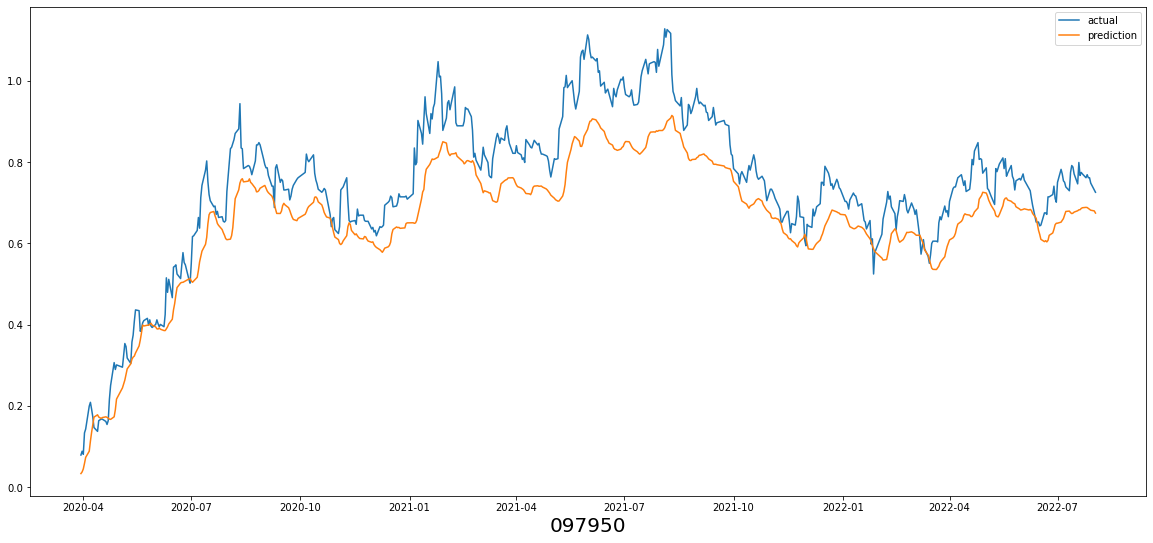

8/8 [==============================] - 1s 6ms/step
271560의 test_data의 출력 크기 :  (230, 1)


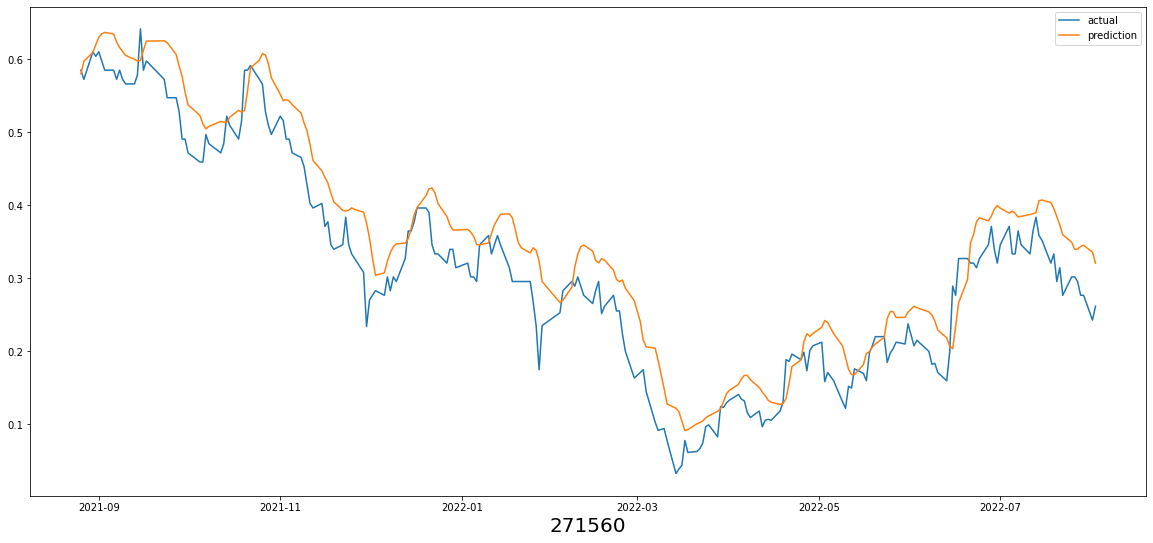

19/19 [==============================] - 1s 4ms/step
000080의 test_data의 출력 크기 :  (580, 1)


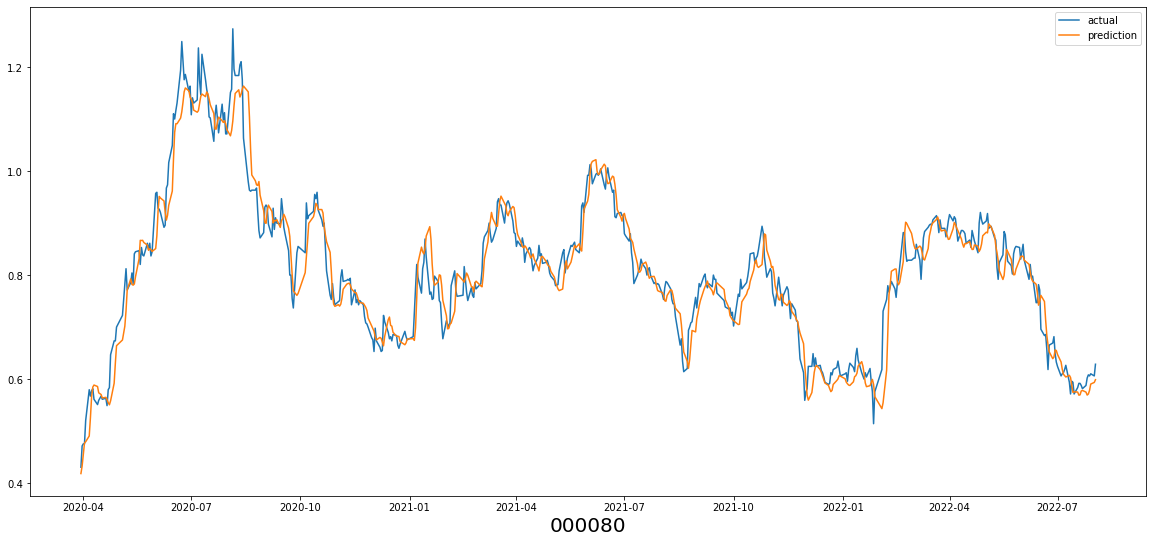

19/19 [==============================] - 1s 4ms/step
004370의 test_data의 출력 크기 :  (580, 1)


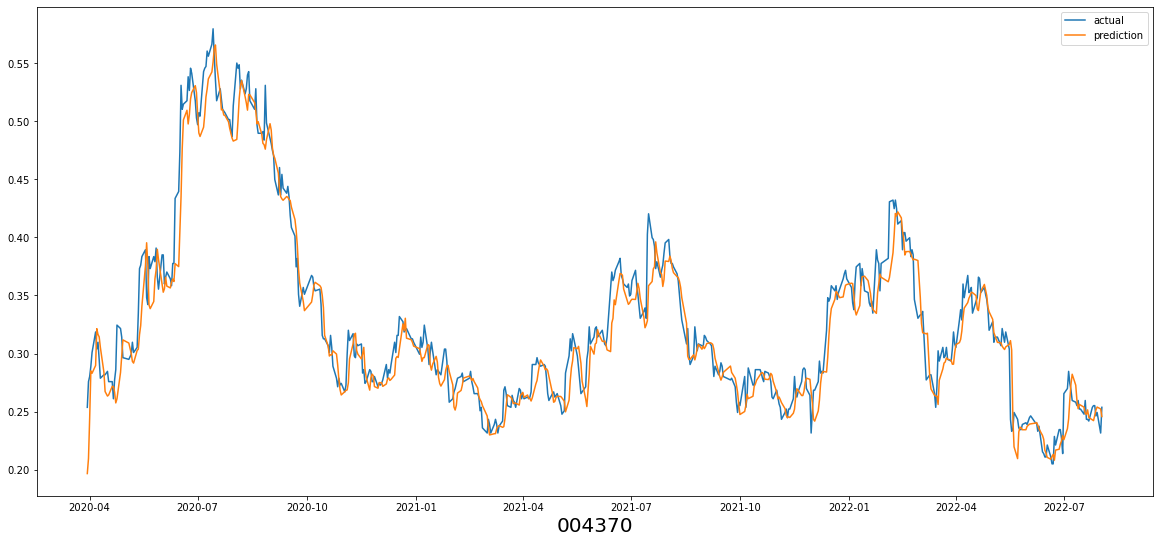

19/19 [==============================] - 1s 4ms/step
005300의 test_data의 출력 크기 :  (580, 1)


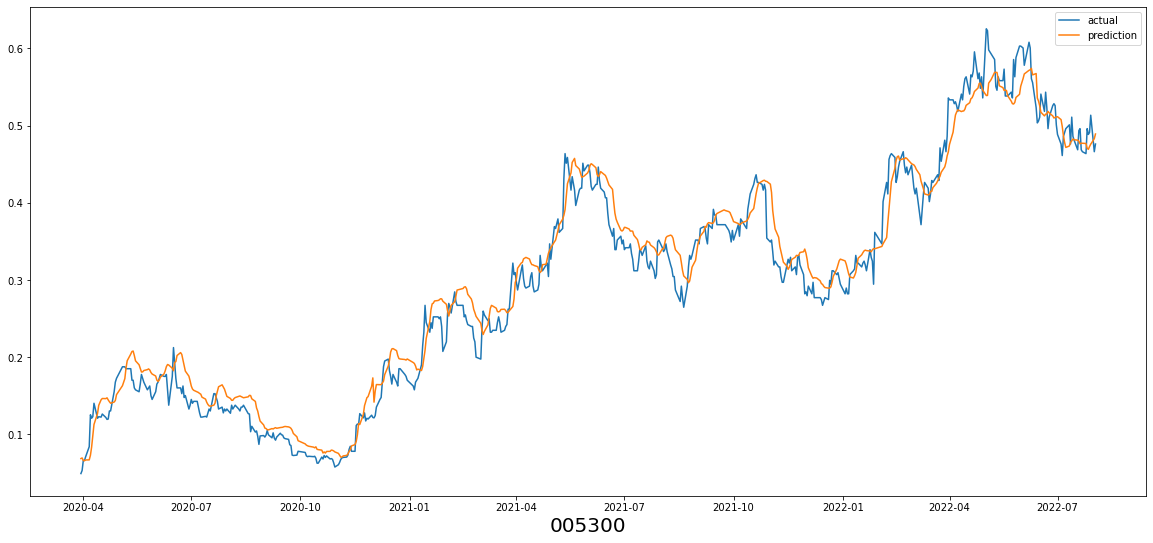

---------------Clothing---------------
19/19 [==============================] - 1s 5ms/step
093050의 test_data의 출력 크기 :  (580, 1)


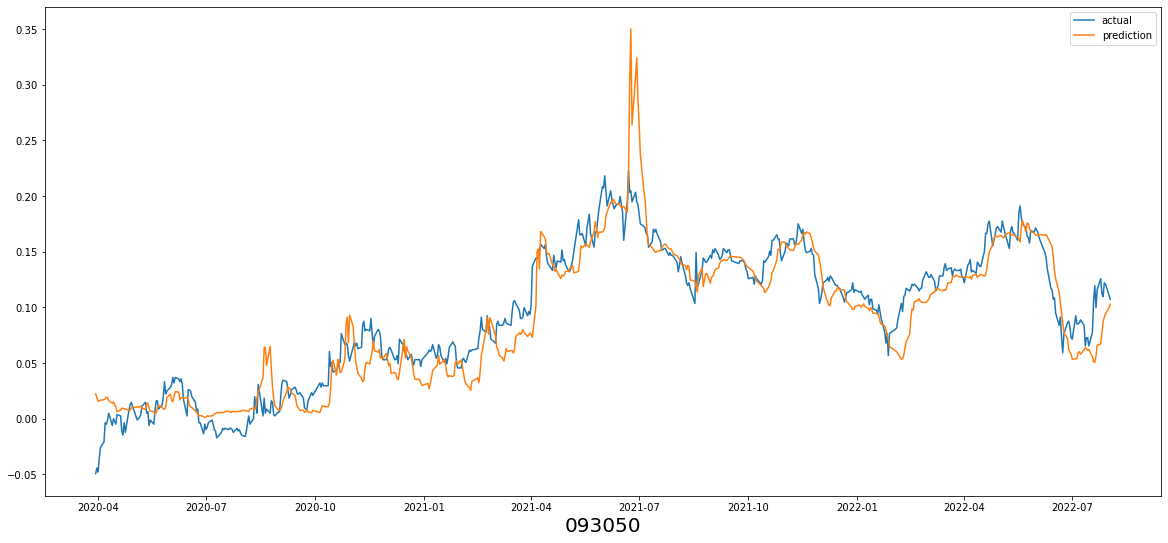

19/19 [==============================] - 1s 5ms/step
020000의 test_data의 출력 크기 :  (580, 1)


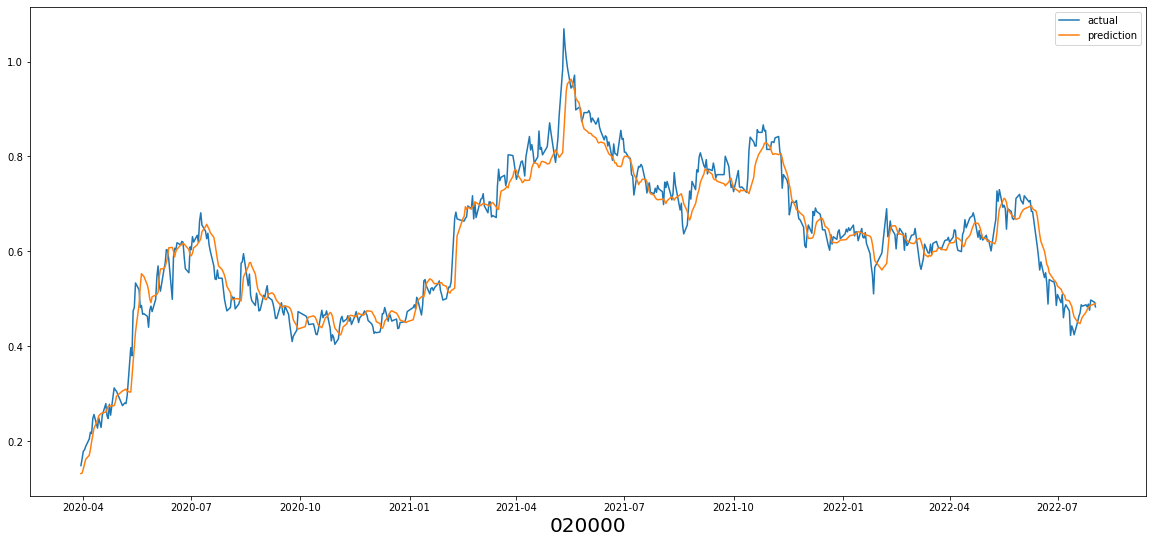

19/19 [==============================] - 1s 4ms/step
105630의 test_data의 출력 크기 :  (580, 1)


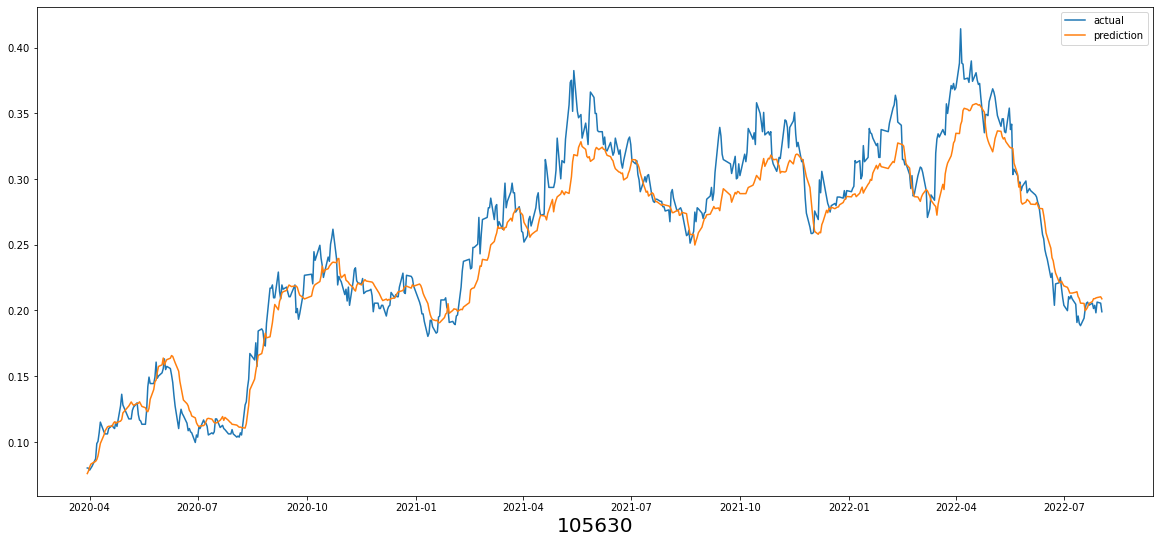

19/19 [==============================] - 1s 5ms/step
001070의 test_data의 출력 크기 :  (580, 1)


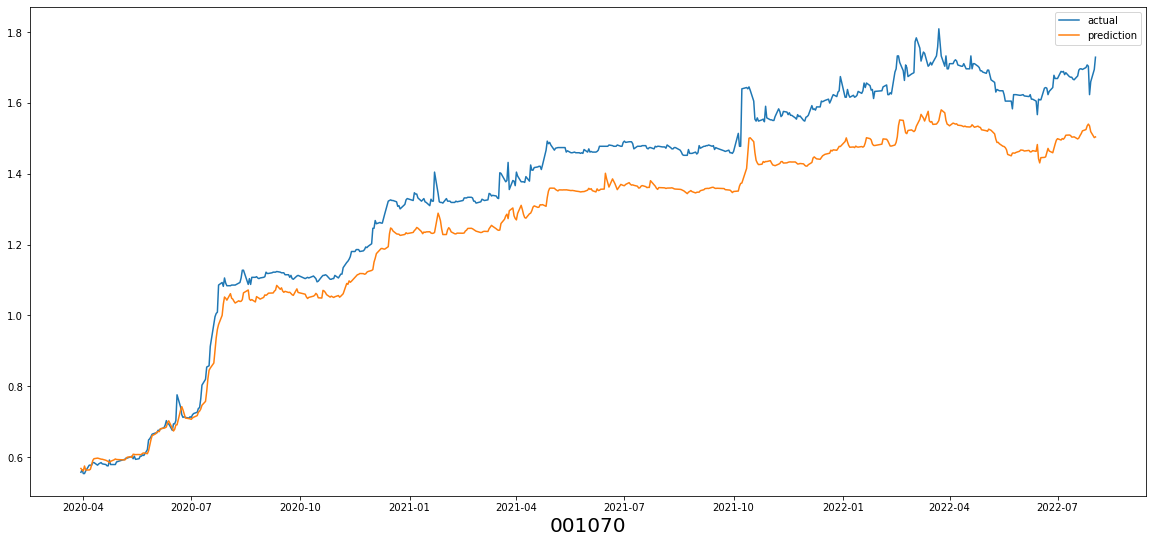

---------------Chemical---------------
19/19 [==============================] - 1s 4ms/step
051910의 test_data의 출력 크기 :  (580, 1)


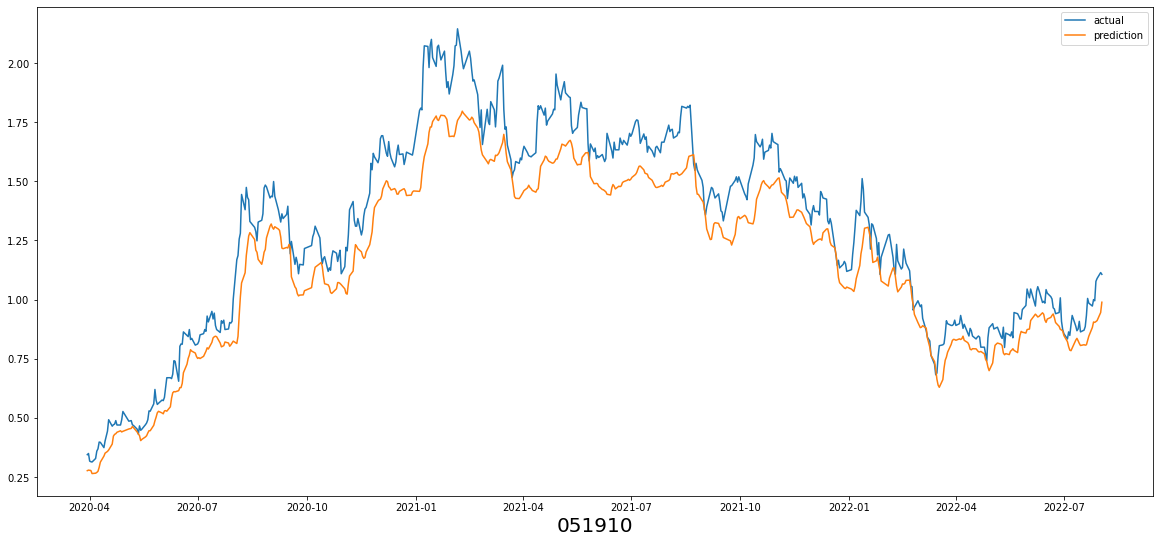

19/19 [==============================] - 1s 5ms/step
096770의 test_data의 출력 크기 :  (580, 1)


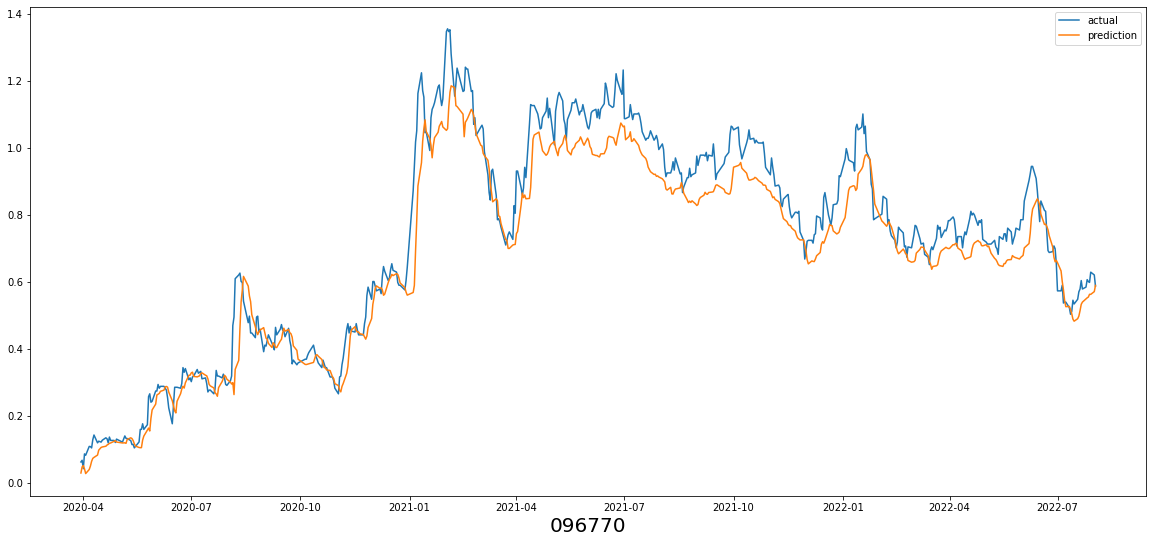

19/19 [==============================] - 1s 4ms/step
010950의 test_data의 출력 크기 :  (580, 1)


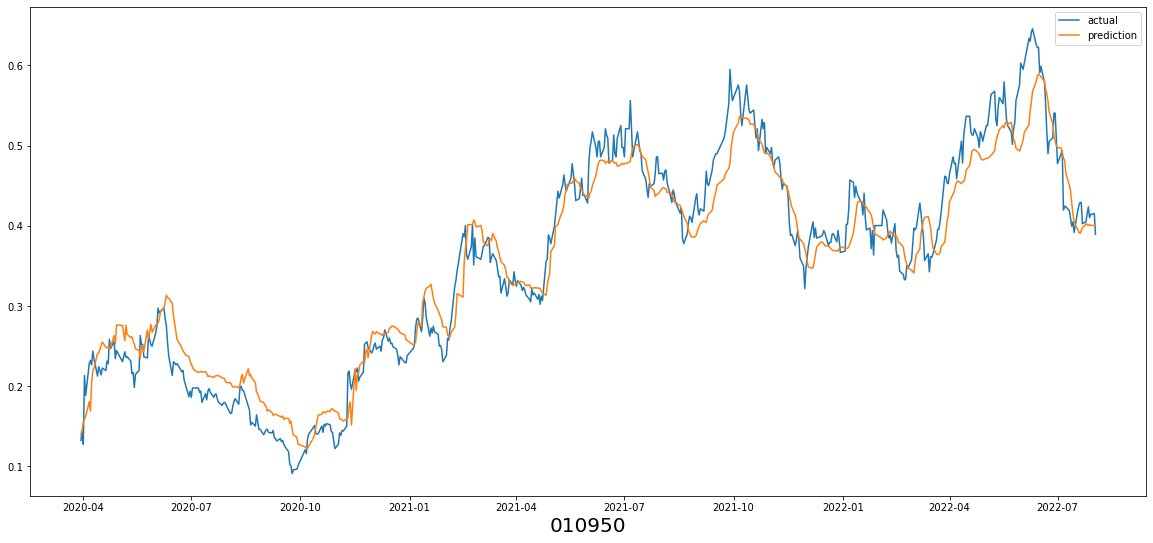

19/19 [==============================] - 1s 5ms/step
051900의 test_data의 출력 크기 :  (580, 1)


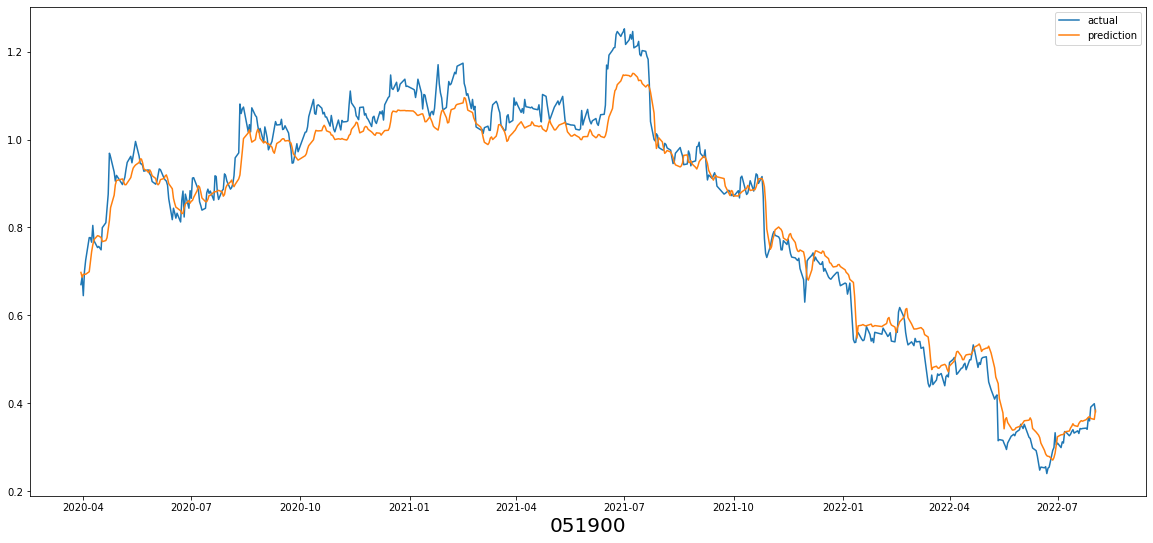

19/19 [==============================] - 1s 5ms/step
090430의 test_data의 출력 크기 :  (580, 1)


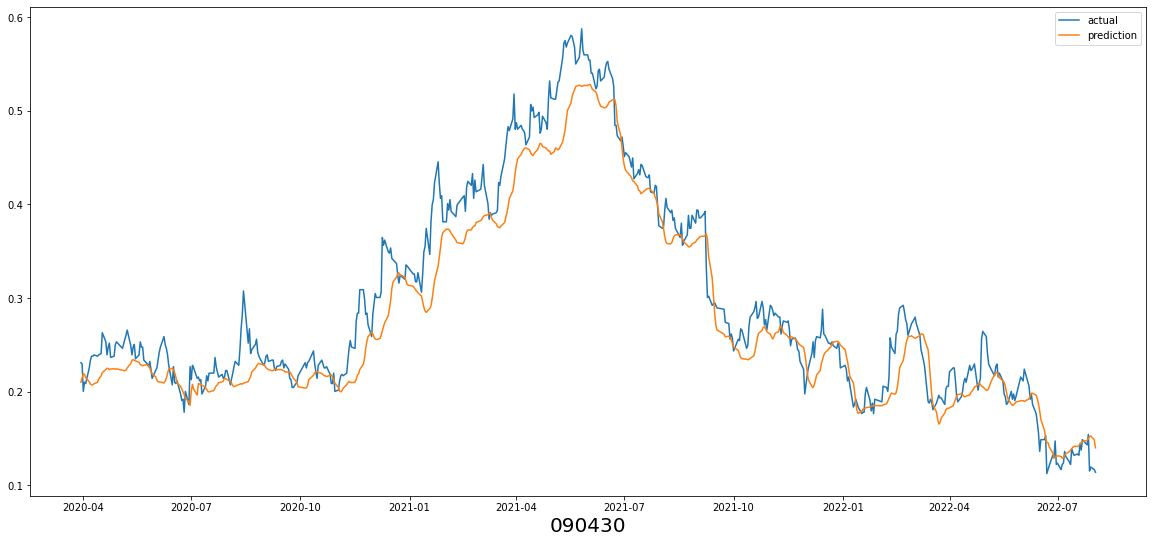

---------------Medicine---------------
9/9 [==============================] - 1s 6ms/step
207940의 test_data의 출력 크기 :  (262, 1)


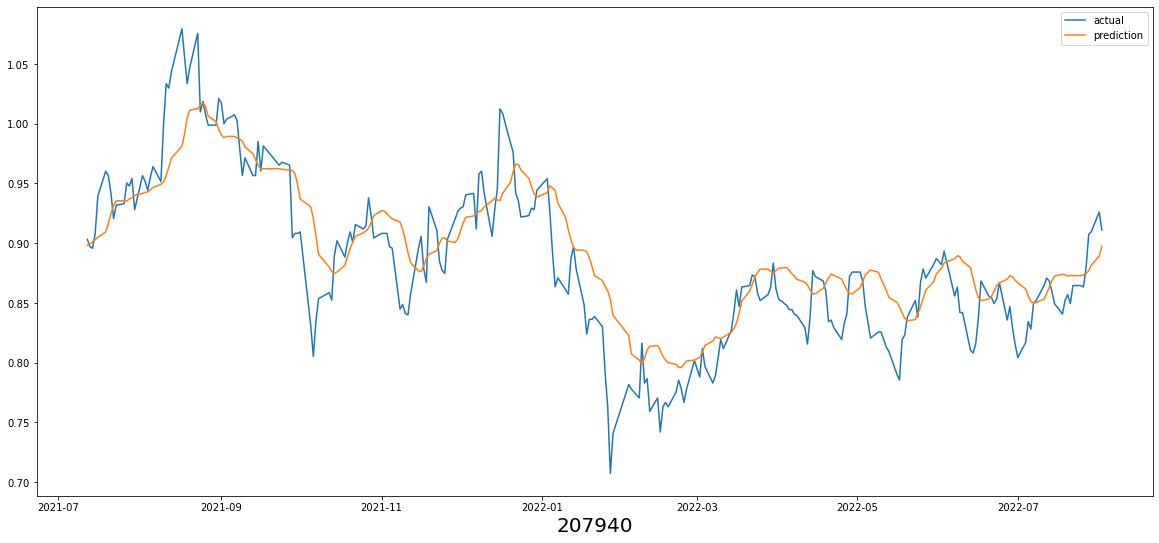

19/19 [==============================] - 1s 5ms/step
068270의 test_data의 출력 크기 :  (580, 1)


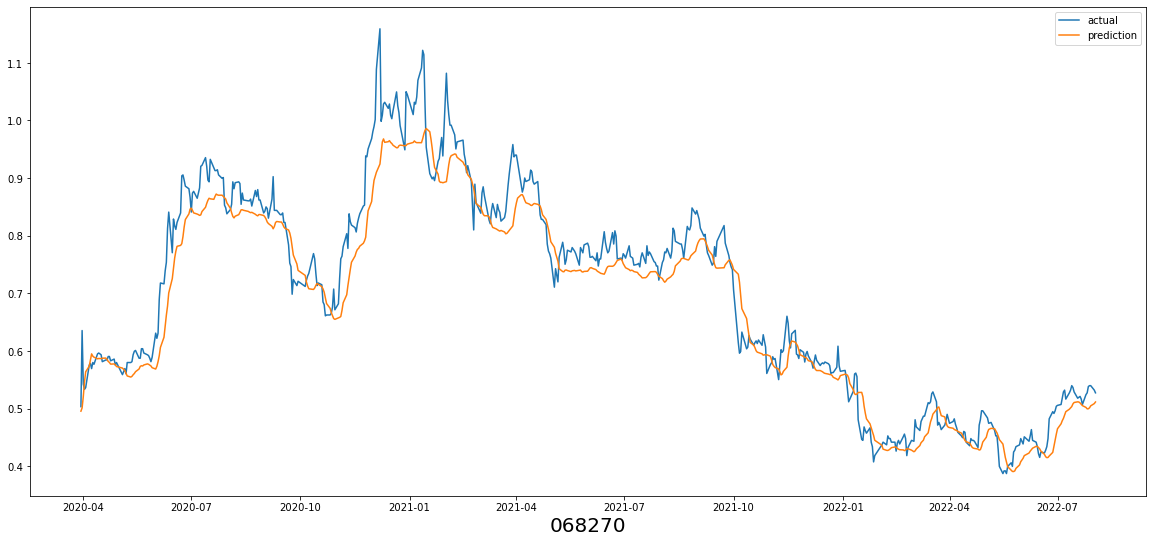

19/19 [==============================] - 1s 5ms/step
000100의 test_data의 출력 크기 :  (580, 1)


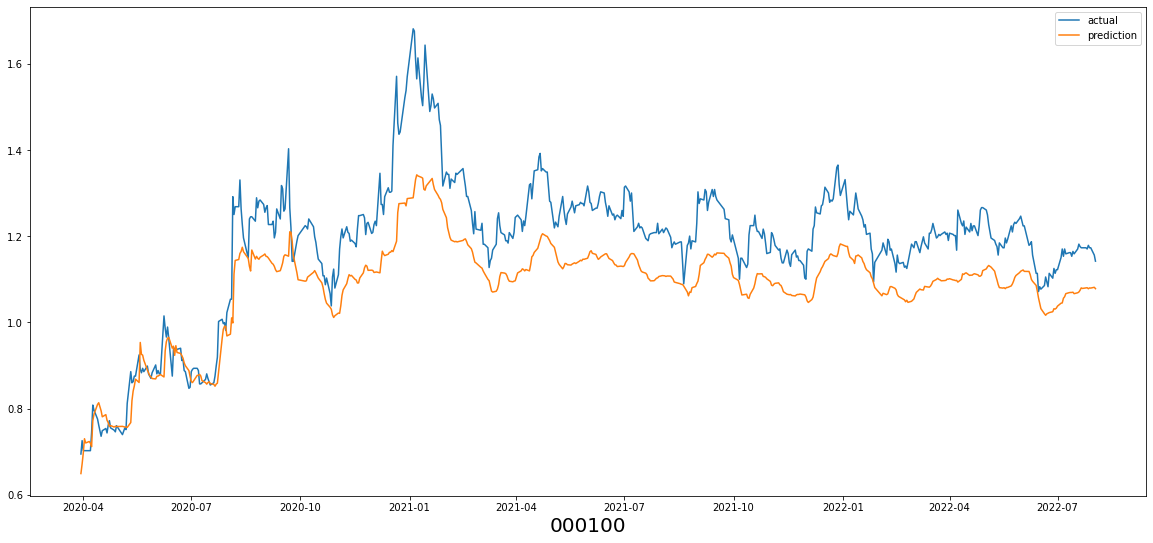

18/18 [==============================] - 1s 5ms/step
128940의 test_data의 출력 크기 :  (573, 1)


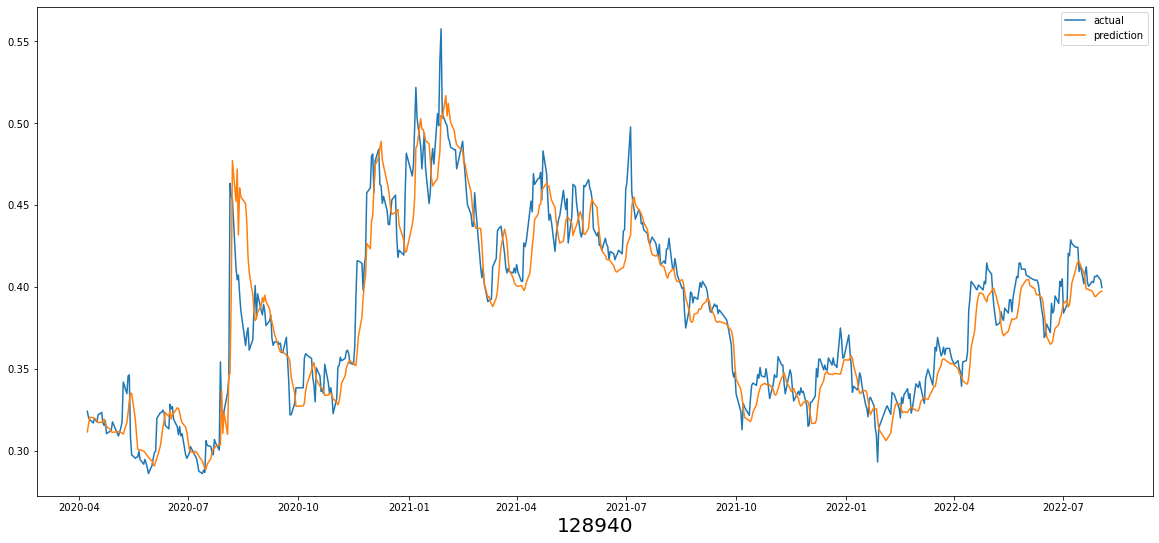

---------------Non_Metal---------------
19/19 [==============================] - 1s 4ms/step
003670의 test_data의 출력 크기 :  (580, 1)


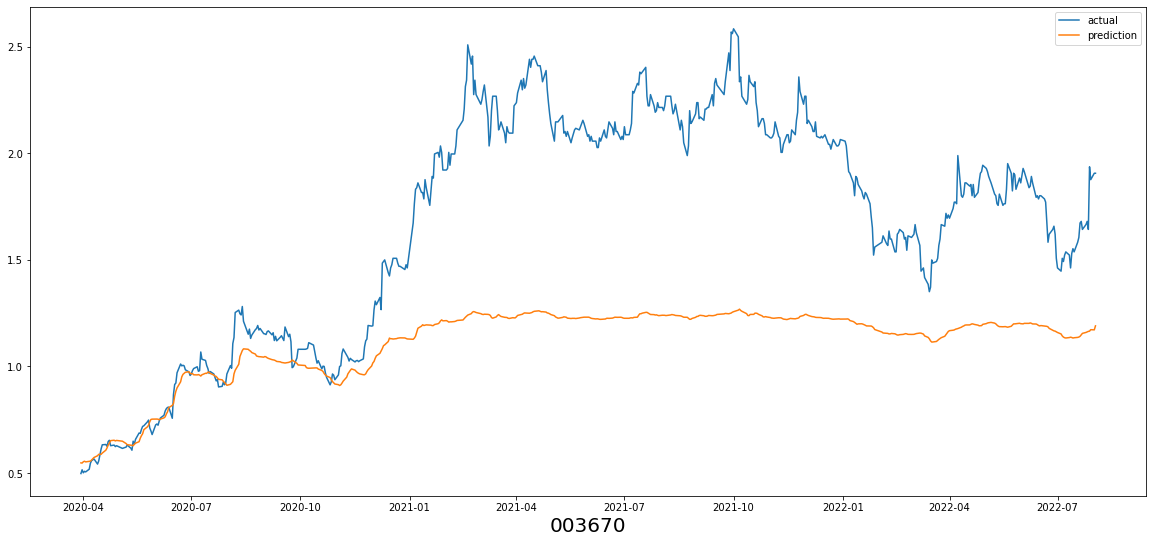

19/19 [==============================] - 1s 4ms/step
003410의 test_data의 출력 크기 :  (580, 1)


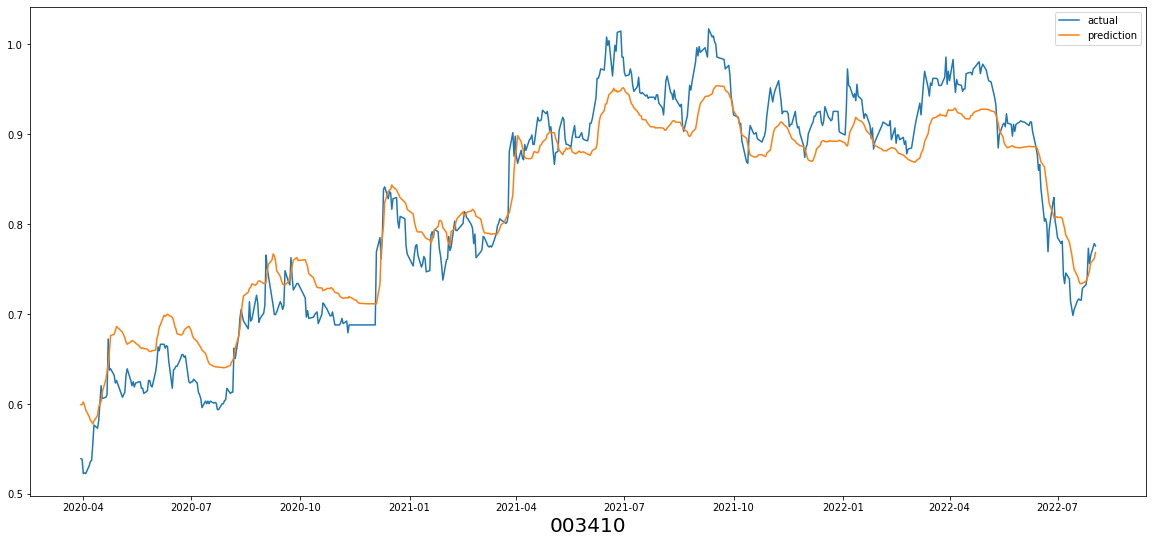

19/19 [==============================] - 1s 4ms/step
010780의 test_data의 출력 크기 :  (580, 1)


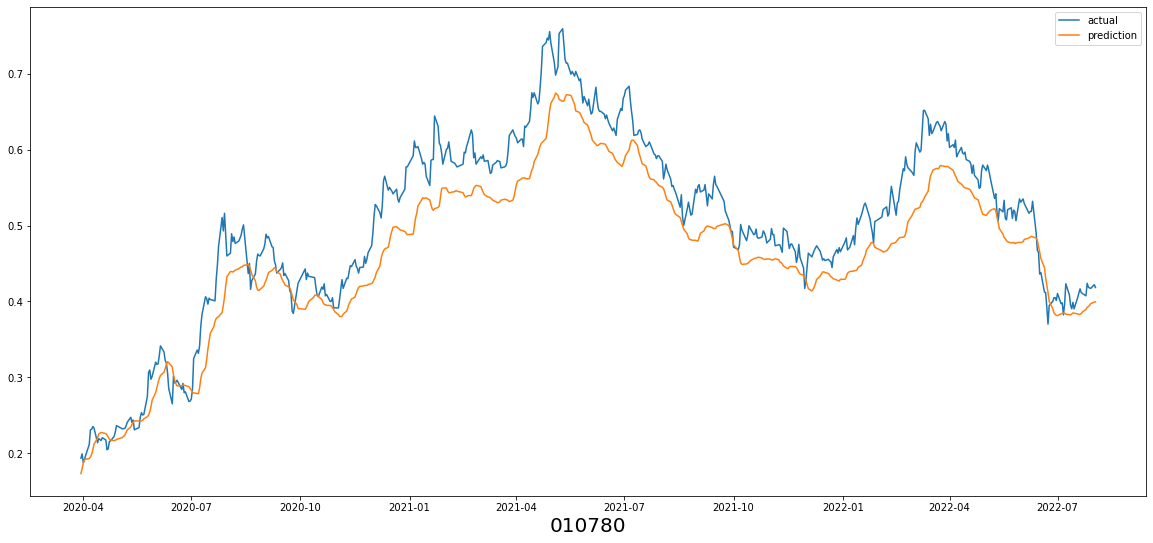

---------------Metal---------------
19/19 [==============================] - 1s 4ms/step
005490의 test_data의 출력 크기 :  (580, 1)


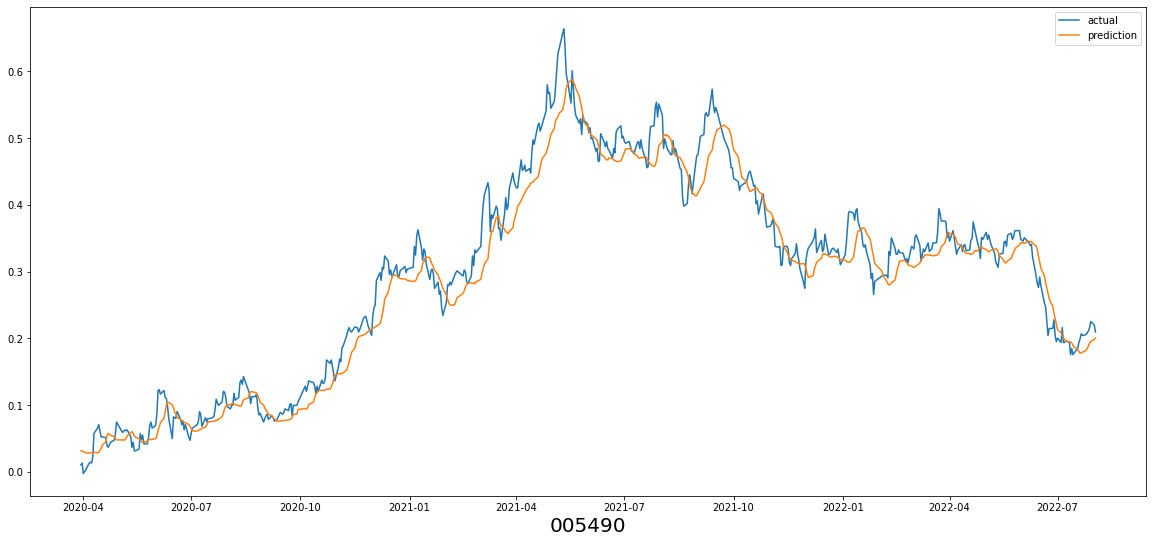

19/19 [==============================] - 1s 5ms/step
010130의 test_data의 출력 크기 :  (580, 1)


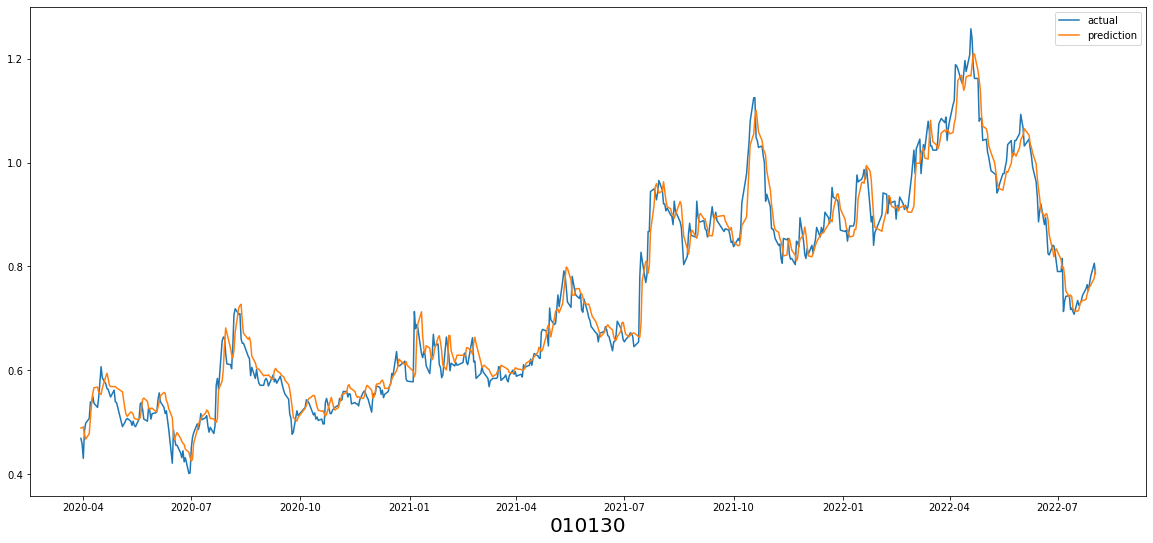

19/19 [==============================] - 1s 4ms/step
004020의 test_data의 출력 크기 :  (580, 1)


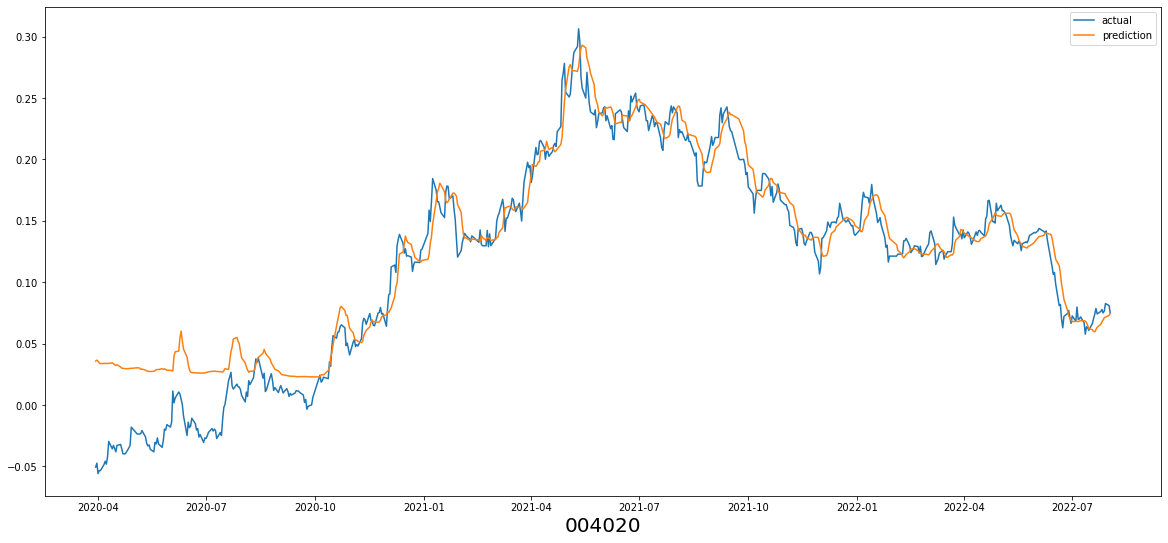

19/19 [==============================] - 1s 5ms/step
016380의 test_data의 출력 크기 :  (580, 1)


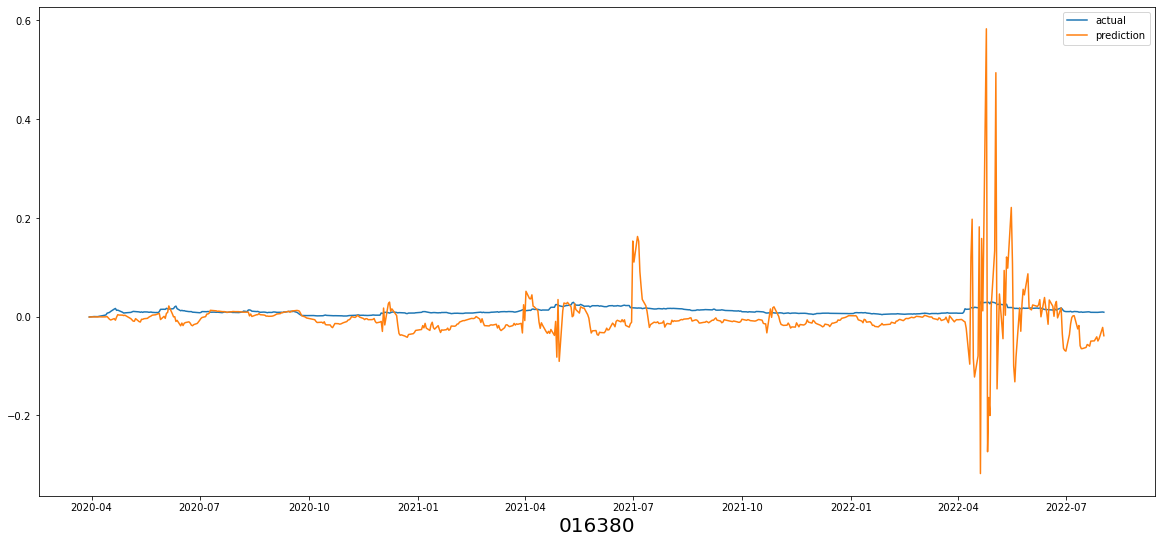

19/19 [==============================] - 1s 4ms/step
001230의 test_data의 출력 크기 :  (580, 1)


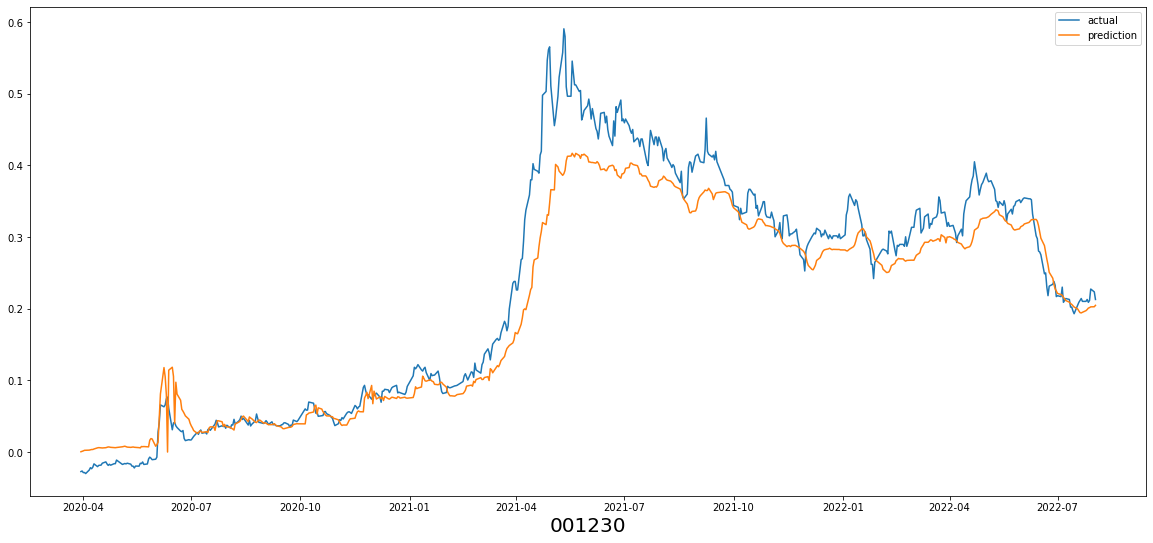

---------------Machine---------------
19/19 [==============================] - 1s 4ms/step
034020의 test_data의 출력 크기 :  (580, 1)


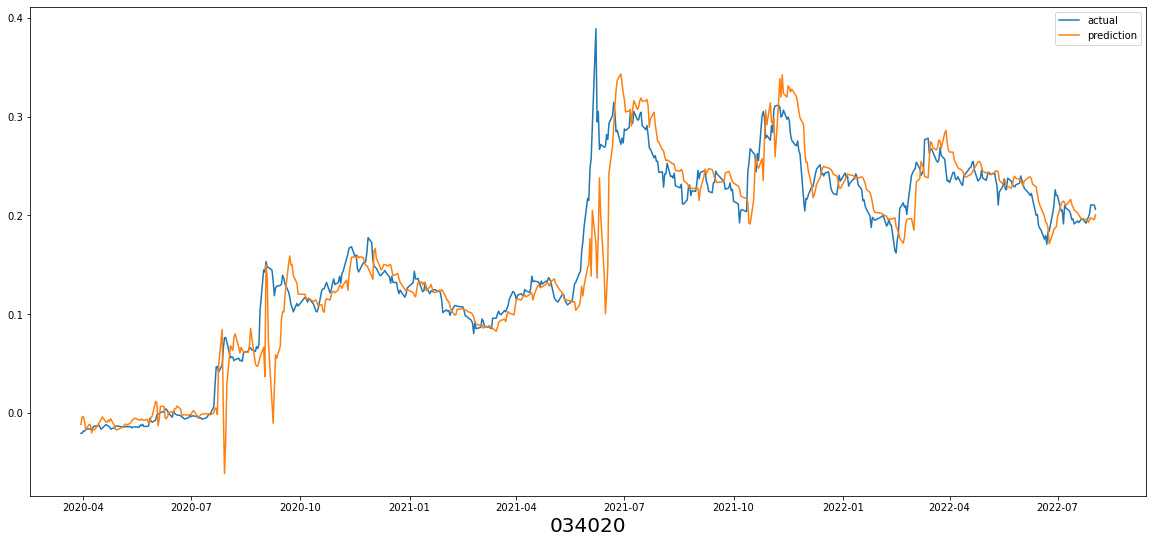

19/19 [==============================] - 1s 5ms/step
018880의 test_data의 출력 크기 :  (580, 1)


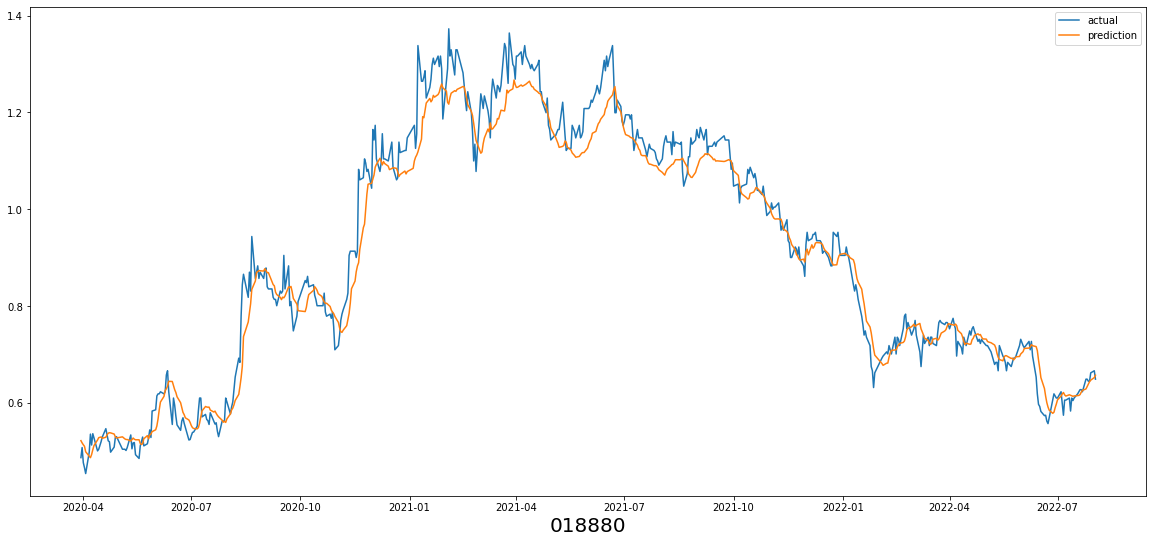

9/9 [==============================] - 1s 5ms/step
241560의 test_data의 출력 크기 :  (261, 1)


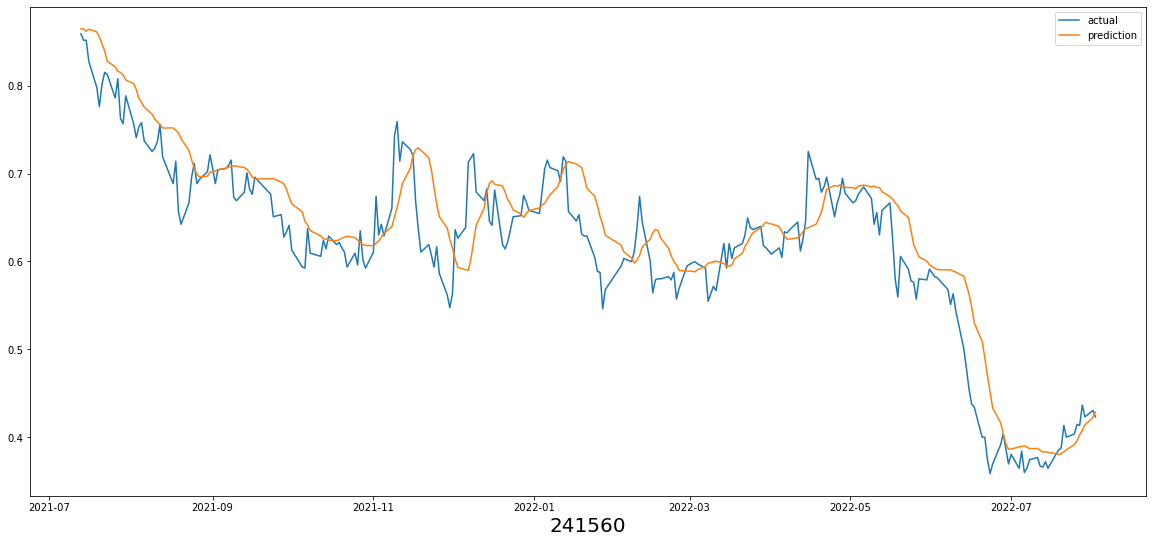

12/12 [==============================] - 1s 5ms/step
112610의 test_data의 출력 크기 :  (358, 1)


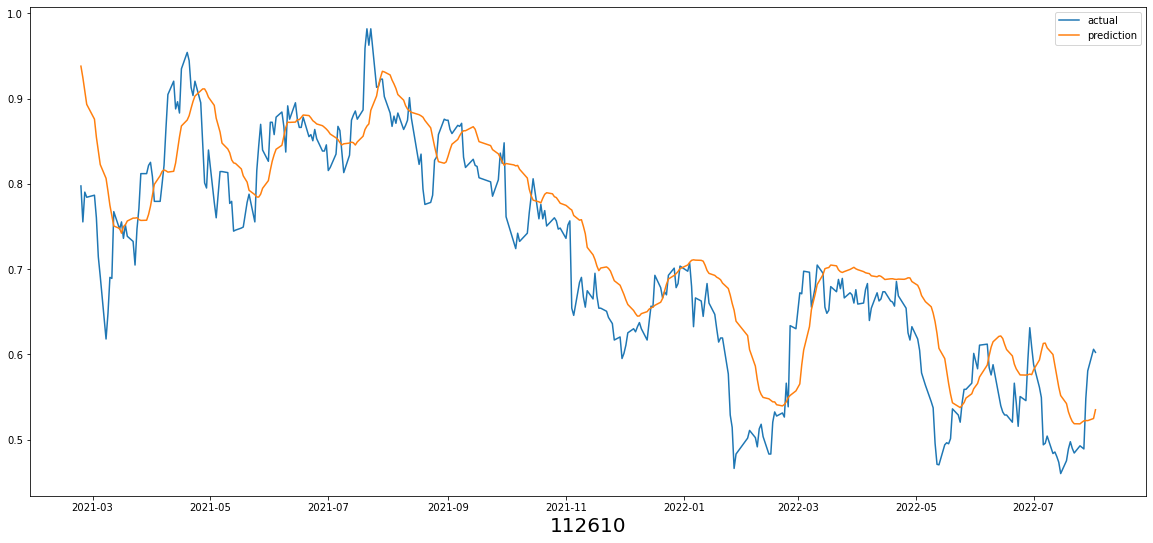

---------------Electronic---------------
19/19 [==============================] - 1s 4ms/step
005930의 test_data의 출력 크기 :  (580, 1)


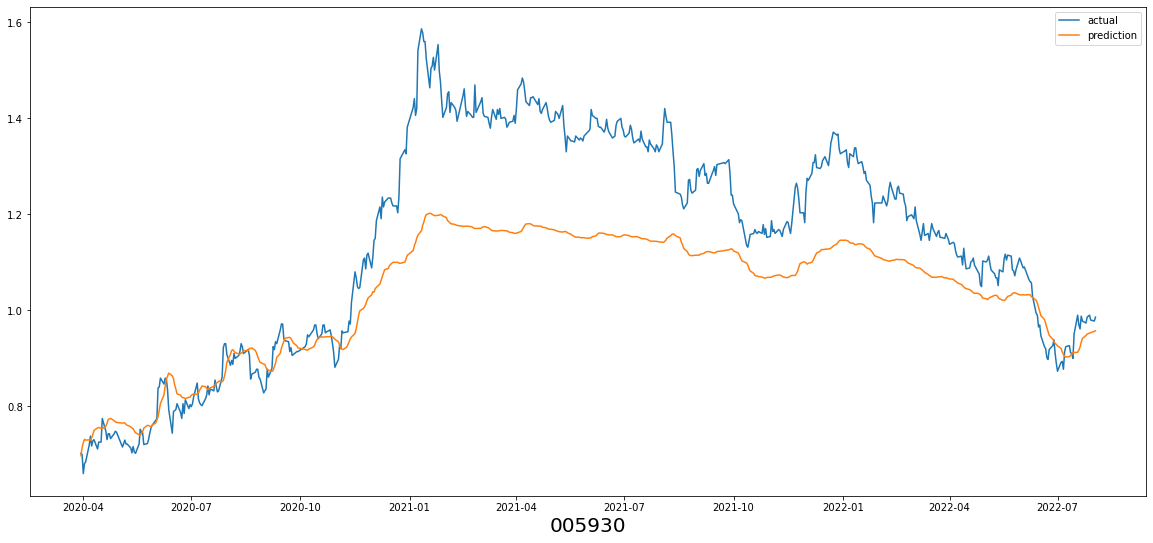

19/19 [==============================] - 1s 4ms/step
000660의 test_data의 출력 크기 :  (580, 1)


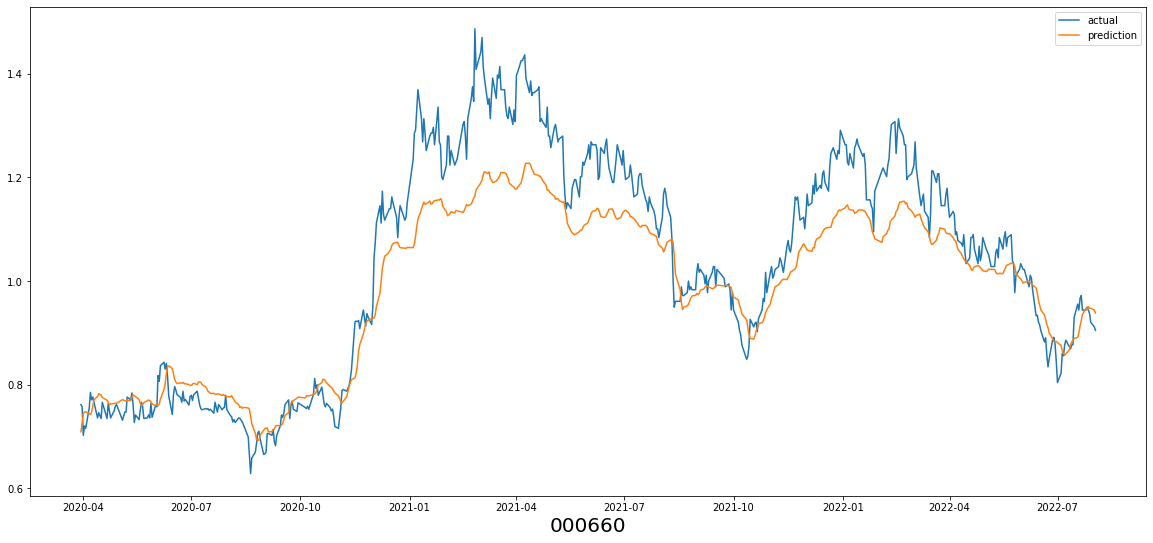

19/19 [==============================] - 1s 5ms/step
006400의 test_data의 출력 크기 :  (580, 1)


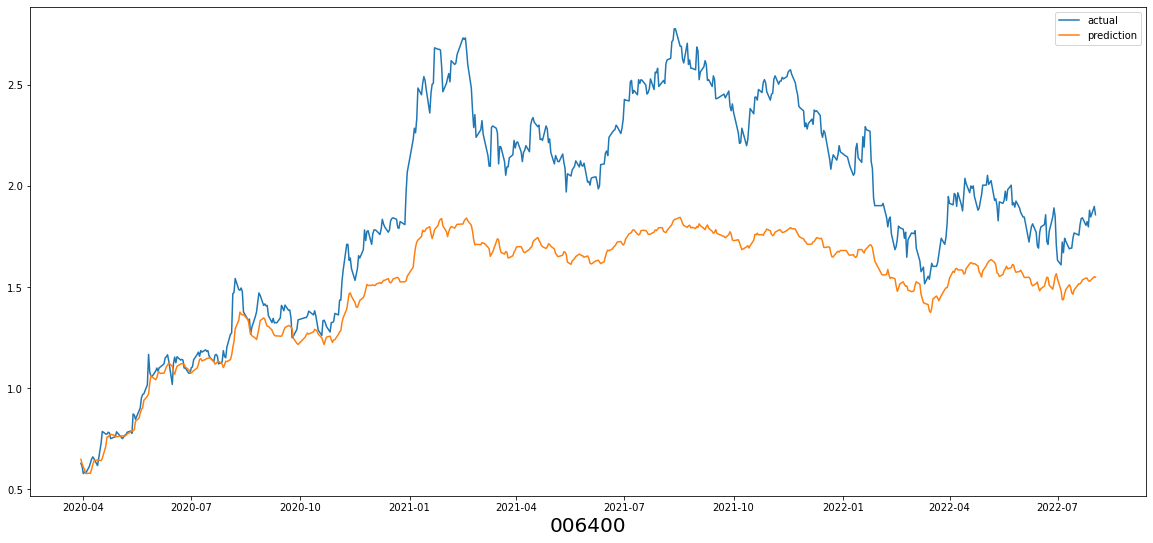

19/19 [==============================] - 1s 4ms/step
066570의 test_data의 출력 크기 :  (580, 1)


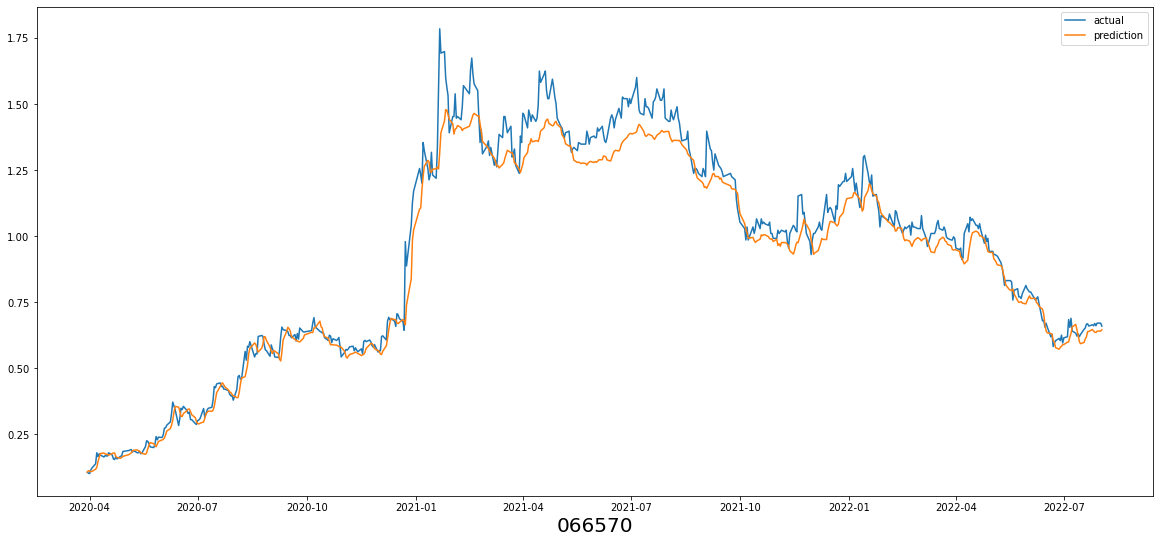

---------------Construction---------------
19/19 [==============================] - 1s 5ms/step
000720의 test_data의 출력 크기 :  (580, 1)


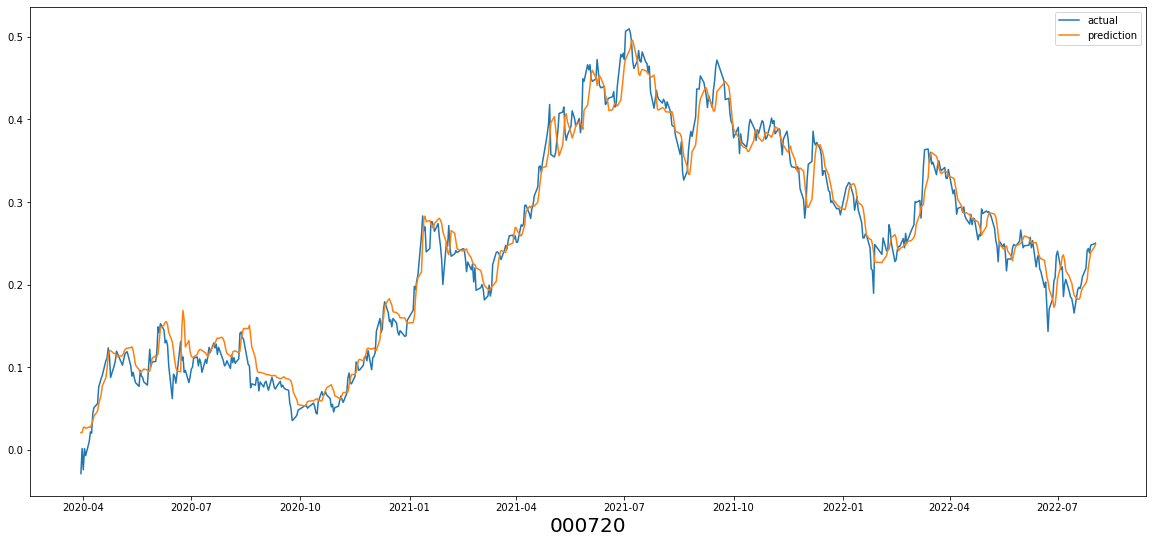

19/19 [==============================] - 1s 5ms/step
006360의 test_data의 출력 크기 :  (580, 1)


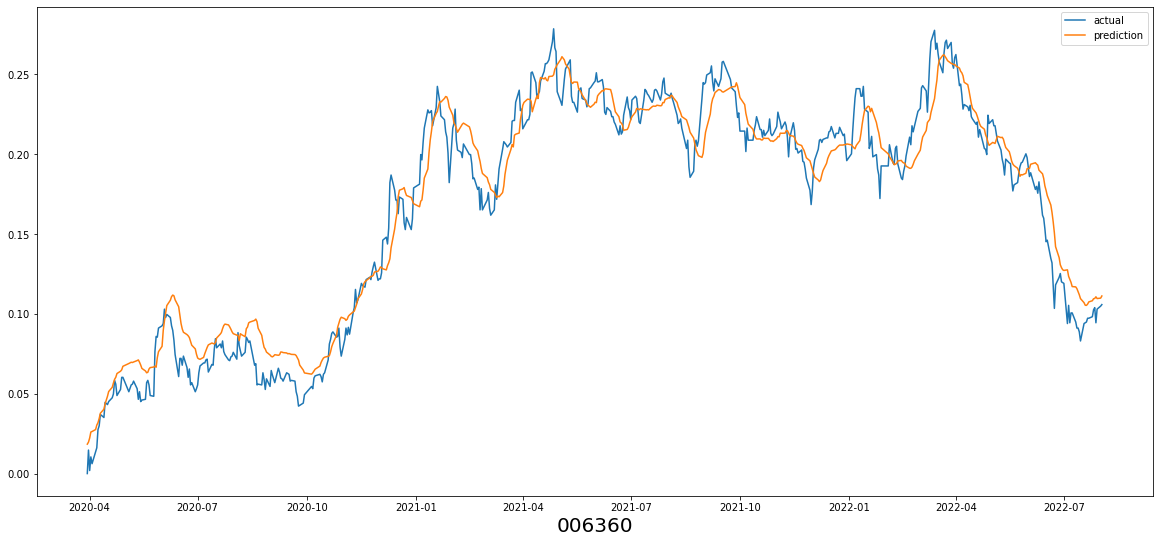

19/19 [==============================] - 1s 5ms/step
047040의 test_data의 출력 크기 :  (580, 1)


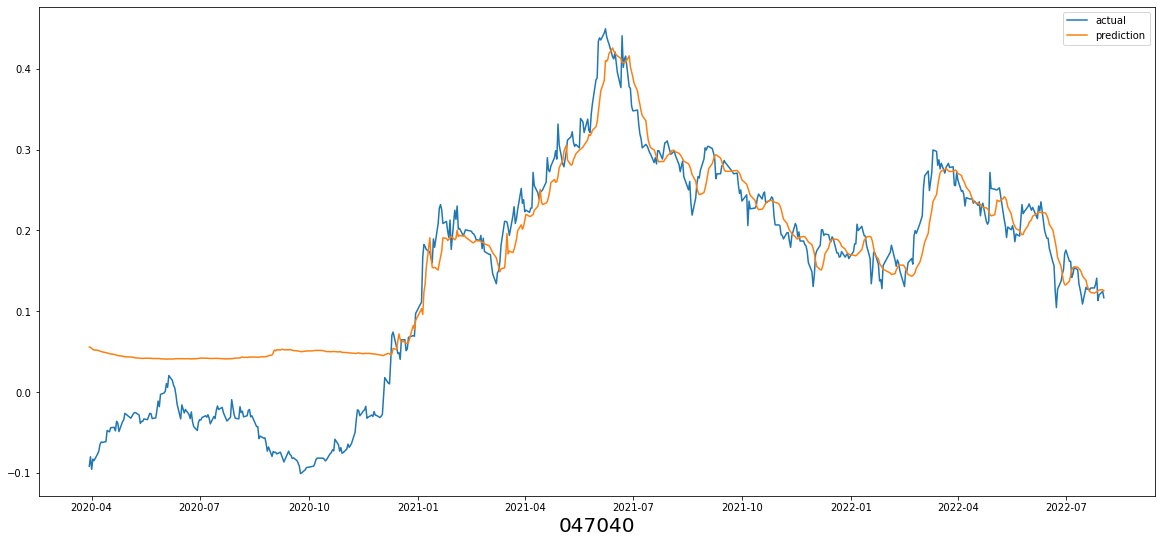

19/19 [==============================] - 1s 5ms/step
051600의 test_data의 출력 크기 :  (580, 1)


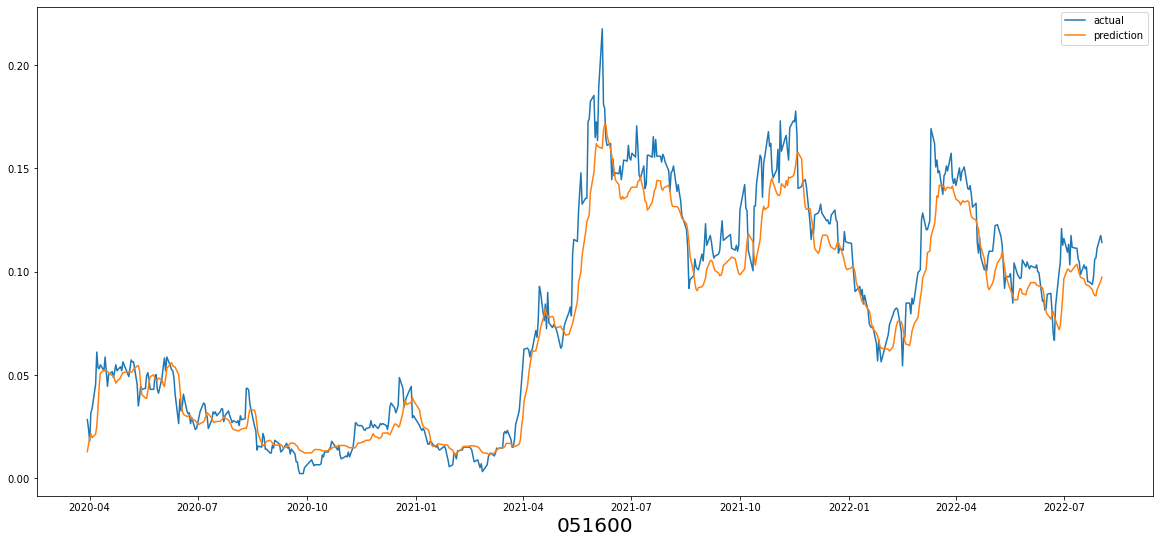

---------------Transport---------------
19/19 [==============================] - 1s 4ms/step
011200의 test_data의 출력 크기 :  (580, 1)


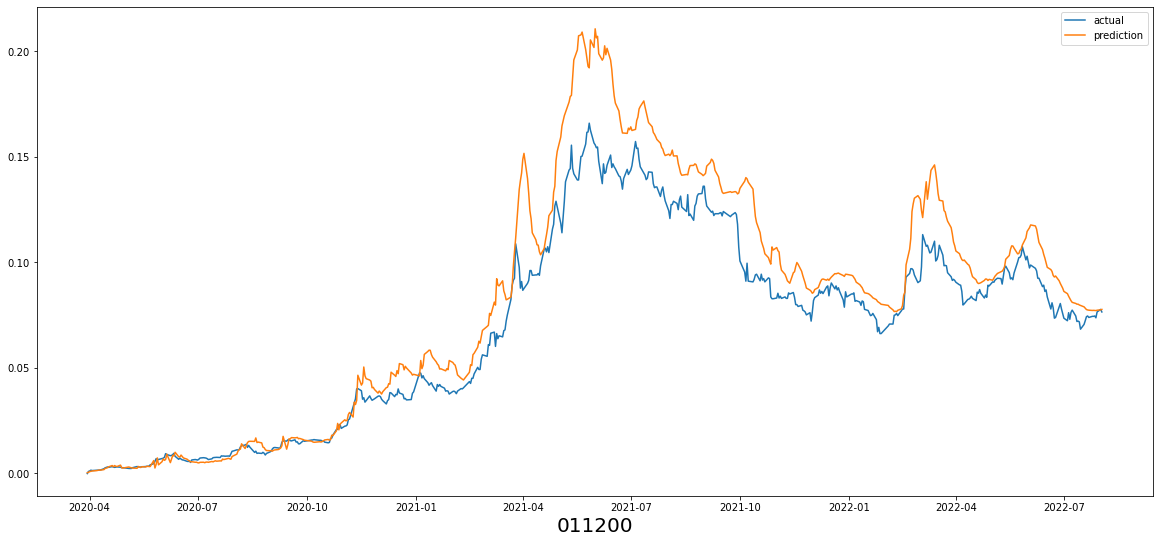

19/19 [==============================] - 1s 5ms/step
003490의 test_data의 출력 크기 :  (580, 1)


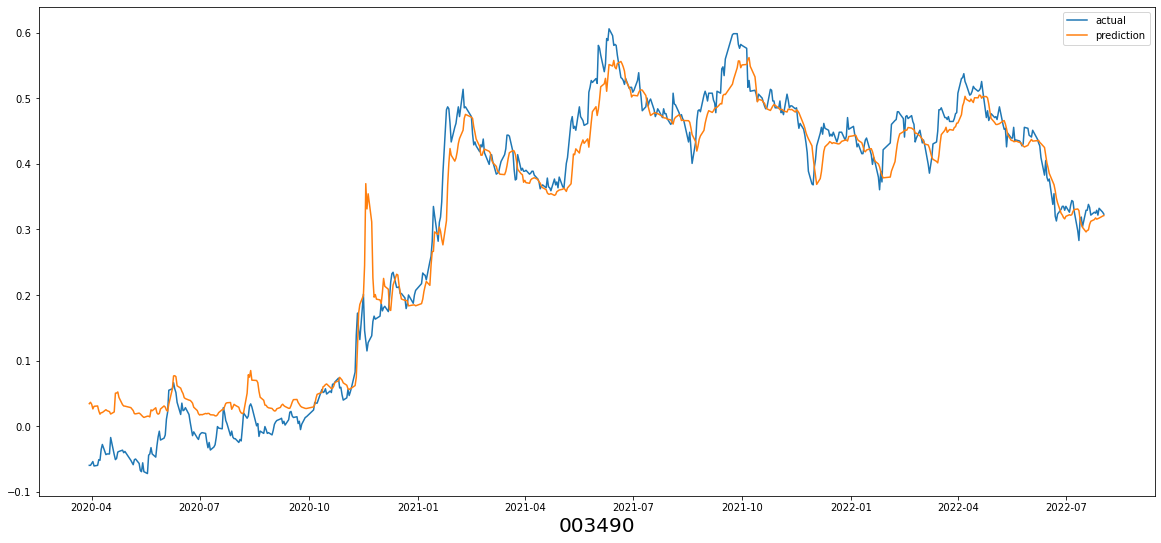

19/19 [==============================] - 1s 5ms/step
086280의 test_data의 출력 크기 :  (580, 1)


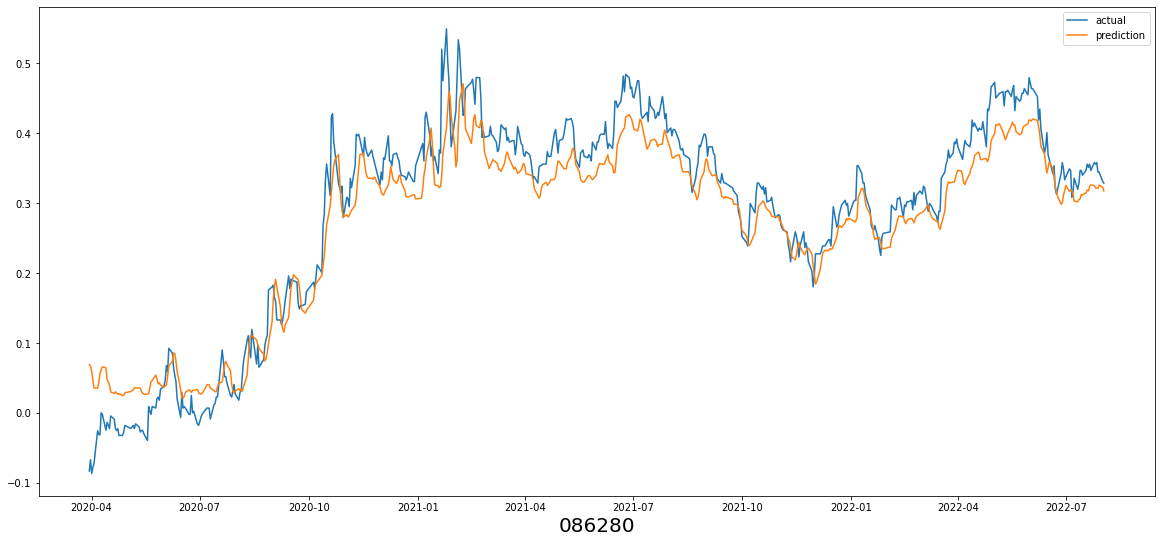

14/14 [==============================] - 1s 5ms/step
180640의 test_data의 출력 크기 :  (417, 1)


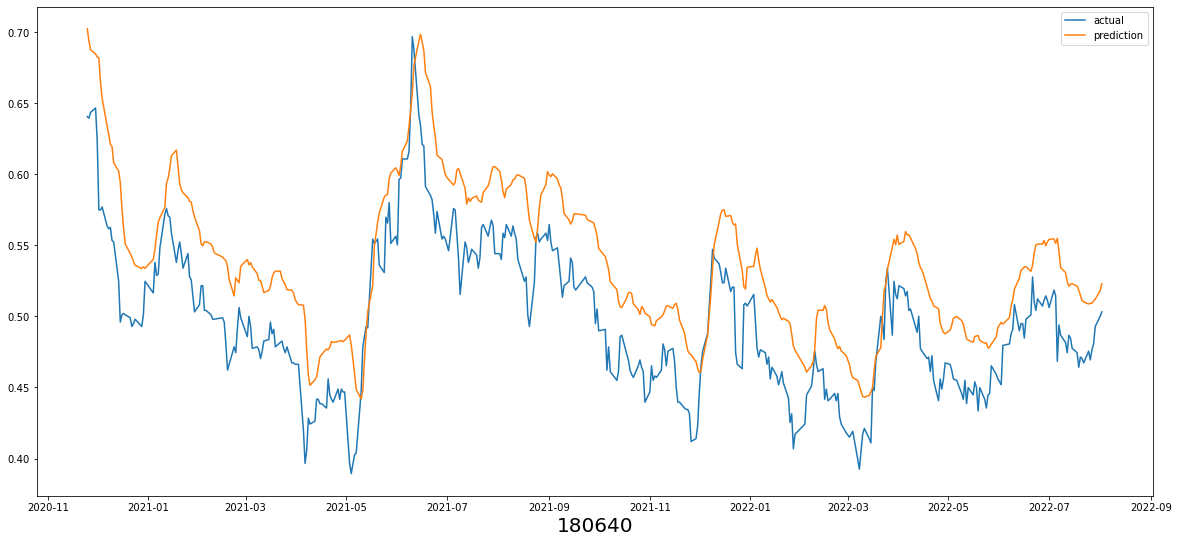

19/19 [==============================] - 1s 4ms/step
028670의 test_data의 출력 크기 :  (580, 1)


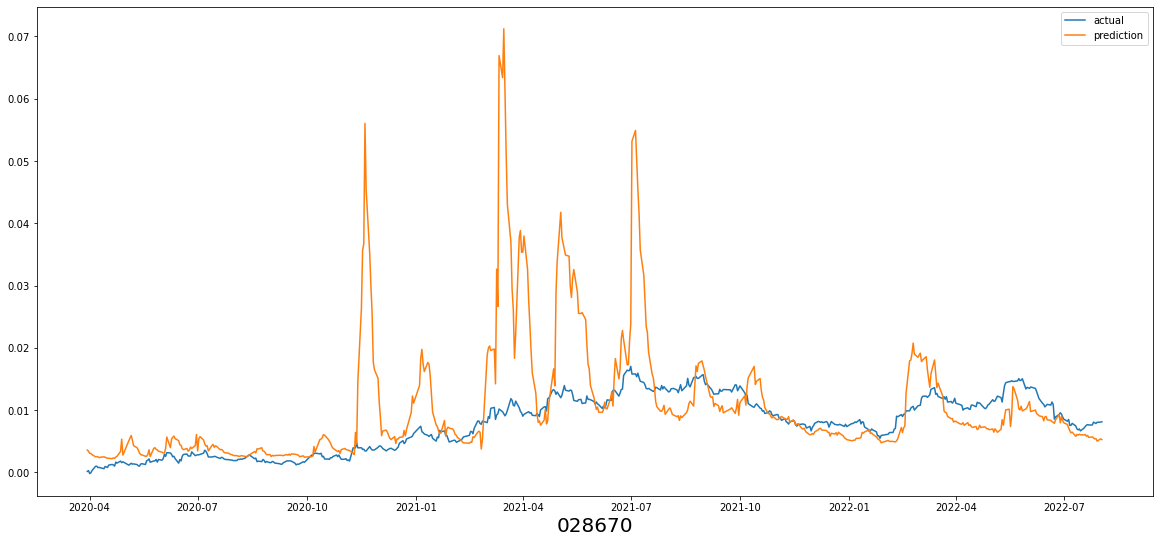

---------------Distribution---------------
12/12 [==============================] - 1s 5ms/step
028260의 test_data의 출력 크기 :  (355, 1)


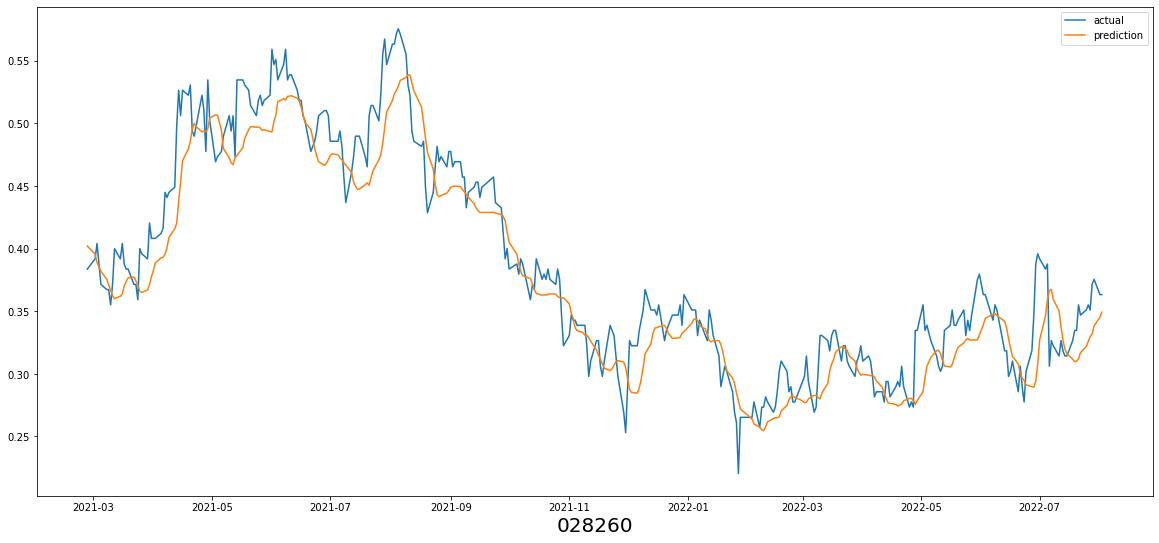

19/19 [==============================] - 1s 4ms/step
023530의 test_data의 출력 크기 :  (580, 1)


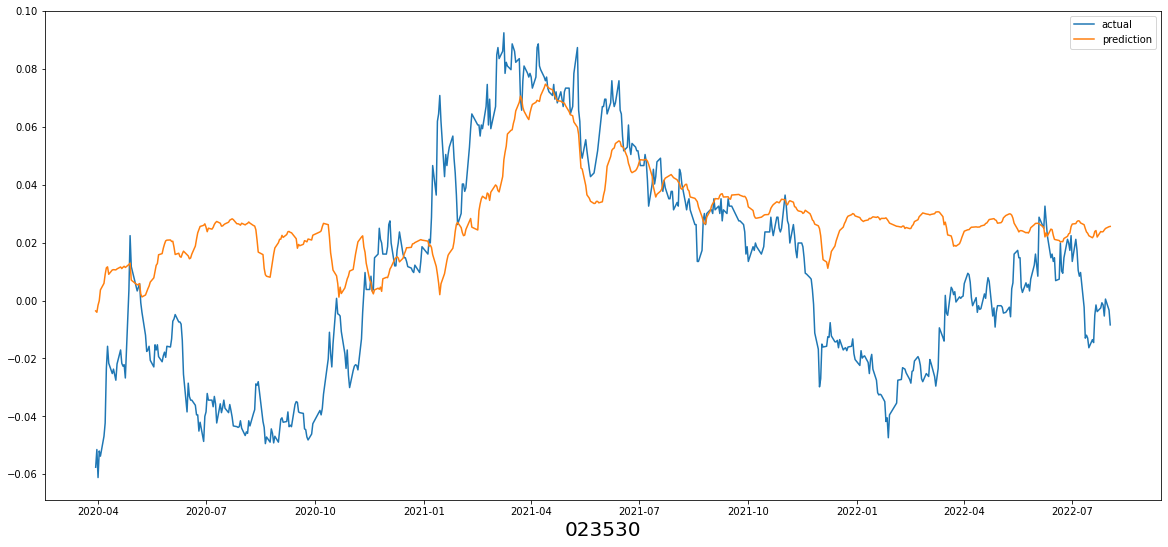

7/7 [==============================] - 1s 6ms/step
282330의 test_data의 출력 크기 :  (209, 1)


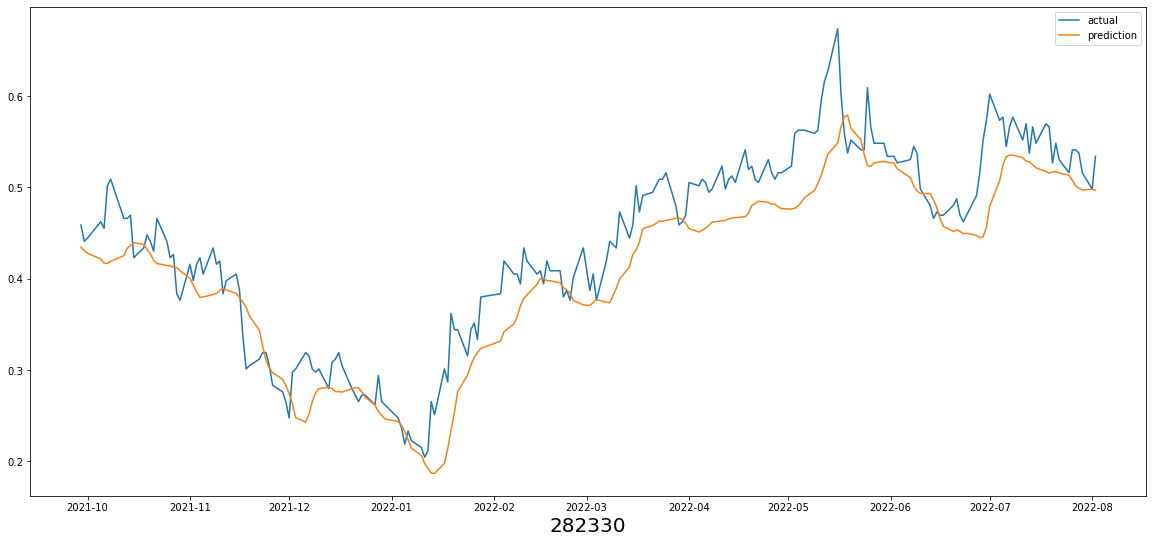

17/17 [==============================] - 1s 5ms/step
139480의 test_data의 출력 크기 :  (530, 1)


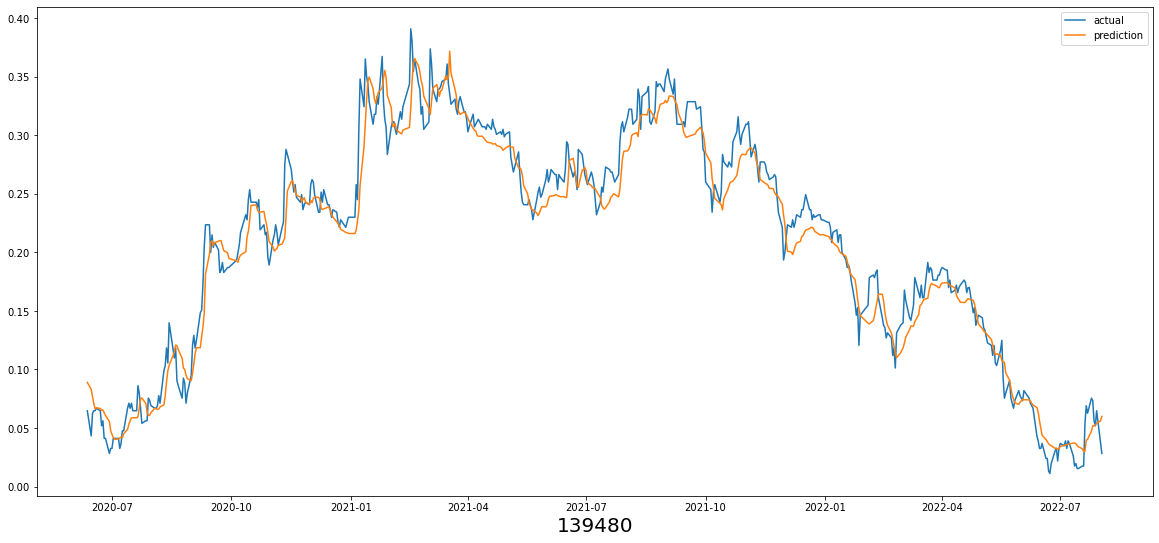

19/19 [==============================] - 1s 4ms/step
004170의 test_data의 출력 크기 :  (580, 1)


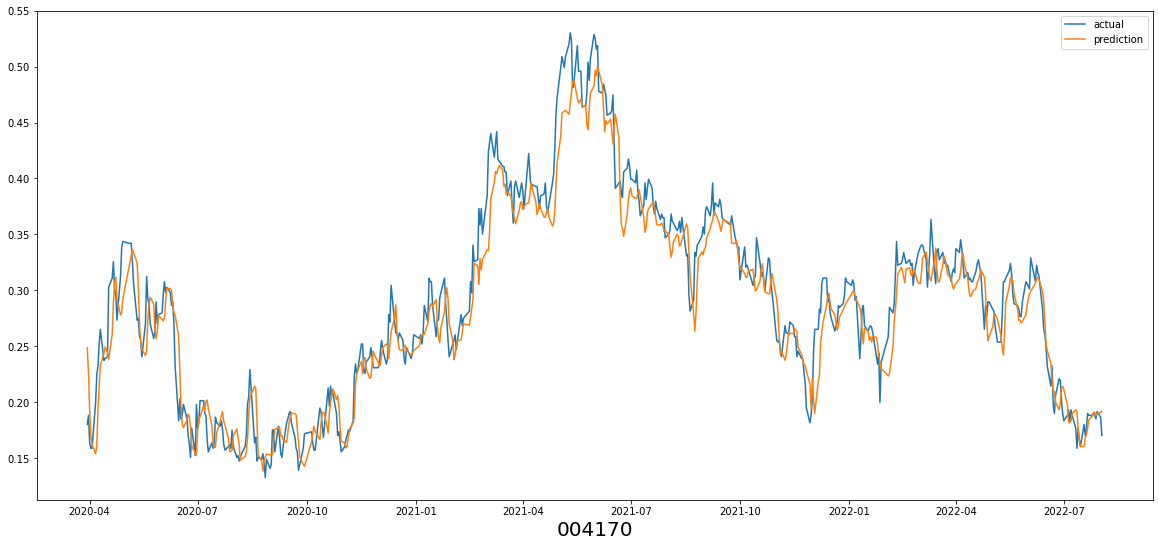

---------------Power---------------
19/19 [==============================] - 1s 5ms/step
015760의 test_data의 출력 크기 :  (580, 1)


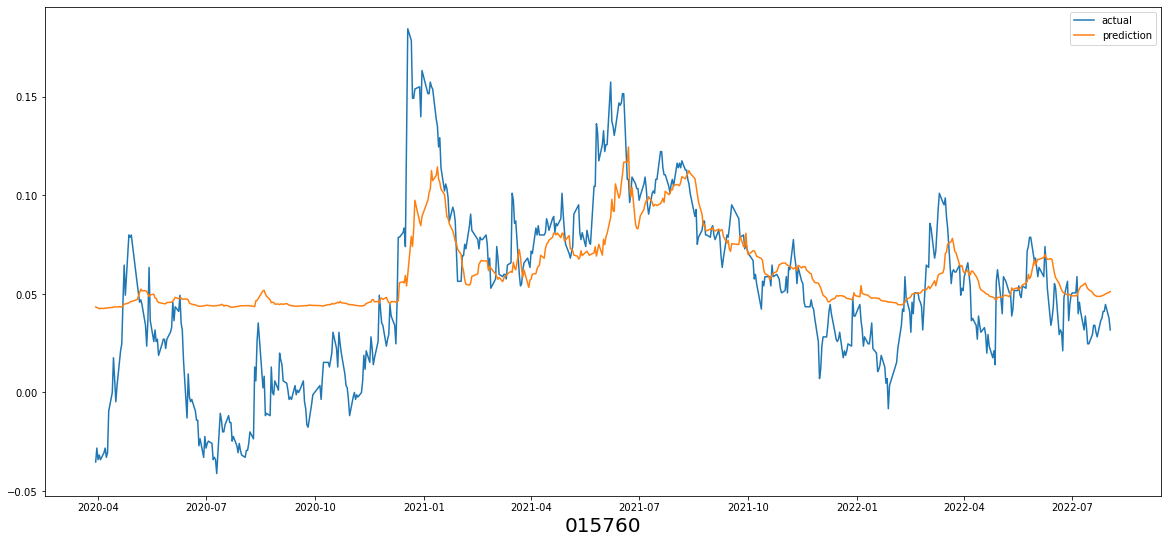

19/19 [==============================] - 1s 4ms/step
036460의 test_data의 출력 크기 :  (580, 1)


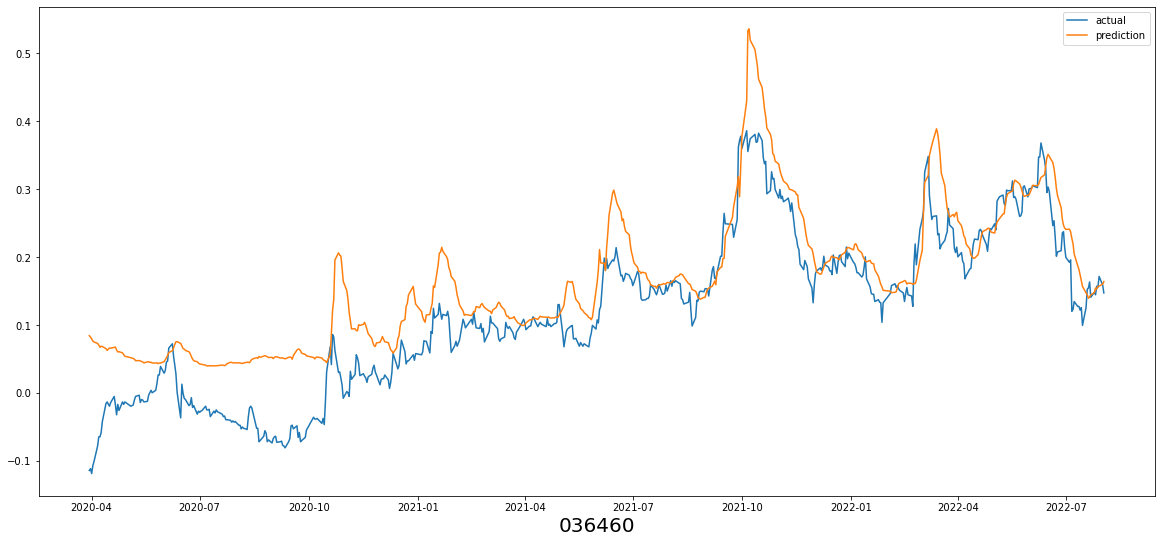

19/19 [==============================] - 1s 5ms/step
017390의 test_data의 출력 크기 :  (580, 1)


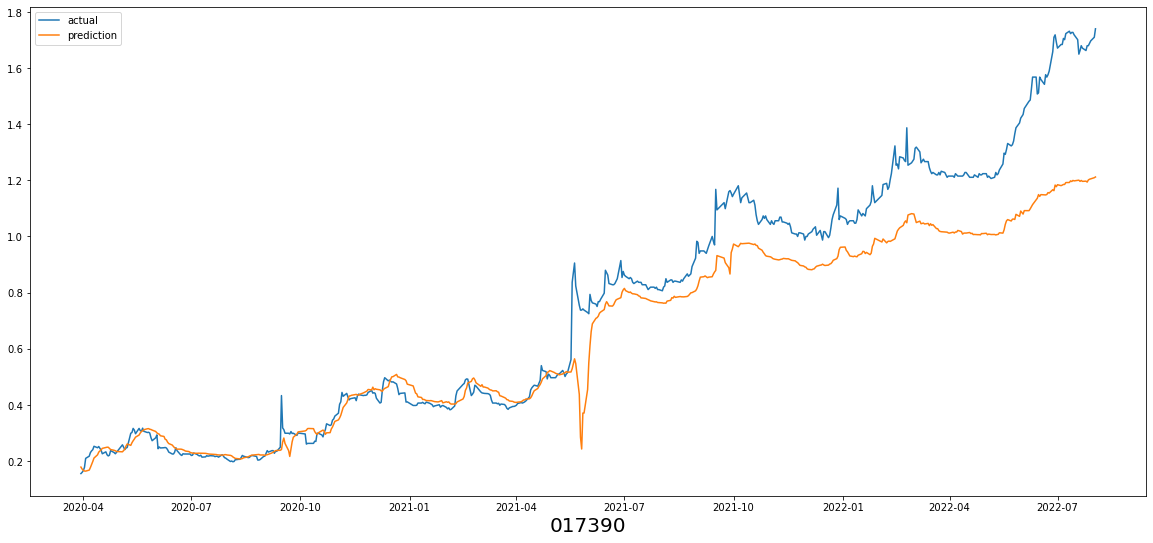

---------------Tele---------------
19/19 [==============================] - 1s 4ms/step
017670의 test_data의 출력 크기 :  (580, 1)


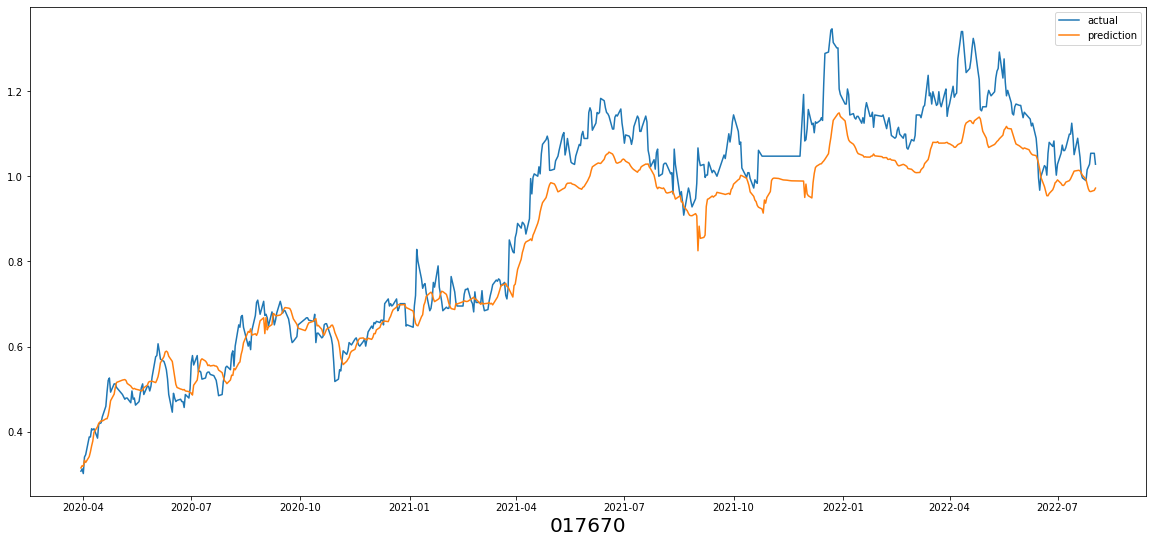

19/19 [==============================] - 1s 4ms/step
030200의 test_data의 출력 크기 :  (580, 1)


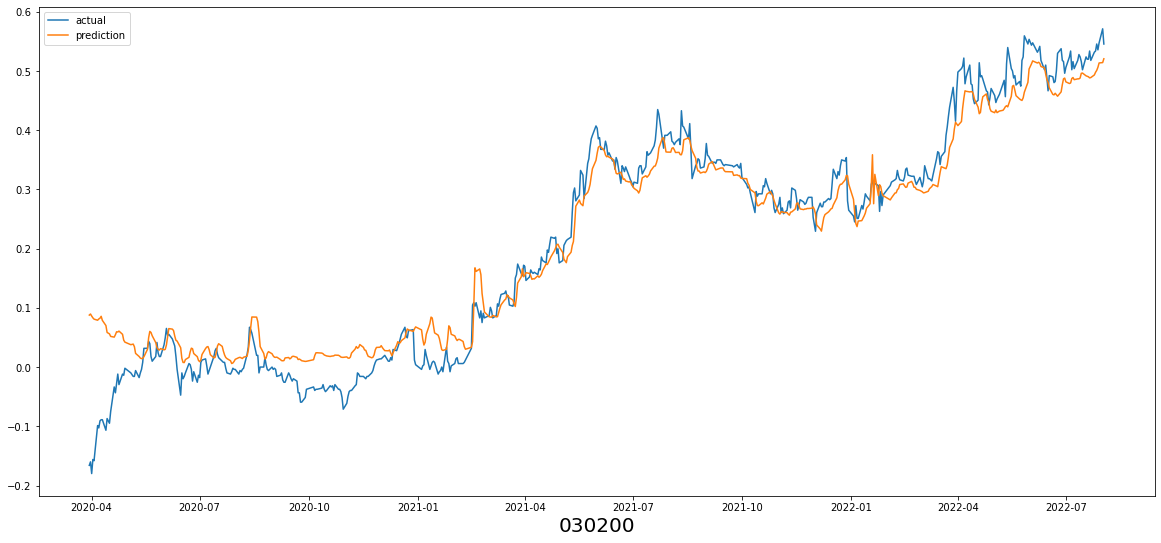

19/19 [==============================] - 1s 5ms/step
032640의 test_data의 출력 크기 :  (580, 1)


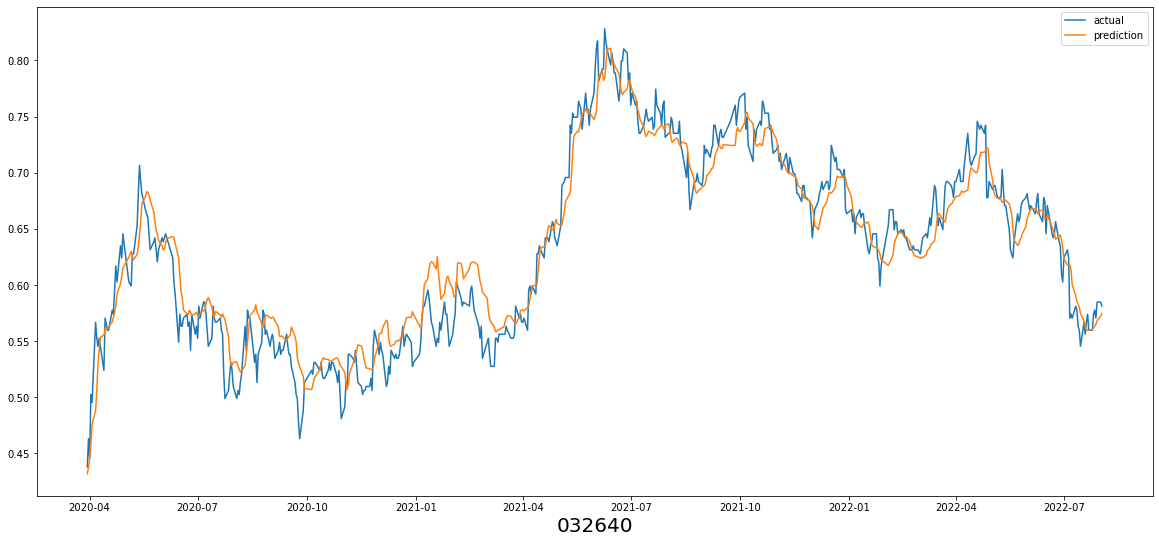

---------------Finance---------------
19/19 [==============================] - 1s 5ms/step
003550의 test_data의 출력 크기 :  (580, 1)


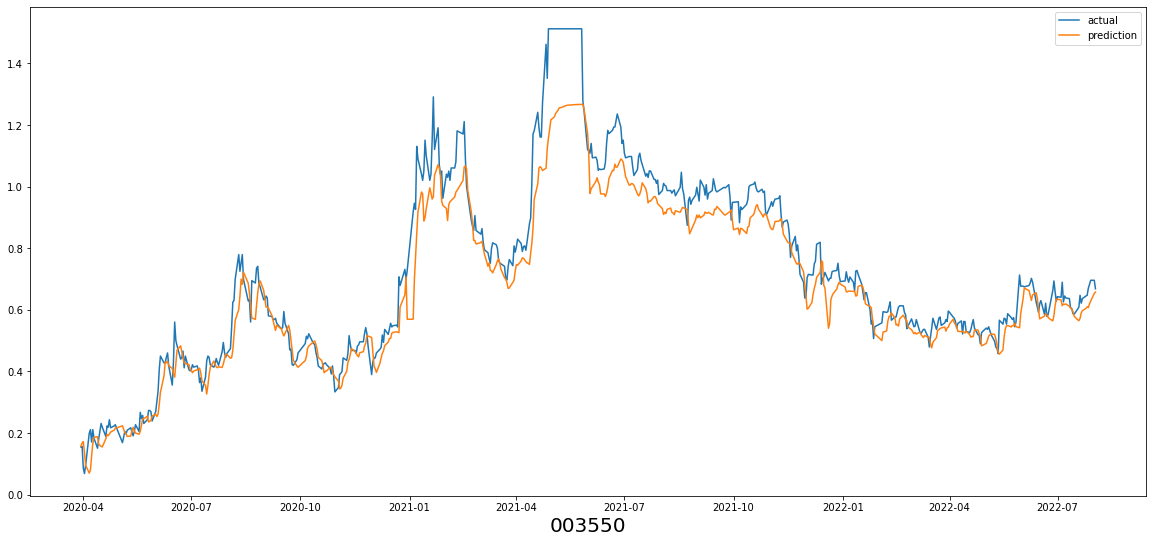

19/19 [==============================] - 1s 5ms/step
000810의 test_data의 출력 크기 :  (580, 1)


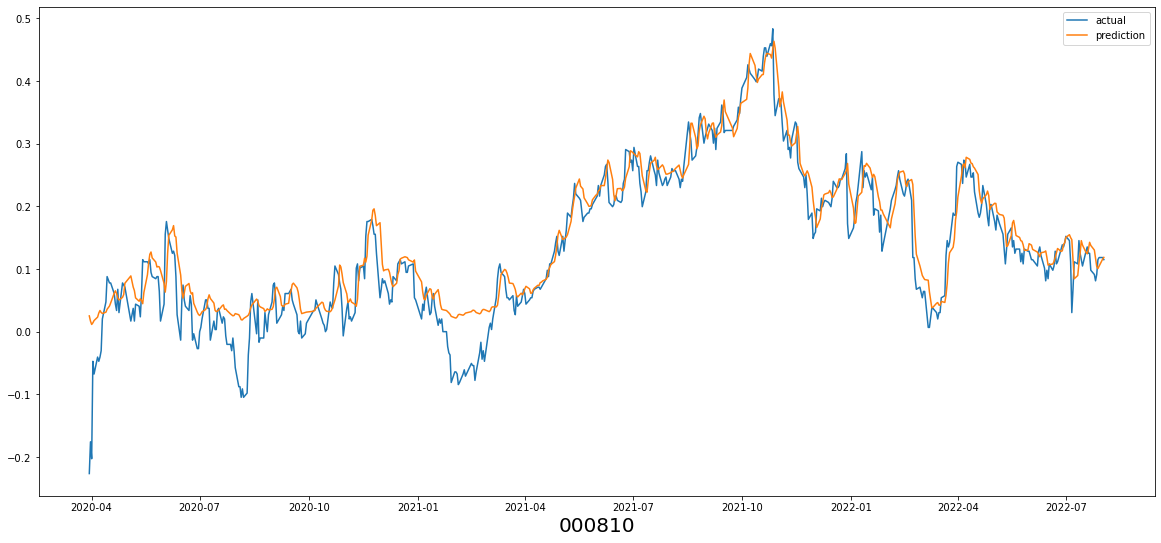

19/19 [==============================] - 1s 4ms/step
006800의 test_data의 출력 크기 :  (580, 1)


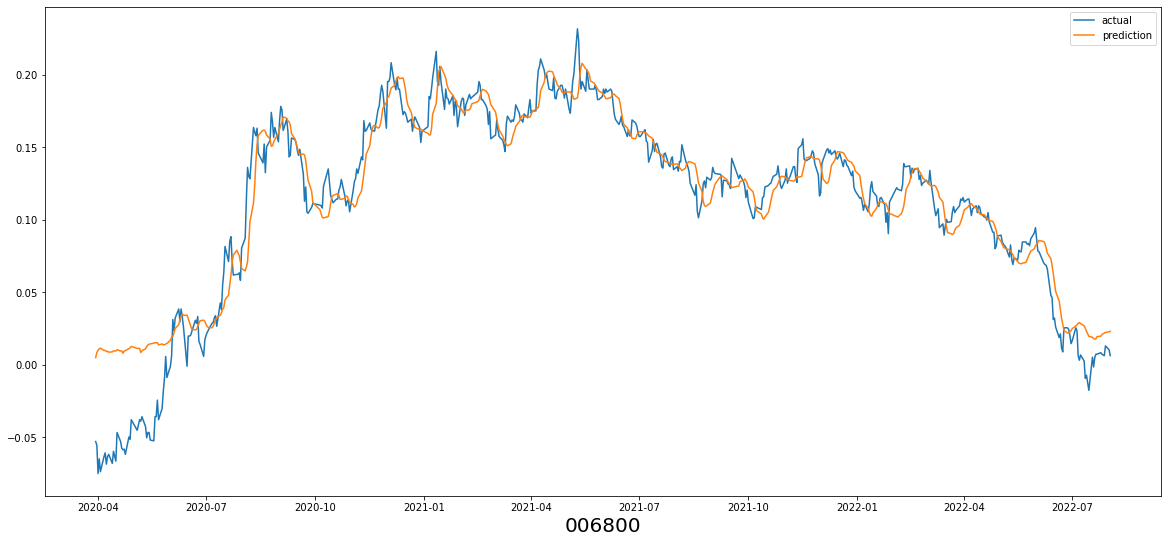

---------------Brokerage---------------
19/19 [==============================] - 1s 4ms/step
005940의 test_data의 출력 크기 :  (580, 1)


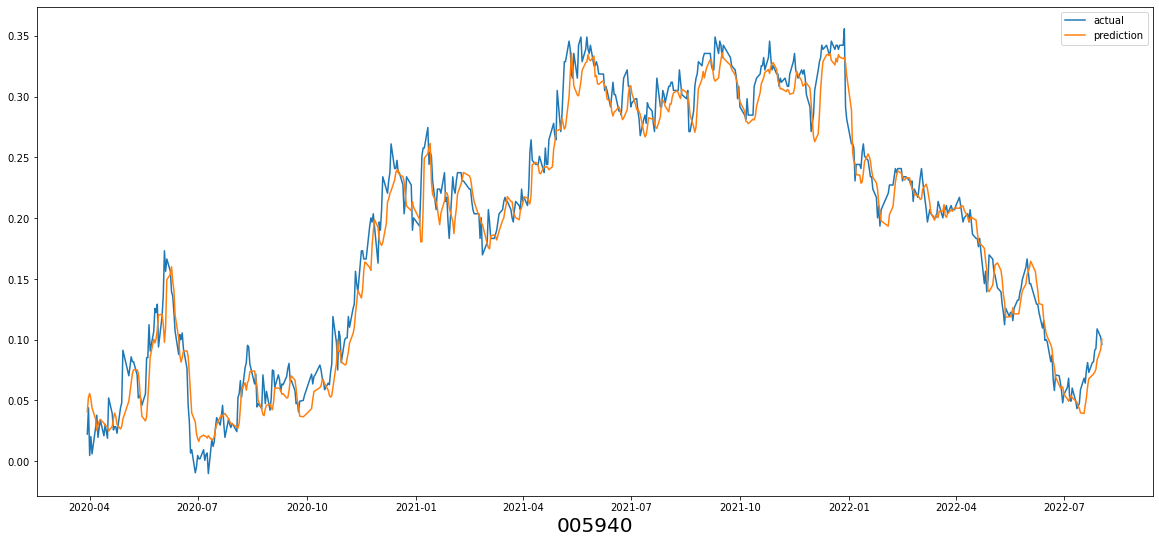

19/19 [==============================] - 1s 4ms/step
016360의 test_data의 출력 크기 :  (580, 1)


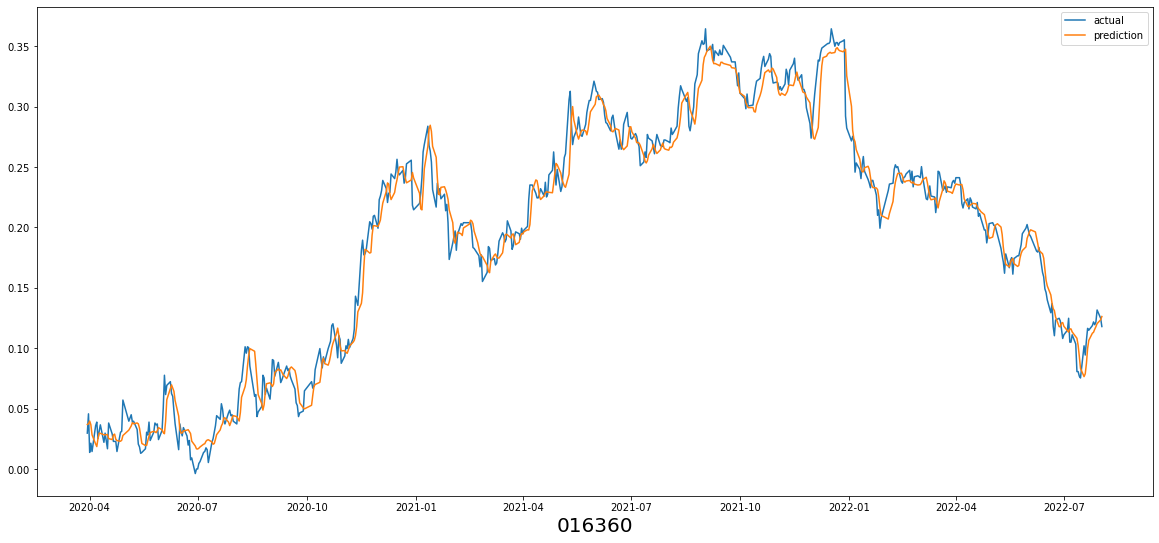

19/19 [==============================] - 1s 5ms/step
008560의 test_data의 출력 크기 :  (580, 1)


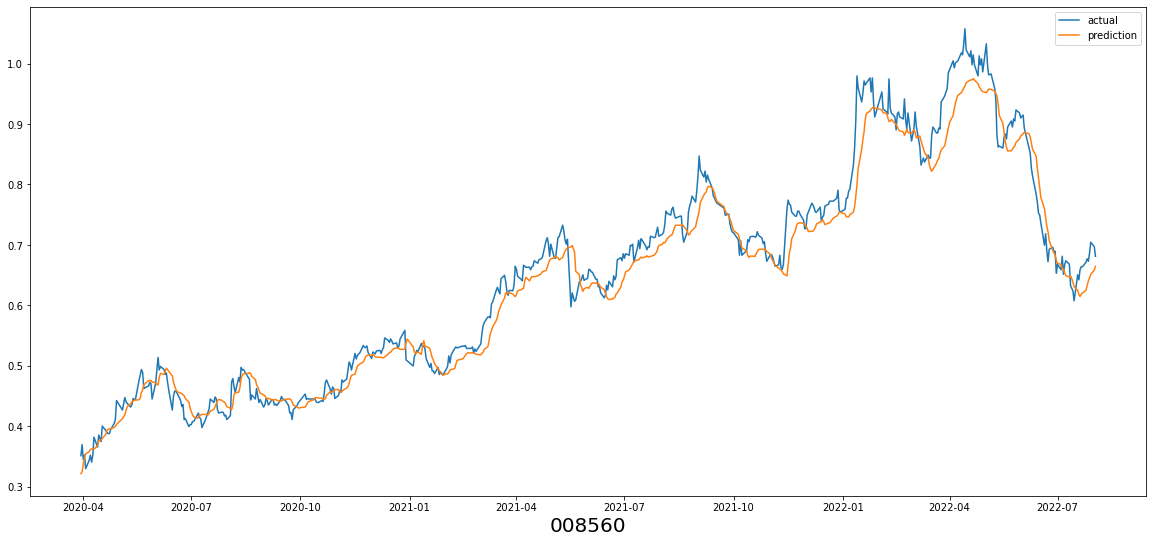

19/19 [==============================] - 1s 4ms/step
039490의 test_data의 출력 크기 :  (580, 1)


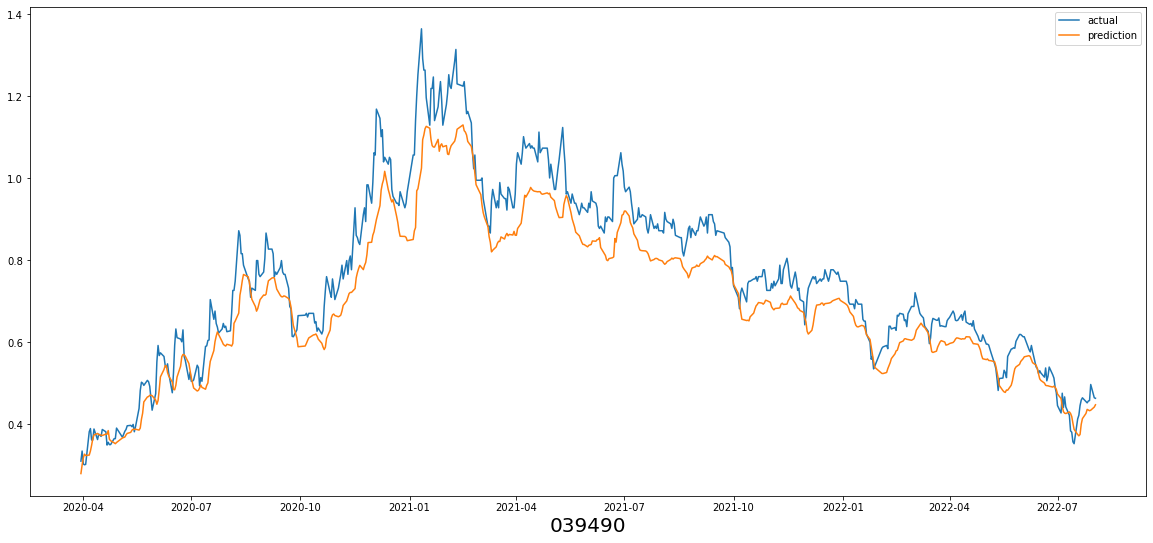

---------------Insurer---------------
19/19 [==============================] - 1s 5ms/step
032830의 test_data의 출력 크기 :  (580, 1)


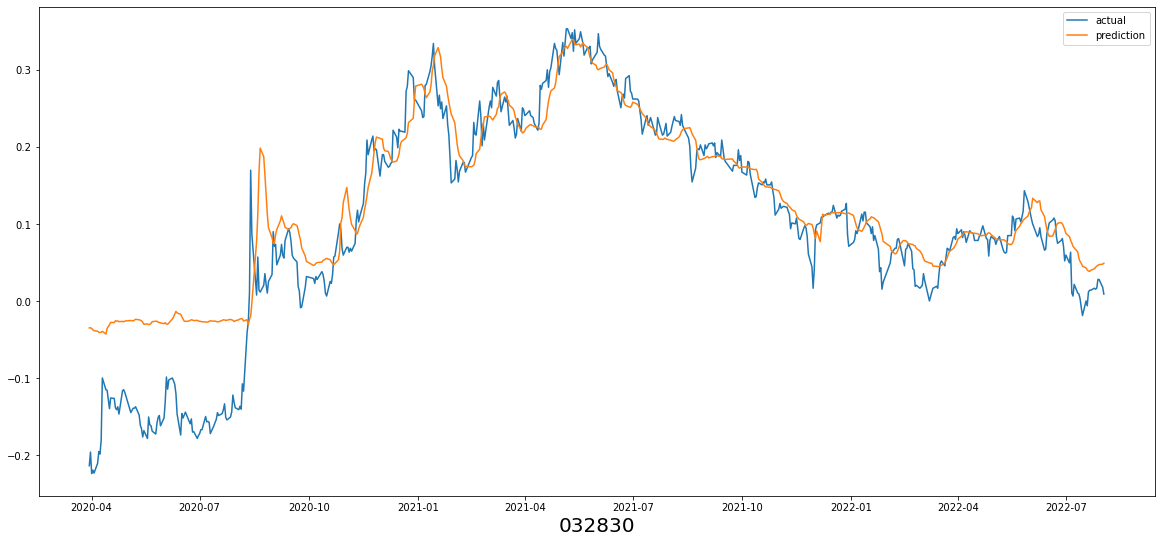

19/19 [==============================] - 1s 4ms/step
005830의 test_data의 출력 크기 :  (580, 1)


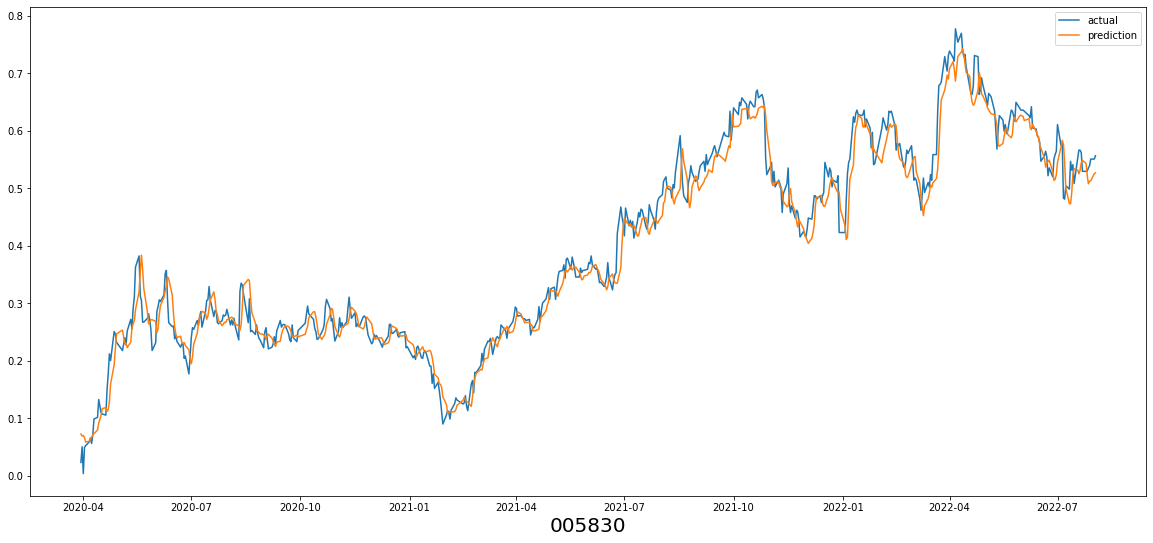

19/19 [==============================] - 1s 5ms/step
000060의 test_data의 출력 크기 :  (580, 1)


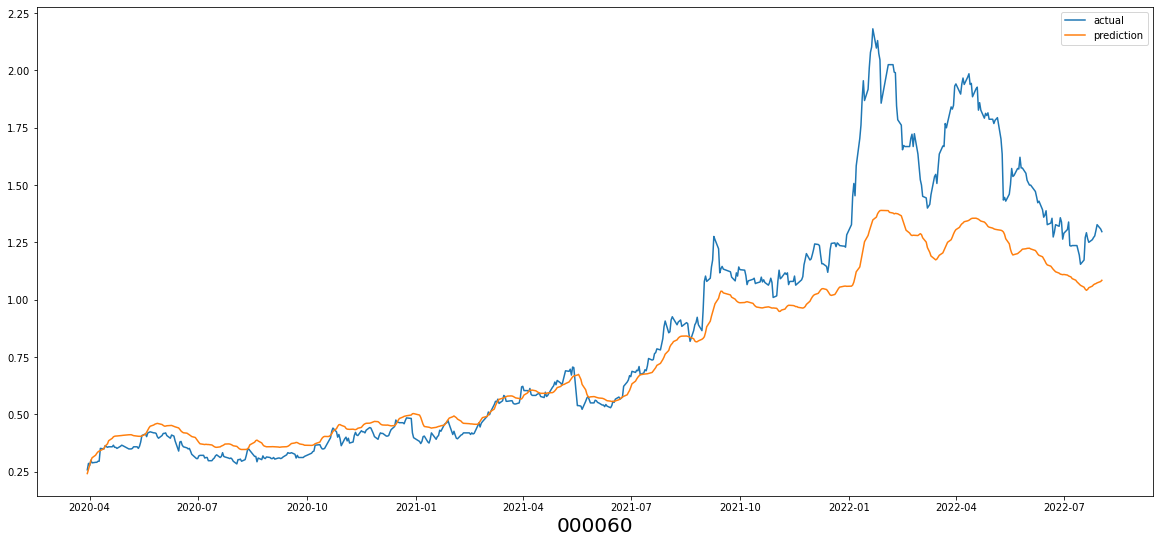

19/19 [==============================] - 1s 5ms/step
001450의 test_data의 출력 크기 :  (580, 1)


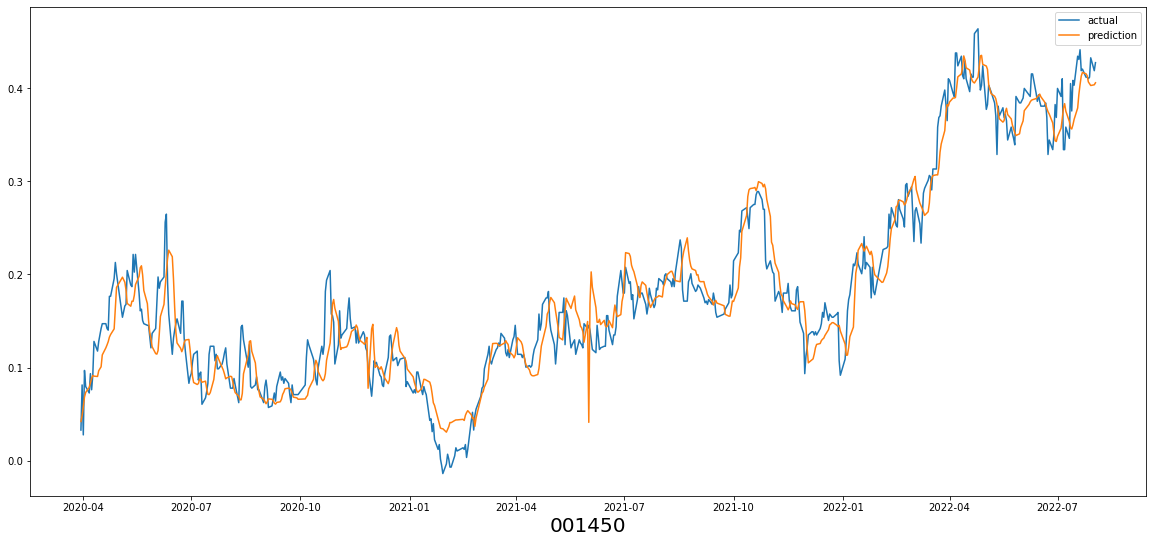

---------------Service---------------
19/19 [==============================] - 1s 4ms/step
035420의 test_data의 출력 크기 :  (580, 1)


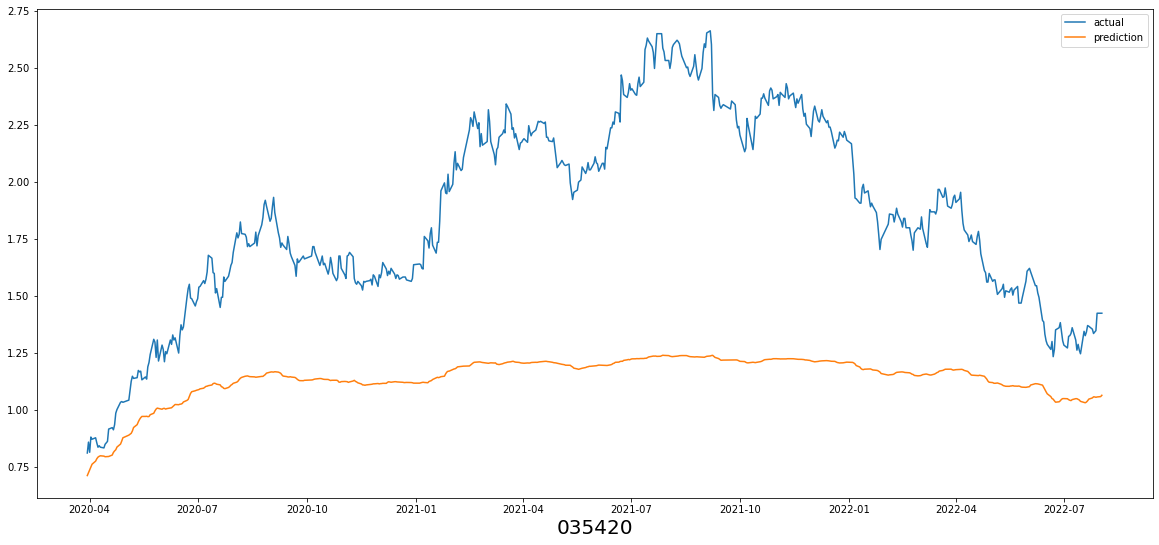

19/19 [==============================] - 1s 5ms/step
035720의 test_data의 출력 크기 :  (580, 1)


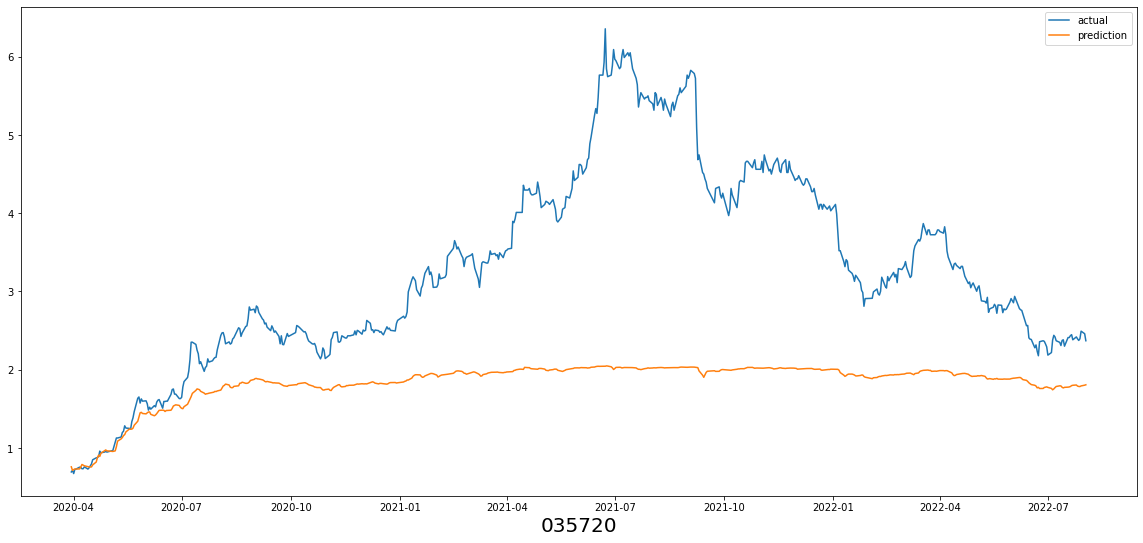

12/12 [==============================] - 1s 5ms/step
018260의 test_data의 출력 크기 :  (371, 1)


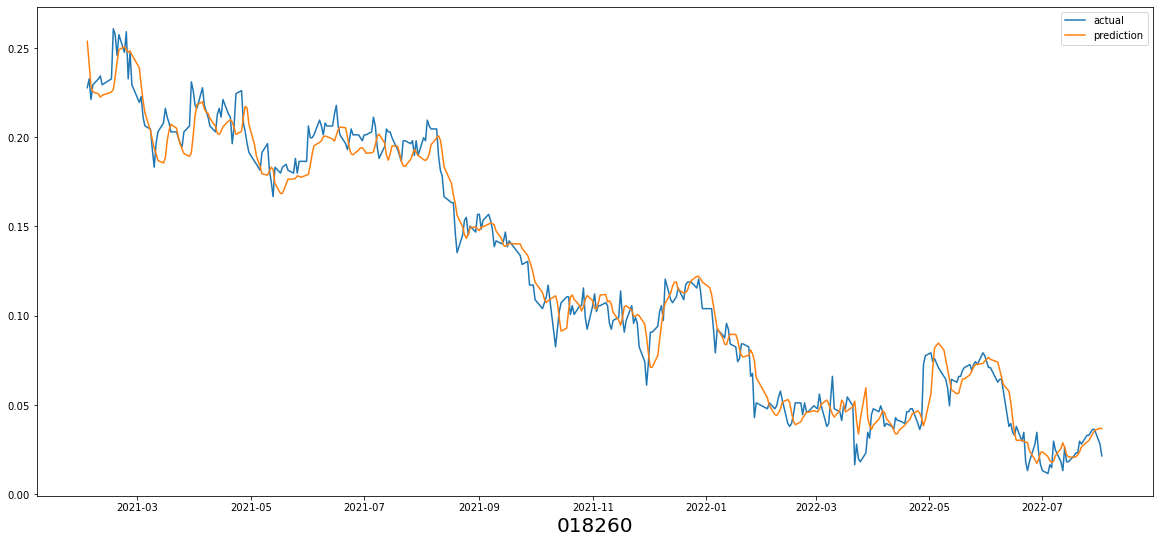

19/19 [==============================] - 1s 5ms/step
036570의 test_data의 출력 크기 :  (580, 1)


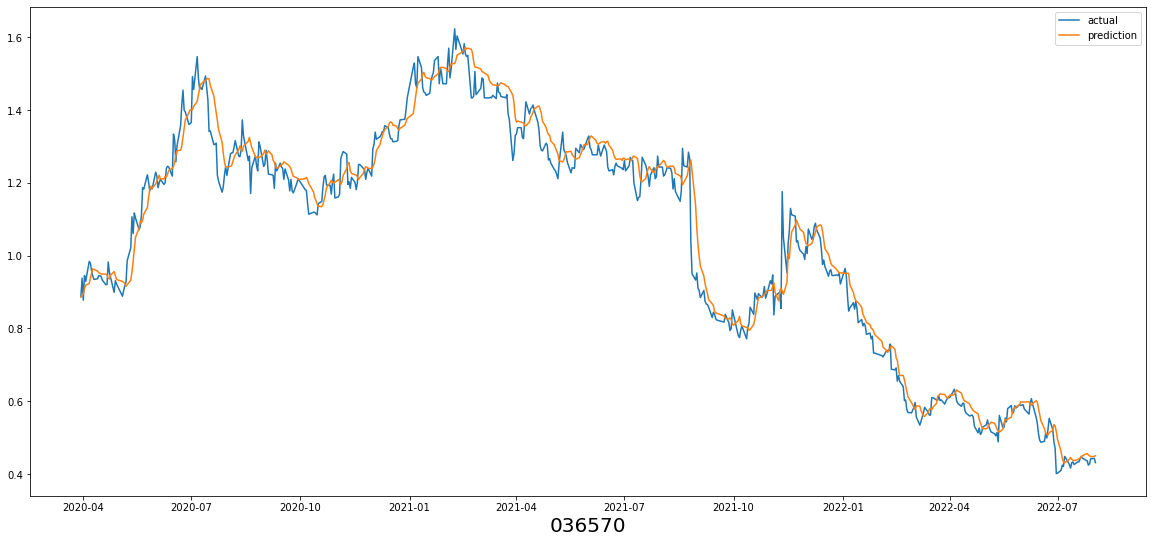

---------------Manufacturer---------------
19/19 [==============================] - 1s 4ms/step
005380의 test_data의 출력 크기 :  (580, 1)


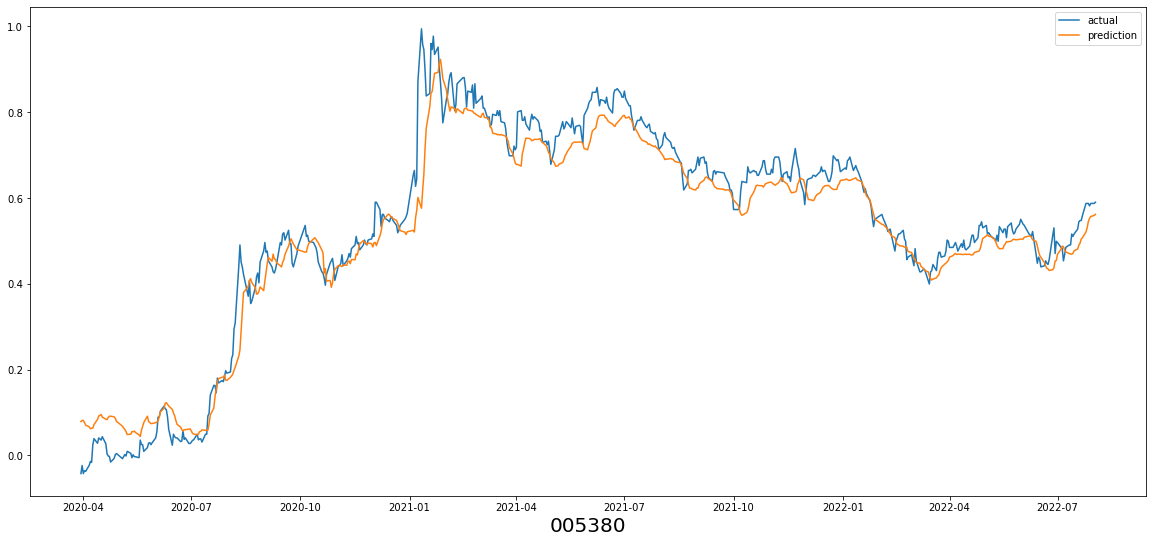

19/19 [==============================] - 1s 4ms/step
000270의 test_data의 출력 크기 :  (580, 1)


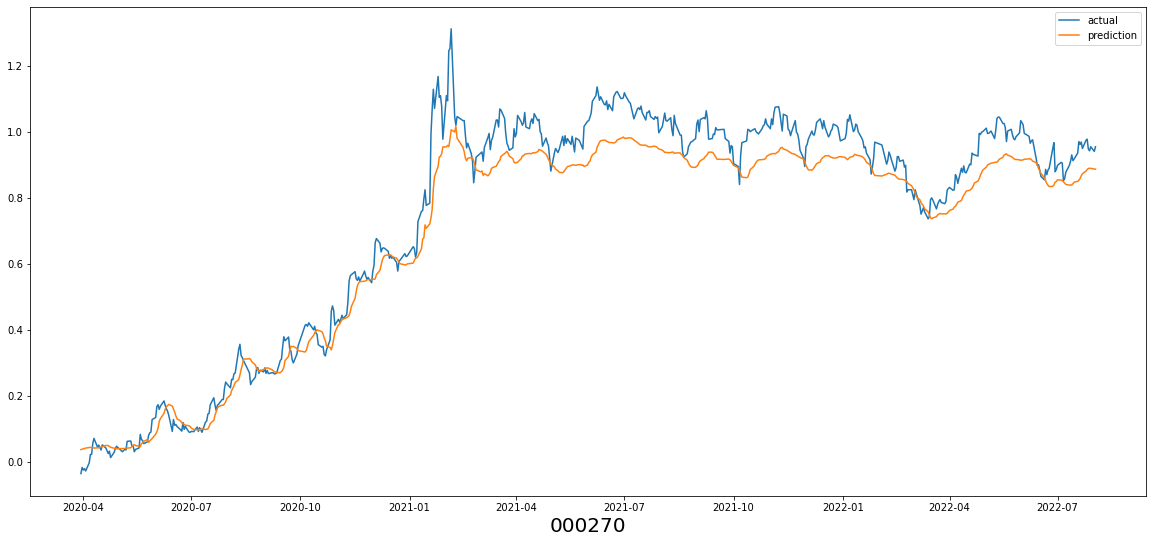

19/19 [==============================] - 1s 5ms/step
012330의 test_data의 출력 크기 :  (580, 1)


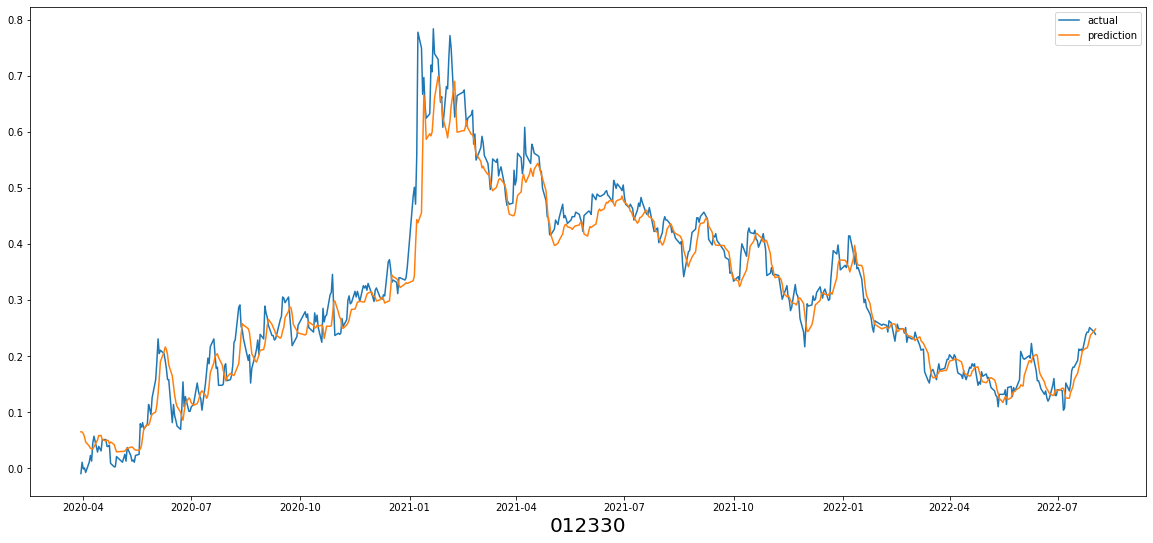

19/19 [==============================] - 1s 4ms/step
033780의 test_data의 출력 크기 :  (580, 1)


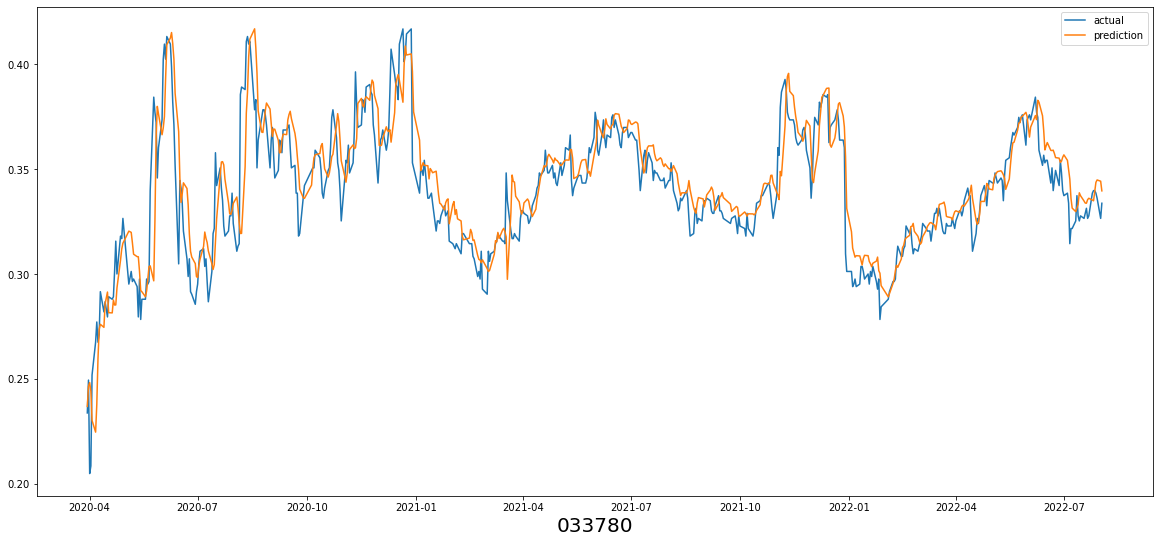

19/19 [==============================] - 1s 5ms/step
009150의 test_data의 출력 크기 :  (580, 1)


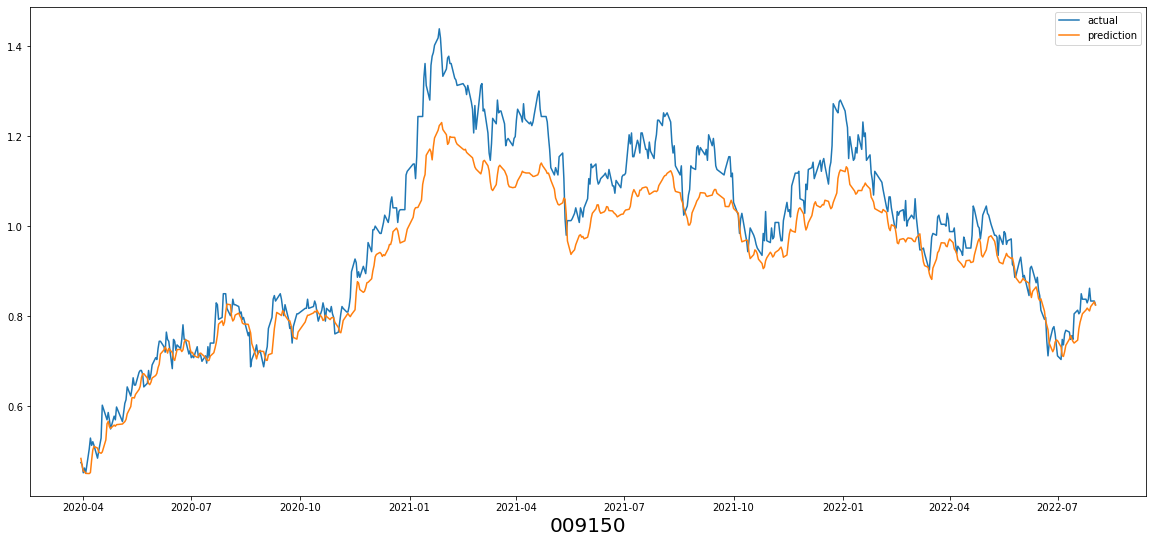

In [28]:
for sector_name, sector_model_dic in model_dic.items():
    print('-'*15+f'{sector_name}'+'-'*15)
    for stock_code, model in sector_model_dic.items():
        df_일자 = (y_test_scaled_dic[sector_name][stock_code].index)[WINDOW_SIZE:]
        pred = model.predict(tf_dataset_test_dic[sector_name][stock_code])
        print(f'{stock_code}의 test_data의 출력 크기 : ' ,pred.shape)
        plt.figure(figsize=(20, 9))
        plt.xlabel(stock_code, fontdict={'size': 20})
        plt.plot(df_일자,np.asarray(y_test_scaled_dic[sector_name][stock_code])[WINDOW_SIZE:], label='actual')
        plt.plot(df_일자,pred, label='prediction')
        plt.legend()
        plt.show()

In [29]:
score_dic = {}
for sector_name, sector_model in model_dic.items():
    score_dic[sector_name] = {}
    print(f'------------------{sector_name}별 점수----------------')
    for stock_code, model in sector_model.items():
        score = model.evaluate(tf_dataset_test_dic[sector_name][stock_code])
        score_dic[sector_name][stock_code] = score
        print(f'{stock_code} 모델의 성능 지표 : MSE =  {score[1]:0.4f}, loss= {score[0]:0.4f}')

------------------Food별 점수----------------
19/19 [==============================] - 0s 5ms/step - loss: 0.0050 - mse: 0.0100
097950 모델의 성능 지표 : MSE =  0.0100, loss= 0.0050
8/8 [==============================] - 0s 6ms/step - loss: 0.0013 - mse: 0.0027
271560 모델의 성능 지표 : MSE =  0.0027, loss= 0.0013
19/19 [==============================] - 0s 5ms/step - loss: 7.8314e-04 - mse: 0.0016
000080 모델의 성능 지표 : MSE =  0.0016, loss= 0.0008
19/19 [==============================] - 0s 4ms/step - loss: 2.0098e-04 - mse: 4.0196e-04
004370 모델의 성능 지표 : MSE =  0.0004, loss= 0.0002
19/19 [==============================] - 0s 5ms/step - loss: 3.4946e-04 - mse: 6.9892e-04
005300 모델의 성능 지표 : MSE =  0.0007, loss= 0.0003
------------------Clothing별 점수----------------
19/19 [==============================] - 0s 4ms/step - loss: 2.6819e-04 - mse: 5.3639e-04
093050 모델의 성능 지표 : MSE =  0.0005, loss= 0.0003
19/19 [==============================] - 0s 4ms/step - loss: 6.6691e-04 - mse: 0.0013
020000 모델의 성능 지표 : MSE =

19/19 [==============================] - 0s 4ms/step - loss: 1.6503e-04 - mse: 3.3007e-04
005940 모델의 성능 지표 : MSE =  0.0003, loss= 0.0002
19/19 [==============================] - 0s 4ms/step - loss: 1.0403e-04 - mse: 2.0806e-04
016360 모델의 성능 지표 : MSE =  0.0002, loss= 0.0001
19/19 [==============================] - 0s 4ms/step - loss: 5.5476e-04 - mse: 0.0011
008560 모델의 성능 지표 : MSE =  0.0011, loss= 0.0006
19/19 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0068
039490 모델의 성능 지표 : MSE =  0.0068, loss= 0.0034
------------------Insurer별 점수----------------
19/19 [==============================] - 0s 4ms/step - loss: 0.0017 - mse: 0.0035
032830 모델의 성능 지표 : MSE =  0.0035, loss= 0.0017
19/19 [==============================] - 0s 4ms/step - loss: 4.5914e-04 - mse: 9.1829e-04
005830 모델의 성능 지표 : MSE =  0.0009, loss= 0.0005
19/19 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 0.0504
000060 모델의 성능 지표 : MSE =  0.0504, loss= 0.0252
19/19 [================

In [30]:
with open('score_dic.pickle','wb') as f:
    pickle.dump(score_dic,f)


In [34]:
pred = model_dic['Food']['000080'].predict(tf_dataset_test_dic['Food']['000080'])
print(len(y_test_scaled_dic['Food']['000080'].iloc[WINDOW_SIZE:]))
print(len(pred))



19/19 [==============================] - 3s 109ms/step
580
580


In [41]:
np.flip(np.flip(pred.flatten())[:20])


array([0.60935825, 0.60662097, 0.6040349 , 0.60728335, 0.60296625,
       0.5882987 , 0.57438356, 0.5756355 , 0.5750176 , 0.5691392 ,
       0.5696426 , 0.5771076 , 0.5782762 , 0.5750038 , 0.5693196 ,
       0.57129693, 0.5782682 , 0.5904597 , 0.5936461 , 0.59882927],
      dtype=float32)

In [61]:
y_test_scaled_dic['Food']['000080'].iloc[580:600]['종가'].values

array([0.6122449 , 0.61836735, 0.62653061, 0.59387755, 0.57142857,
       0.59591837, 0.59387755, 0.57142857, 0.58367347, 0.59183673,
       0.59183673, 0.5877551 , 0.58163265, 0.5877551 , 0.60204082,
       0.60816327, 0.60612245, 0.61020408, 0.60612245, 0.62857143])

In [44]:
y_test_scaled_dic['Food']['000080'].tail(20).values.flatten()

array([0.6122449 , 0.61836735, 0.62653061, 0.59387755, 0.57142857,
       0.59591837, 0.59387755, 0.57142857, 0.58367347, 0.59183673,
       0.59183673, 0.5877551 , 0.58163265, 0.5877551 , 0.60204082,
       0.60816327, 0.60612245, 0.61020408, 0.60612245, 0.62857143])

In [75]:
zzzzzzzz

array([0.6122449 , 0.61836735, 0.62653061, 0.59387755, 0.57142857,
       0.59591837, 0.59387755, 0.57142857, 0.58367347, 0.59183673,
       0.59183673, 0.5877551 , 0.58163265, 0.5877551 , 0.60204082,
       0.60816327, 0.60612245, 0.61020408, 0.60612245, 0.62857143])

In [ ]:
im

In [22]:
with open('filename_dic.pickle','rb') as f:
    filename_dic  = pickle.load(f)

In [23]:
for sector_name, filename_sector in filename_dic.items():
    for stock_code, filename in filename_sector.items():
        model_dic[sector_name][stock_code].load_weights(filename)

## 최근 20일 동안의 테스트데이터셋에 대한 오차 범위 0.05인 주가 항목만 필터링

In [24]:
certificated_stock_dic = {}
for sector_name, sector_model in model_dic.items():
    certificated_stock_dic[sector_name] = []
    for stock_code, model in sector_model.items():
        sumError = 0
        pred = model.predict(tf_dataset_test_dic[sector_name][stock_code]).flatten() #벡터 np.flip(np.flip(pred.flatten())[:20])
        pred = np.flip(np.flip(pred)[:20])
        actual=y_test_scaled_dic[sector_name][stock_code].tail(20).values.flatten()
        for i in range(len(pred)):
            sumError+=abs(actual[i]-pred[i])
        meanError = sumError/len(pred)
        if meanError <= 0.05:
            certificated_stock_dic[sector_name].append(stock_code)
        

19/19 [==============================] - 1s 3ms/step


## certificated_stock_dic

In [25]:
sector

{'Food': ['097950', '271560', '000080', '004370', '005300'],
 'Clothing': ['093050', '020000', '105630', '001070'],
 'Chemical': ['051910', '096770', '010950', '051900', '090430'],
 'Medicine': ['207940', '068270', '000100', '128940'],
 'Non_Metal': ['003670', '003410', '010780'],
 'Metal': ['005490', '010130', '004020', '016380', '001230'],
 'Machine': ['034020', '018880', '241560', '112610'],
 'Electronic': ['005930', '000660', '006400', '066570'],
 'Construction': ['000720', '006360', '047040', '051600'],
 'Transport': ['011200', '003490', '086280', '180640', '028670'],
 'Distribution': ['028260', '023530', '282330', '139480', '004170'],
 'Power': ['015760', '036460', '017390'],
 'Tele': ['017670', '030200', '032640'],
 'Finance': ['003550', '000810', '006800'],
 'Brokerage': ['005940', '016360', '008560', '039490'],
 'Insurer': ['032830', '005830', '000060', '001450'],
 'Service': ['035420', '035720', '018260', '036570'],
 'Manufacturer': ['005380', '000270', '012330', '033780', '0

In [26]:
certificated_stock_dic

{'Food': ['271560', '000080', '004370', '005300'],
 'Clothing': ['093050', '020000', '105630'],
 'Chemical': ['096770', '010950', '051900', '090430'],
 'Medicine': ['207940', '068270', '128940'],
 'Non_Metal': ['003410', '010780'],
 'Metal': ['005490', '010130', '004020', '016380', '001230'],
 'Machine': ['034020', '018880', '241560'],
 'Electronic': ['005930', '000660', '066570'],
 'Construction': ['000720', '006360', '047040', '051600'],
 'Transport': ['011200', '003490', '086280', '180640', '028670'],
 'Distribution': ['028260', '023530', '282330', '139480', '004170'],
 'Power': ['015760', '036460'],
 'Tele': ['030200', '032640'],
 'Finance': ['003550', '000810', '006800'],
 'Brokerage': ['005940', '016360', '008560', '039490'],
 'Insurer': ['032830', '005830', '001450'],
 'Service': ['018260', '036570'],
 'Manufacturer': ['005380', '000270', '012330', '033780', '009150']}

In [27]:
with open('certificated_stock_dic.pickle', 'wb') as f:
    pickle.dump(certificated_stock_dic,f)